### Setup

In [63]:
#imports and Setup
import numpy as np
import random  
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, Polygon


%matplotlib inline


np.random.seed(42)

# Section 1: Introduction + Data analysis and visualization

In [3]:
trips = pd.read_csv('C:/Users/User/OneDrive/Ambiente de Trabalho/Trips_2018.csv')

In [4]:
trips['starttime'] = pd.to_datetime(trips['starttime'])
trips['stoptime'] = pd.to_datetime(trips['stoptime'])

trips.dtypes

Unnamed: 0                          int64
tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                          int64
gender                              int64
dtype: object

### Missing Values

We first will evaluate whether there are any missing values in our dataset and eliminate them

In [5]:
print(trips.isna().sum())

Unnamed: 0                    0
tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
usertype                      0
birth_year                    0
gender                        0
dtype: int64


In [6]:
trips = trips.dropna()
print(trips.isna().sum())

Unnamed: 0                 0
tripduration               0
starttime                  0
stoptime                   0
start_station_id           0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_latitude       0
end_station_longitude      0
bikeid                     0
usertype                   0
birth_year                 0
gender                     0
dtype: int64


**We also need to check whether there is any station with different geographic locations, so that we can correct it.**

In [7]:
# Group the data by station ID and get unique latitude and longitude pairs for each station
station_locations = trips.groupby('start_station_id')[['start_station_latitude', 'start_station_longitude']].nunique()

# Filter for stations with more than one unique location
stations_with_multiple_locs = station_locations[
    (station_locations['start_station_latitude'] > 1) | (station_locations['start_station_longitude'] > 1)]

# Get the station IDs with multiple locations
station_ids_with_multiple_locs = stations_with_multiple_locs.index

# Filter the original DataFrame to include only stations with multiple locations
stations_table = trips[trips['start_station_id'].isin(station_ids_with_multiple_locs)]

# Group the filtered DataFrame by station ID, latitude, and longitude and count the number of cases
station_counts = stations_table.groupby(['start_station_id', 'start_station_latitude', 'start_station_longitude']).size().reset_index(name='case_count')

# Display the table with station ID, latitude, longitude, and case count
station_counts


,start_station_id,start_station_latitude,start_station_longitude,case_count
0,530.0,40.771497,-73.990460,2542
1,530.0,40.771522,-73.990541,42931


**We can see that station 530 is the only one that has more the one pair of coordinates. We will try to analyse if there is an explanation.**

In [8]:
# You can use the .loc method to create a new column 'type' based on your conditions
station_530 = trips[(trips['start_station_id'] == 530)]

station_530['type'] = np.where(station_530['start_station_latitude'] == 40.771522,1, 2)

C:\Users\User\AppData\Local\Temp/ipykernel_30712/2212931836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_530['type'] = np.where(station_530['start_station_latitude'] == 40.771522,1, 2)


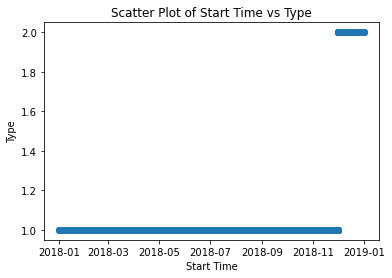

In [9]:
plt.scatter(station_530['starttime'], station_530['type'], alpha=0.5)  # Create the scatter plot
plt.xlabel('Start Time')  # Label for the x-axis
plt.ylabel('Type')  # Label for the y-axis
plt.title('Scatter Plot of Start Time vs Type')  # Title for the plot

plt.show()  # Display the plot

In [10]:
trips_1st_loc=station_530[(station_530['type'] == 1)]

**From the graph above we can conclude that this station chaged the location in the day 30-11-2018, from (40.771522,-73.990541) to  (40.771497,-73.990460). We also check on Google Maps and we see that the station location was updated to new coordinates very close to the original. We can suppose that there were some constructions on the road, or the original station location was worong and then was updated to the right place, analysing the street view we see that before it was in the middle of the road and now the location is in the pavement. We will then substitute the 42931 first observations coordinates with the new ones.**

In [11]:
trips.loc[trips['start_station_id'] == 530, 'start_station_latitude'] = 40.771497
trips.loc[trips['start_station_id'] == 530, 'start_station_longitude'] = -73.990460
trips.loc[trips['end_station_id'] == 530, 'end_station_latitude'] = 40.771497
trips.loc[trips['start_station_id'] == 530, 'start_station_latitude'] = -73.990460

### Duplicate Values

In [12]:
len(trips[trips.duplicated()])

0

**Dummification gender and subscribers**

In [13]:
# Assuming 'column_to_dummify' is the name of the column
dummies = pd.get_dummies(trips['usertype'], prefix='dummy')

# Concatenate the new dummy columns to the original DataFrame
trips = pd.concat([trips, dummies], axis=1)

# Optionally, drop the original column if you no longer need it
trips = trips.drop('usertype', axis=1)

### Histograms

**Basic Histograms will help us to understand if there may be anthing wrong with some of the variables**

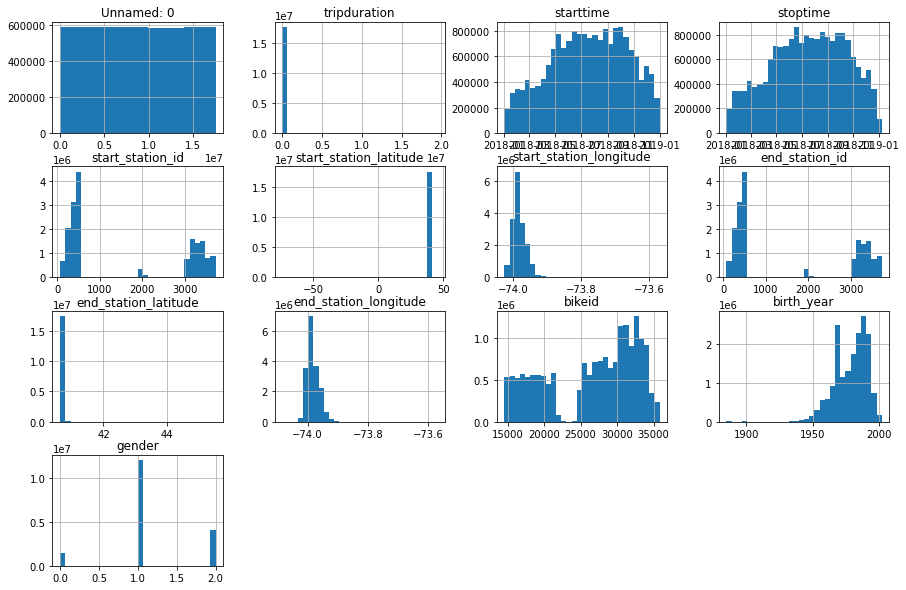

In [14]:
trips.hist(bins=30, figsize=(15, 10))
plt.title('Variable Histograms')  # Set an empty title to remove the descriptive statistics
plt.show()

**We can see that there are some problems with trip duration.**

From the following histograms we can see that users should use bikes for max around 4h (usual users), so should we use this as an outlier? or should we consider for further analysis the number of people that dont know about this problem?
Also, if you have the bycicle for more than 24 hours you are charged an extra fee. Can we consider that as a real threshold? 

Another good point in a business analysis: if we prevent people having the bike for too long maybe we can better satisfy the demand.

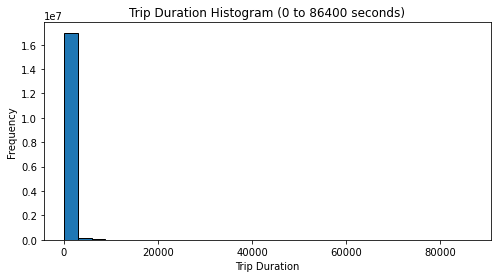

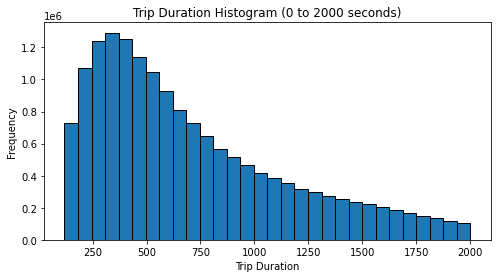

In [15]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'trips' and a 'tripduration' column
trip_duration = trips['tripduration']

# Define maximum durations
max_duration_1 = 86400  # First maximum duration (24 hours)
max_duration_2 = 2000   # Second maximum duration

# Filter the data to include only trip durations within the defined range (First maximum)
filtered_trip_duration_1 = trip_duration[(trip_duration >= 120) & (trip_duration <= max_duration_1)]

# Create a smaller histogram of trip durations (First maximum)
plt.figure(figsize=(8, 4))
plt.hist(filtered_trip_duration_1, bins=30, edgecolor='k')

plt.title('Trip Duration Histogram (0 to 86400 seconds)')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.show()

# Filter the data to include only trip durations within the defined range (Second maximum)
filtered_trip_duration_2 = trip_duration[(trip_duration >= 120) & (trip_duration <= max_duration_2)]

# Create a smaller histogram of trip durations (Second maximum)
plt.figure(figsize=(8, 4))
plt.hist(filtered_trip_duration_2, bins=30, edgecolor='k')

plt.title('Trip Duration Histogram (0 to 2000 seconds)')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.show()

**Let's remove:**

**1- Trips with non-matching trip duration, and difference between start and end time. A difference of over 1 second was considered inconsistent.**

**2- All trips with under 120 seconds that start and end in the same station.**

**3- All trips with less than 20 seconds (if any)**

**4- All trips with trip duration over 4h**

## Falta gráfico viagens >4h por horas do dia

In [16]:
inconsistent_rows = trips[abs(trips['tripduration'] - (trips['stoptime'] - trips['starttime']).dt.total_seconds()) >= 1]
len(inconsistent_rows)

151

In [17]:
trips = trips.drop(inconsistent_rows.index)

In [18]:
trips_to_same_station = trips[(trips['end_station_id'] == trips['start_station_id']) & (trips['tripduration'] <= 120)]

len(trips_to_same_station)

39141

In [19]:
trips = trips.drop(trips_to_same_station.index)

In [20]:
too_short_trips = trips[trips['tripduration'] <= 20]

len(too_short_trips)

0

In [21]:
trips = trips.drop(too_short_trips.index)

In [22]:
too_long_trips = trips[trips['tripduration'] >= 14400]

len(too_long_trips)

19421

In [29]:
trips = trips.drop(too_long_trips.index)

KeyError: '[3177, 3943, 7665, 10847, 12335, 14282, 15541, 19815, 25108, 25807, 27431, 27613, 31380, 32525, 32930, 33524, 33533, 34271, 37286, 41986, 42435, 45444, 45447, 47880, 48381, 49720, 49721, 49818, 50376, 51196, 52525, 57637, 59935, 59998, 62471, 63880, 67881, 69358, 70386, 71280, 71302, 73664, 76089, 76729, 79774, 82942, 84860, 85190, 86039, 86239, 86377, 88222, 89927, 89994, 90971, 91227, 93507, 98956, 100094, 100499, 100761, 101420, 103526, 105749, 106010, 107447, 107678, 108189, 108700, 109957, 112993, 115249, 116109, 116627, 119577, 120088, 120212, 121116, 121746, 121906, 123214, 123325, 124653, 124654, 126472, 133453, 135823, 136651, 144997, 145071, 147485, 152566, 158528, 159666, 160996, 162034, 165333, 166480, 167614, 171059, 171866, 172659, 177070, 178614, 179878, 180508, 184137, 184893, 186492, 186925, 193054, 193088, 195119, 196190, 198658, 200762, 201616, 203212, 205558, 208911, 212753, 213339, 216403, 217105, 217134, 217383, 217789, 218868, 222252, 223431, 224528, 226889, 229025, 233684, 240996, 242481, 248106, 249472, 250724, 252486, 252574, 256205, 258909, 260210, 261311, 262722, 264164, 264234, 267474, 269410, 269411, 270190, 271802, 276918, 277391, 277424, 278088, 278398, 279991, 281144, 284079, 284918, 284919, 285434, 286826, 288204, 288589, 289202, 291827, 293021, 297356, 297834, 298789, 307596, 308195, 308405, 310733, 320100, 321586, 321831, 323929, 330724, 333360, 334770, 334771, 335325, 341086, 349247, 350969, 356068, 356294, 356690, 367421, 369256, 372825, 376075, 377027, 377031, 379450, 380081, 388934, 389137, 389307, 391227, 391666, 392344, 392587, 393416, 393746, 401744, 401778, 414633, 415944, 416275, 416978, 427458, 427608, 428695, 431555, 435669, 438351, 438402, 446603, 447837, 449108, 451643, 451866, 452297, 452323, 455577, 455934, 456604, 456729, 457351, 460395, 461173, 462734, 464082, 465506, 466860, 466958, 467509, 467819, 469704, 470162, 471768, 472078, 473471, 474461, 474484, 474485, 474495, 474496, 474714, 475590, 476335, 476562, 476563, 477067, 477767, 478344, 480340, 480349, 482691, 482927, 483164, 483219, 484101, 484262, 484987, 486531, 487665, 487829, 490026, 490634, 491500, 491911, 492132, 492907, 494996, 495415, 495489, 495588, 496336, 497452, 498301, 501171, 502099, 502655, 503175, 503459, 503591, 504343, 508035, 509171, 509273, 509516, 510185, 511313, 511468, 511677, 512293, 513167, 513766, 514528, 515488, 516170, 516661, 517404, 517971, 518331, 520012, 520239, 520354, 524618, 524619, 525043, 527264, 528087, 528604, 530776, 533022, 533334, 533572, 534191, 534460, 537297, 537415, 537716, 537992, 538036, 538646, 542865, 543027, 545421, 550670, 550726, 551429, 552566, 552934, 553372, 553728, 554055, 555171, 555794, 560091, 560615, 561175, 563291, 564134, 564632, 565049, 569565, 570460, 575408, 578900, 579869, 580089, 585688, 585788, 588169, 588540, 589323, 590386, 590986, 592130, 592298, 592632, 595975, 598011, 599158, 599751, 600266, 600428, 600713, 601675, 601920, 603311, 604937, 608774, 608901, 610120, 612069, 612691, 613399, 614069, 615276, 615901, 617063, 617204, 617228, 617465, 617877, 618288, 619419, 620085, 621562, 621720, 621804, 623525, 623686, 624144, 627318, 627536, 629503, 631410, 631533, 632021, 634078, 634260, 635099, 636353, 636899, 637630, 637744, 638706, 640478, 640900, 641578, 642336, 643584, 643593, 643594, 643595, 644109, 644285, 644371, 644489, 644634, 645769, 645912, 647679, 648923, 649633, 652308, 652427, 652615, 654673, 656023, 656024, 659439, 660766, 662372, 667158, 669895, 670575, 671129, 671903, 674530, 675582, 675864, 676656, 677400, 678395, 678455, 679457, 679466, 680601, 681898, 682000, 682076, 682647, 683311, 683470, 683767, 684405, 685493, 686526, 686886, 687171, 687598, 687963, 688060, 688268, 688488, 689054, 690090, 690248, 690878, 692770, 693785, 695098, 695269, 695270, 697173, 697878, 701332, 701341, 701489, 701516, 704572, 710601, 711846, 714141, 714180, 714501, 714502, 714510, 714511, 715366, 719309, 720478, 722568, 722768, 724054, 725710, 726697, 730860, 730861, 730998, 731078, 731180, 731528, 733898, 735011, 735809, 735882, 738975, 741810, 742526, 742769, 747967, 749338, 749628, 749880, 750073, 750384, 753241, 753322, 756089, 759267, 759412, 761589, 761710, 761740, 763554, 765227, 766110, 767342, 769237, 769494, 771156, 772575, 775799, 776089, 777189, 777235, 780294, 781954, 782993, 787700, 789688, 789801, 790256, 792699, 795143, 796011, 802524, 804936, 805470, 805535, 807973, 810009, 810146, 810363, 810471, 810826, 810891, 810918, 811448, 811614, 812721, 817594, 817987, 821232, 824646, 826821, 827893, 829338, 830469, 831661, 833582, 836961, 839302, 841300, 842961, 846653, 848896, 849805, 849806, 853495, 853549, 854512, 855211, 855537, 859549, 860462, 861593, 862211, 862382, 863191, 864050, 864558, 866153, 868298, 869116, 869630, 869727, 871930, 872939, 874592, 879721, 882426, 885176, 886193, 890532, 891260, 891548, 893069, 899491, 899674, 902335, 906694, 907260, 907736, 908342, 909402, 910073, 913756, 916794, 916891, 918636, 919339, 919717, 922509, 922525, 922755, 923402, 924854, 926626, 927197, 929989, 930124, 930990, 931265, 931459, 936570, 937876, 941535, 942825, 943155, 943853, 944825, 947182, 948629, 949432, 949840, 950433, 950434, 950973, 951567, 953314, 954992, 956957, 957293, 957477, 957744, 957745, 957746, 961257, 963312, 964063, 964981, 972068, 975480, 975532, 976674, 979414, 980383, 980941, 981675, 987303, 988907, 989465, 995223, 995224, 995798, 996736, 998801, 999051, 1000181, 1005938, 1006753, 1011386, 1012933, 1012934, 1012935, 1012938, 1012939, 1012942, 1012949, 1015066, 1022696, 1025175, 1026757, 1031382, 1035178, 1043594, 1045799, 1048866, 1051669, 1052964, 1057075, 1060341, 1063844, 1063904, 1064900, 1069487, 1069624, 1070674, 1080174, 1081578, 1082071, 1083192, 1084524, 1088429, 1094799, 1095234, 1098688, 1099510, 1099675, 1100634, 1101232, 1104881, 1106663, 1109098, 1109306, 1110336, 1112345, 1112401, 1112403, 1117554, 1120246, 1125417, 1126553, 1126554, 1127470, 1128527, 1129366, 1131633, 1132821, 1137814, 1141904, 1143997, 1144429, 1145335, 1148390, 1149593, 1151165, 1154826, 1155485, 1155633, 1157827, 1158614, 1161341, 1166964, 1173245, 1179414, 1179706, 1186188, 1194821, 1198213, 1200491, 1200685, 1204725, 1204870, 1204884, 1209666, 1214664, 1214665, 1214666, 1214667, 1221399, 1221792, 1225885, 1225982, 1227870, 1231424, 1232009, 1232188, 1232189, 1232912, 1235110, 1241420, 1246230, 1246290, 1246583, 1246705, 1246706, 1247263, 1247362, 1247373, 1247415, 1247446, 1247447, 1247538, 1247546, 1247774, 1248498, 1248692, 1249690, 1251090, 1251491, 1252894, 1255546, 1257549, 1260376, 1261038, 1263035, 1264078, 1264206, 1264216, 1264410, 1264412, 1264426, 1264429, 1264430, 1264431, 1264432, 1264433, 1264435, 1264436, 1264437, 1264443, 1264445, 1264609, 1264663, 1264668, 1264678, 1264862, 1265142, 1265143, 1265350, 1266686, 1266984, 1267061, 1267598, 1268305, 1268627, 1269297, 1269299, 1269801, 1270405, 1270516, 1271527, 1272637, 1272643, 1274478, 1275271, 1275566, 1278697, 1278783, 1279771, 1280123, 1280554, 1281437, 1281548, 1283783, 1283899, 1283963, 1284211, 1284212, 1284450, 1285164, 1285345, 1285494, 1285786, 1287352, 1293362, 1294599, 1296581, 1299344, 1299460, 1299713, 1299714, 1299822, 1300057, 1305018, 1305638, 1305971, 1306393, 1308801, 1314994, 1315294, 1315301, 1315948, 1318751, 1320120, 1324944, 1326713, 1327163, 1327926, 1328043, 1329433, 1329434, 1329435, 1329901, 1330215, 1330295, 1333772, 1334147, 1334462, 1335422, 1336731, 1336953, 1337839, 1338369, 1338840, 1338841, 1339342, 1339635, 1340169, 1340287, 1341449, 1341538, 1342292, 1343956, 1344841, 1345548, 1347542, 1350412, 1351635, 1355709, 1355802, 1356538, 1357214, 1359696, 1360290, 1361576, 1361941, 1363593, 1363661, 1363764, 1363955, 1364938, 1368518, 1373112, 1377109, 1377958, 1379372, 1380306, 1381573, 1381752, 1381999, 1382395, 1382396, 1390391, 1394283, 1394665, 1395837, 1396362, 1396642, 1398264, 1402118, 1403416, 1403569, 1403806, 1404048, 1405677, 1405741, 1407242, 1407253, 1408465, 1408836, 1409522, 1410254, 1413224, 1415242, 1415462, 1415763, 1417855, 1419015, 1419023, 1420186, 1420187, 1422721, 1423000, 1423400, 1423512, 1425343, 1426382, 1428945, 1428946, 1429522, 1433486, 1435404, 1438301, 1438597, 1440035, 1440435, 1441681, 1443872, 1444583, 1446502, 1446528, 1450278, 1450350, 1451707, 1456007, 1457213, 1457572, 1457673, 1457862, 1457916, 1459778, 1460387, 1460440, 1461219, 1461570, 1462496, 1464187, 1464508, 1465613, 1466181, 1466558, 1467892, 1468199, 1472757, 1473954, 1474985, 1475433, 1475514, 1475835, 1477592, 1479857, 1482705, 1482771, 1482823, 1482825, 1482829, 1482834, 1482844, 1482845, 1482881, 1483263, 1484502, 1487409, 1488732, 1489178, 1489354, 1489759, 1489935, 1490152, 1490292, 1491077, 1492400, 1494480, 1495079, 1501062, 1501063, 1501064, 1501101, 1503742, 1509307, 1509366, 1509451, 1510034, 1511418, 1512729, 1513500, 1514068, 1514404, 1514955, 1515539, 1516042, 1516219, 1517153, 1517197, 1518038, 1518212, 1518337, 1518455, 1518735, 1518831, 1519345, 1519625, 1519718, 1520515, 1521005, 1521902, 1522166, 1522824, 1524649, 1524936, 1526476, 1526605, 1527400, 1528788, 1529354, 1529876, 1530413, 1530415, 1530887, 1531744, 1531846, 1533114, 1533115, 1534703, 1534728, 1535667, 1535680, 1536550, 1537059, 1537576, 1537807, 1538255, 1539166, 1540766, 1540792, 1540866, 1542757, 1547572, 1547573, 1551323, 1551347, 1551388, 1551482, 1551537, 1551944, 1552236, 1552331, 1552496, 1554898, 1556484, 1557065, 1558468, 1559961, 1560089, 1560452, 1562097, 1565169, 1565528, 1565533, 1566591, 1566819, 1566948, 1568932, 1569114, 1570144, 1572264, 1573986, 1575413, 1575604, 1576019, 1576468, 1576565, 1576624, 1583228, 1585106, 1585119, 1588025, 1589184, 1589697, 1592261, 1597521, 1601003, 1604670, 1604671, 1605601, 1606385, 1608495, 1608837, 1608878, 1609097, 1609106, 1609394, 1616139, 1618038, 1618052, 1619402, 1622086, 1623763, 1626216, 1628037, 1629615, 1632860, 1633386, 1638014, 1639139, 1640935, 1641135, 1645391, 1646600, 1646634, 1648787, 1653077, 1658648, 1658925, 1659574, 1661419, 1661421, 1664746, 1665018, 1667712, 1668766, 1669148, 1669481, 1669588, 1669956, 1669957, 1670089, 1670700, 1674333, 1675166, 1679658, 1680118, 1680961, 1682462, 1685550, 1686411, 1689719, 1689992, 1690778, 1693039, 1693131, 1696632, 1699453, 1699841, 1701424, 1702015, 1704162, 1704452, 1710104, 1714115, 1715629, 1716189, 1716374, 1716440, 1717460, 1718131, 1718390, 1718684, 1719464, 1721445, 1721848, 1726536, 1726905, 1728680, 1728681, 1728991, 1729867, 1730556, 1730793, 1730794, 1733995, 1735558, 1737252, 1740653, 1742767, 1745012, 1753419, 1756953, 1757666, 1758215, 1758219, 1759778, 1760658, 1761123, 1761953, 1764121, 1767704, 1768791, 1768946, 1769812, 1770670, 1771547, 1771981, 1772576, 1773690, 1773717, 1774342, 1775867, 1778160, 1778762, 1779153, 1779444, 1780019, 1793599, 1795928, 1795933, 1795999, 1801413, 1804360, 1804386, 1806078, 1806659, 1806869, 1808034, 1812447, 1813148, 1814111, 1814529, 1815633, 1816771, 1818024, 1819844, 1820835, 1821439, 1821840, 1822266, 1823974, 1824280, 1826103, 1828077, 1828313, 1829376, 1831872, 1833367, 1835045, 1835779, 1835791, 1839811, 1841014, 1842076, 1842186, 1847871, 1851631, 1852801, 1852802, 1852972, 1853676, 1854235, 1854737, 1855337, 1856198, 1857306, 1857475, 1858467, 1858551, 1858765, 1859353, 1859873, 1862259, 1862466, 1862957, 1862958, 1862959, 1868013, 1868577, 1868862, 1872294, 1877279, 1880174, 1882459, 1882631, 1882775, 1883274, 1883297, 1883569, 1884333, 1893207, 1896613, 1897395, 1899043, 1899819, 1899848, 1900343, 1900790, 1902324, 1903635, 1905196, 1905304, 1906549, 1909141, 1915795, 1920020, 1921115, 1921733, 1922175, 1922593, 1923350, 1923825, 1926543, 1927637, 1929884, 1935206, 1938877, 1940026, 1940613, 1940965, 1942894, 1943707, 1949393, 1951298, 1951427, 1952715, 1954482, 1955702, 1956409, 1958157, 1958158, 1958159, 1958160, 1958358, 1958520, 1970073, 1970115, 1972733, 1974042, 1974398, 1974679, 1974708, 1976225, 1978801, 1979167, 1980625, 1984171, 1986399, 1987755, 1987756, 1987757, 1989607, 2004903, 2006848, 2009952, 2021141, 2023936, 2028335, 2028336, 2031032, 2032409, 2038193, 2039808, 2041403, 2043176, 2050761, 2053558, 2054567, 2055969, 2056294, 2056295, 2056296, 2056977, 2059381, 2070353, 2079673, 2084283, 2084284, 2085496, 2085670, 2086963, 2087643, 2088796, 2090053, 2092319, 2093112, 2108409, 2109732, 2114545, 2114615, 2114621, 2114766, 2114767, 2115551, 2115552, 2115554, 2115750, 2117145, 2117200, 2117201, 2117202, 2118093, 2118094, 2118381, 2118382, 2118753, 2122352, 2129947, 2134226, 2136315, 2136665, 2136953, 2136995, 2137100, 2137314, 2137315, 2137316, 2137317, 2138760, 2138761, 2150277, 2150656, 2150682, 2156220, 2161359, 2164347, 2164575, 2166759, 2167765, 2167772, 2167899, 2168255, 2168452, 2169291, 2169292, 2172679, 2173258, 2173550, 2173667, 2183214, 2184107, 2187175, 2187279, 2187409, 2187410, 2187411, 2187412, 2188014, 2188034, 2188035, 2188047, 2188773, 2190895, 2190960, 2191062, 2191113, 2191595, 2192523, 2192838, 2192932, 2193830, 2194644, 2194910, 2195525, 2195580, 2195844, 2197821, 2197822, 2197823, 2197843, 2198153, 2198523, 2199706, 2200206, 2201816, 2202828, 2205434, 2207853, 2208950, 2209795, 2210109, 2211305, 2212621, 2213031, 2213047, 2213048, 2213051, 2213812, 2215951, 2215985, 2216660, 2217002, 2218076, 2218164, 2218500, 2223540, 2226264, 2226666, 2227040, 2229365, 2229605, 2229734, 2230207, 2230947, 2234209, 2235080, 2235439, 2236136, 2236384, 2236462, 2236957, 2237155, 2238005, 2238532, 2239699, 2243336, 2243912, 2243991, 2244342, 2247411, 2248107, 2248108, 2249232, 2249643, 2251333, 2251355, 2253062, 2254409, 2255170, 2255224, 2255544, 2257468, 2258146, 2260824, 2264995, 2265134, 2265671, 2265672, 2265673, 2265674, 2265983, 2266768, 2267788, 2269005, 2269443, 2272991, 2275448, 2276124, 2276417, 2276418, 2276613, 2276723, 2278022, 2278092, 2278093, 2278401, 2279710, 2283376, 2283449, 2283651, 2284580, 2285824, 2286446, 2287342, 2288792, 2291282, 2296181, 2296262, 2296727, 2299192, 2301516, 2302039, 2303652, 2303695, 2304426, 2304427, 2309515, 2312381, 2313082, 2316222, 2317332, 2318087, 2319151, 2322461, 2323343, 2323448, 2323534, 2323881, 2324589, 2324967, 2324968, 2332185, 2333387, 2334897, 2335437, 2337987, 2338156, 2338517, 2339556, 2340209, 2340862, 2346424, 2346524, 2346632, 2347132, 2347337, 2348038, 2348154, 2348278, 2348799, 2349412, 2349721, 2349722, 2350047, 2351380, 2351497, 2351498, 2351615, 2352018, 2352137, 2353597, 2354694, 2354858, 2355718, 2355920, 2356042, 2356554, 2357420, 2358857, 2360835, 2363110, 2363208, 2363864, 2364334, 2365474, 2365596, 2365752, 2366033, 2366762, 2367342, 2367926, 2368223, 2369928, 2370087, 2370490, 2370947, 2371123, 2371726, 2371771, 2372613, 2372676, 2372677, 2372709, 2372806, 2373697, 2375022, 2376063, 2377090, 2378183, 2378521, 2378728, 2378959, 2378960, 2379890, 2380901, 2381064, 2382086, 2384992, 2385886, 2385887, 2385888, 2385977, 2389369, 2390995, 2391044, 2391407, 2391751, 2392838, 2392841, 2392851, 2393619, 2393686, 2394876, 2395399, 2395711, 2395805, 2396820, 2397365, 2397414, 2398031, 2398134, 2398264, 2400203, 2400530, 2400708, 2402295, 2403141, 2403277, 2403464, 2404159, 2404160, 2404161, 2405842, 2406488, 2406501, 2407265, 2407754, 2408122, 2408316, 2408338, 2408575, 2408886, 2409611, 2411230, 2412275, 2412377, 2412399, 2412776, 2415714, 2416277, 2417027, 2417424, 2419347, 2419348, 2419349, 2419370, 2419504, 2420088, 2421118, 2422233, 2422548, 2424086, 2425733, 2425977, 2426342, 2427430, 2430774, 2431145, 2433174, 2434716, 2436718, 2436917, 2437569, 2438187, 2439001, 2440183, 2440710, 2442781, 2443147, 2444631, 2445329, 2445855, 2447329, 2448248, 2448639, 2449769, 2450573, 2458359, 2459833, 2461604, 2465042, 2465287, 2465640, 2466022, 2468013, 2469370, 2469591, 2469875, 2473055, 2473289, 2475049, 2475481, 2476234, 2476235, 2476236, 2476237, 2476434, 2476684, 2477018, 2477474, 2477846, 2478009, 2478166, 2478981, 2479246, 2479367, 2479368, 2479369, 2479370, 2479491, 2479492, 2479749, 2479761, 2479769, 2480597, 2480611, 2481067, 2481261, 2483172, 2483542, 2483683, 2483729, 2484539, 2485053, 2485262, 2486744, 2487634, 2488361, 2488813, 2488984, 2489643, 2490912, 2491718, 2492099, 2492705, 2492908, 2493232, 2493563, 2493977, 2494030, 2494031, 2495378, 2496979, 2497884, 2498283, 2498892, 2500357, 2500774, 2500835, 2500987, 2501248, 2501280, 2501357, 2501542, 2501597, 2501836, 2502001, 2502002, 2502013, 2502020, 2502117, 2502902, 2503082, 2503161, 2503390, 2503744, 2504182, 2504786, 2505202, 2505802, 2506782, 2507654, 2507827, 2508141, 2508823, 2508996, 2508997, 2510219, 2510956, 2511771, 2511933, 2511934, 2511936, 2511937, 2511938, 2511939, 2511942, 2514890, 2515960, 2515961, 2517216, 2519788, 2521687, 2522460, 2522765, 2522823, 2523721, 2523980, 2524948, 2529350, 2529610, 2533204, 2534435, 2535101, 2536441, 2536690, 2537006, 2539050, 2539735, 2544840, 2545057, 2545614, 2545961, 2546243, 2547899, 2548167, 2551957, 2553925, 2553927, 2554222, 2555123, 2555540, 2556338, 2556687, 2557267, 2557289, 2557676, 2557752, 2558051, 2558481, 2561302, 2562217, 2563101, 2565715, 2565725, 2566490, 2567421, 2568454, 2569117, 2569169, 2571412, 2573558, 2576242, 2577431, 2581839, 2584184, 2585009, 2587028, 2587029, 2593330, 2593591, 2593592, 2593801, 2593865, 2595158, 2595377, 2596007, 2598342, 2598848, 2598863, 2598864, 2598865, 2598909, 2599307, 2599543, 2599631, 2599644, 2599883, 2600146, 2601747, 2608437, 2609455, 2609772, 2610204, 2610792, 2610796, 2612776, 2613029, 2614710, 2617597, 2618779, 2620420, 2622647, 2623731, 2627459, 2627651, 2628008, 2628021, 2630486, 2630834, 2630835, 2635597, 2635598, 2638961, 2639205, 2640221, 2641197, 2641601, 2642285, 2642774, 2642963, 2644218, 2645151, 2645152, 2645545, 2646988, 2646990, 2647244, 2647332, 2650093, 2651667, 2652793, 2654728, 2656739, 2656869, 2657503, 2660482, 2660675, 2663213, 2663470, 2667437, 2667465, 2669610, 2669827, 2669844, 2669864, 2669897, 2670806, 2670807, 2671524, 2671800, 2671805, 2671806, 2671807, 2672204, 2672205, 2672374, 2672375, 2672494, 2672495, 2672591, 2673418, 2673574, 2673959, 2674217, 2674907, 2675589, 2675825, 2676119, 2676285, 2676688, 2676841, 2676942, 2677806, 2681939, 2684260, 2686316, 2687245, 2688752, 2691155, 2692555, 2692566, 2692823, 2692890, 2694059, 2696375, 2696967, 2697886, 2698385, 2703328, 2703329, 2706028, 2706178, 2708153, 2708154, 2708939, 2709251, 2709501, 2710312, 2710492, 2711249, 2711838, 2716566, 2720656, 2720865, 2724463, 2724997, 2726321, 2726322, 2726652, 2726861, 2727175, 2727943, 2728365, 2728538, 2728658, 2728659, 2729079, 2729350, 2729351, 2731636, 2733769, 2737049, 2737050, 2738076, 2738077, 2738078, 2738079, 2738081, 2738082, 2738083, 2738830, 2738831, 2741902, 2746640, 2746955, 2747065, 2748744, 2749192, 2749859, 2749861, 2750556, 2750740, 2751342, 2751343, 2752079, 2752340, 2752688, 2752732, 2754290, 2755245, 2755279, 2762275, 2765885, 2768763, 2769458, 2770360, 2770593, 2771954, 2772143, 2772145, 2772151, 2772895, 2773309, 2773927, 2774430, 2774919, 2775207, 2776070, 2777295, 2781851, 2783900, 2785482, 2785483, 2786151, 2787580, 2788254, 2790200, 2791722, 2791902, 2794465, 2794474, 2796766, 2801258, 2801929, 2805642, 2806038, 2806133, 2806363, 2808110, 2808270, 2810433, 2810996, 2813204, 2813234, 2814207, 2816605, 2817652, 2818389, 2818392, 2828604, 2831270, 2832027, 2832028, 2834776, 2835500, 2836604, 2836741, 2837795, 2840449, 2840793, 2841297, 2843029, 2844303, 2844308, 2844892, 2845058, 2845628, 2847102, 2847663, 2847772, 2850778, 2850780, 2852838, 2852839, 2853486, 2858072, 2859084, 2860093, 2861528, 2863493, 2863530, 2867245, 2868023, 2868416, 2869734, 2869826, 2869827, 2869828, 2870784, 2872136, 2872311, 2872631, 2872787, 2873011, 2873069, 2873333, 2873472, 2873729, 2873936, 2873967, 2873968, 2874151, 2874255, 2874750, 2874819, 2874930, 2875242, 2875271, 2875272, 2875321, 2876798, 2877582, 2878072, 2878914, 2879700, 2879701, 2880837, 2882306, 2882627, 2883229, 2885547, 2885967, 2886261, 2886262, 2886263, 2886404, 2886520, 2886804, 2886890, 2892953, 2892982, 2893717, 2898934, 2899661, 2900195, 2901515, 2901733, 2903769, 2905926, 2907353, 2907354, 2908727, 2909041, 2909503, 2911403, 2912732, 2912751, 2913731, 2913732, 2913805, 2913936, 2914816, 2914955, 2914956, 2914980, 2914981, 2916276, 2917597, 2918672, 2918892, 2920562, 2920563, 2922324, 2922451, 2922452, 2922453, 2924740, 2927369, 2928750, 2928796, 2929823, 2930604, 2930605, 2930606, 2930680, 2931800, 2931893, 2932337, 2933154, 2933156, 2933160, 2933180, 2933304, 2933632, 2933633, 2934887, 2935957, 2938366, 2938558, 2939053, 2939153, 2943699, 2944184, 2945195, 2945577, 2945663, 2945961, 2946582, 2946851, 2947565, 2947675, 2948231, 2950953, 2951211, 2951248, 2952938, 2952939, 2952940, 2956184, 2956831, 2956843, 2960015, 2960965, 2963032, 2971515, 2971611, 2975661, 2977252, 2977771, 2983890, 2984169, 2984329, 2985537, 2988369, 2989396, 2990928, 2991113, 2991207, 2994170, 2994697, 2994961, 2995834, 3000165, 3001410, 3003694, 3007309, 3009711, 3014002, 3014210, 3015806, 3016527, 3017213, 3017794, 3018275, 3019508, 3020120, 3020670, 3025339, 3025722, 3025723, 3027273, 3027999, 3030093, 3031090, 3032705, 3034235, 3035704, 3035932, 3036895, 3038463, 3039715, 3039776, 3041965, 3042632, 3042771, 3042963, 3045436, 3045543, 3045701, 3046525, 3049625, 3050134, 3051466, 3051467, 3054943, 3058000, 3058679, 3062407, 3062922, 3063749, 3063751, 3064688, 3068769, 3072172, 3073643, 3077411, 3081696, 3081874, 3083024, 3083025, 3083026, 3083910, 3085842, 3085843, 3088866, 3088867, 3091056, 3092817, 3092818, 3094218, 3100761, 3100762, 3100799, 3101196, 3103425, 3104274, 3106846, 3107699, 3107933, 3110676, 3110808, 3111588, 3113636, 3114465, 3115967, 3116865, 3117672, 3119404, 3119405, 3122856, 3123542, 3125777, 3131231, 3131778, 3133960, 3134859, 3147340, 3152936, 3153211, 3154791, 3156226, 3157360, 3157910, 3162521, 3164399, 3169310, 3171025, 3172266, 3172267, 3172293, 3172477, 3172696, 3173499, 3173652, 3174780, 3175093, 3175228, 3175770, 3175880, 3176006, 3179330, 3179358, 3183269, 3184134, 3189958, 3190377, 3195817, 3197644, 3199080, 3200900, 3202426, 3202516, 3202630, 3202645, 3205983, 3205984, 3207315, 3207316, 3207317, 3207934, 3208776, 3209432, 3209585, 3211816, 3212140, 3212672, 3215321, 3217073, 3217252, 3218571, 3224308, 3225311, 3227373, 3234940, 3235286, 3237734, 3239321, 3239948, 3243610, 3244706, 3247683, 3248393, 3251698, 3251699, 3252487, 3253183, 3254356, 3254357, 3254486, 3258083, 3262348, 3267022, 3270510, 3272461, 3272925, 3274058, 3274083, 3274305, 3275052, 3275237, 3276001, 3276306, 3277525, 3277809, 3277836, 3277840, 3277843, 3278453, 3278641, 3278653, 3279518, 3280805, 3281040, 3281900, 3284985, 3286351, 3286356, 3289073, 3290455, 3293120, 3293752, 3296198, 3297076, 3297444, 3297639, 3301036, 3304381, 3305829, 3307092, 3307767, 3307776, 3307947, 3308055, 3310469, 3310494, 3314472, 3314473, 3314474, 3314477, 3314479, 3314480, 3314594, 3315022, 3315250, 3315356, 3315411, 3315549, 3316648, 3316761, 3316914, 3317066, 3317140, 3317514, 3317728, 3318106, 3318266, 3318329, 3318657, 3318868, 3319182, 3319362, 3320187, 3320672, 3320746, 3322267, 3323081, 3323344, 3324074, 3324075, 3325608, 3326566, 3327263, 3330829, 3332129, 3333985, 3334026, 3336117, 3337052, 3340472, 3341961, 3342917, 3343456, 3343457, 3343458, 3343459, 3344545, 3344638, 3344645, 3345167, 3345566, 3346003, 3346079, 3346368, 3346373, 3346472, 3346489, 3346490, 3346516, 3346728, 3346864, 3346881, 3346883, 3347092, 3347588, 3347590, 3347591, 3347617, 3349238, 3349239, 3349639, 3349654, 3349898, 3349899, 3350317, 3350320, 3350629, 3350648, 3351541, 3351542, 3352047, 3352630, 3352644, 3353023, 3353024, 3353054, 3353945, 3355431, 3355898, 3356242, 3356243, 3356299, 3356300, 3356304, 3356310, 3356973, 3357157, 3357277, 3358323, 3358746, 3359370, 3359371, 3359878, 3360497, 3362160, 3362742, 3362769, 3365275, 3365279, 3366488, 3368858, 3369387, 3369889, 3370999, 3372625, 3373663, 3375829, 3375932, 3378035, 3378036, 3378180, 3378432, 3378812, 3378874, 3379578, 3381141, 3381310, 3383044, 3383842, 3384019, 3384537, 3384700, 3385774, 3386644, 3386691, 3387108, 3387279, 3387516, 3389493, 3390982, 3392783, 3394064, 3394556, 3395027, 3397357, 3398743, 3401289, 3401522, 3401923, 3402104, 3402246, 3403010, 3403063, 3403224, 3403503, 3405136, 3406124, 3406616, 3406617, 3406704, 3407469, 3407626, 3407837, 3410142, 3410160, 3410162, 3410175, 3410612, 3410674, 3412307, 3412751, 3413616, 3414119, 3414137, 3414142, 3414547, 3414615, 3415028, 3415284, 3415308, 3415489, 3415490, 3415492, 3415493, 3416047, 3416792, 3417553, 3418543, 3418900, 3419045, 3420822, 3421678, 3422104, 3422340, 3422344, 3424052, 3424668, 3426983, 3430151, 3430299, 3430305, 3430992, 3431087, 3431417, 3431776, 3432182, 3432183, 3432184, 3432185, 3432186, 3433175, 3434433, 3437834, 3438103, 3439062, 3441229, 3441781, 3442938, 3446897, 3448322, 3449705, 3452756, 3452836, 3454364, 3454397, 3454788, 3455207, 3456278, 3456319, 3456383, 3456934, 3456935, 3457780, 3458236, 3459230, 3462667, 3463078, 3463602, 3463811, 3464495, 3464799, 3465635, 3467025, 3467109, 3467660, 3469554, 3470653, 3471535, 3471546, 3471547, 3471931, 3472569, 3472882, 3473778, 3473875, 3473902, 3473903, 3473904, 3473905, 3474320, 3476312, 3476466, 3480467, 3481748, 3482483, 3482485, 3482492, 3483310, 3483728, 3483737, 3483929, 3484244, 3484316, 3484317, 3485945, 3486717, 3486755, 3488461, 3488462, 3488463, 3490472, 3490591, 3490615, 3491358, 3491370, 3491502, 3492540, 3493009, 3493010, 3493011, 3495368, 3495401, 3498674, 3498702, 3499367, 3500888, 3500945, 3501282, 3501382, 3501449, 3501592, 3501653, 3501665, 3501721, 3502222, 3508192, 3509703, 3511729, 3512886, 3513499, 3513512, 3513933, 3514066, 3514727, 3515034, 3523406, 3523953, 3524620, 3525050, 3525241, 3526684, 3529719, 3531873, 3531883, 3532008, 3535145, 3535146, 3535198, 3537036, 3538608, 3539050, 3539225, 3539608, 3539721, 3540399, 3540435, 3542212, 3542221, 3542402, 3546321, 3546612, 3552267, 3553407, 3559072, 3559273, 3560118, 3560129, 3560540, 3560549, 3560550, 3560635, 3560933, 3561114, 3561511, 3561685, 3562429, 3562455, 3562554, 3562645, 3562944, 3562968, 3563201, 3563989, 3565439, 3565941, 3566724, 3566743, 3570791, 3571820, 3571864, 3572783, 3572854, 3573125, 3574930, 3575624, 3576368, 3576745, 3577566, 3577567, 3577568, 3578610, 3578766, 3579080, 3579801, 3579802, 3580104, 3580591, 3580803, 3580805, 3584785, 3585092, 3585355, 3586290, 3591039, 3591298, 3591318, 3593446, 3593690, 3594157, 3594757, 3595107, 3595116, 3596165, 3597625, 3597874, 3597973, 3599214, 3599461, 3600082, 3600263, 3600422, 3601125, 3601915, 3603587, 3604596, 3605446, 3605668, 3606998, 3607190, 3607772, 3608844, 3609133, 3609366, 3611169, 3612516, 3613065, 3613297, 3613401, 3614684, 3614810, 3615471, 3615657, 3615930, 3616173, 3616454, 3618813, 3619558, 3619657, 3620307, 3620414, 3620713, 3621669, 3624315, 3624368, 3624509, 3624510, 3625475, 3625577, 3625674, 3626543, 3626544, 3627179, 3628702, 3628813, 3629217, 3629648, 3630579, 3631830, 3631901, 3631914, 3632757, 3633067, 3634668, 3634916, 3634917, 3635393, 3635394, 3636214, 3637896, 3638778, 3639221, 3639571, 3640548, 3640639, 3640950, 3641026, 3641323, 3641656, 3641679, 3646959, 3647012, 3647190, 3647293, 3647410, 3647552, 3647750, 3648081, 3648082, 3648137, 3648138, 3648260, 3648336, 3648408, 3648723, 3648724, 3648903, 3648955, 3649009, 3649150, 3649609, 3650629, 3651803, 3651860, 3652616, 3653388, 3653410, 3653700, 3654774, 3655619, 3655843, 3656336, 3656337, 3656909, 3658216, 3658569, 3659345, 3659646, 3660284, 3661135, 3662406, 3662970, 3663392, 3664279, 3667068, 3668681, 3668842, 3669374, 3670077, 3670742, 3670743, 3671655, 3671731, 3671732, 3672180, 3672579, 3674496, 3676712, 3677086, 3677255, 3677964, 3678115, 3678779, 3678953, 3679516, 3680482, 3680923, 3680924, 3681394, 3681617, 3683022, 3683591, 3684973, 3685324, 3685630, 3685902, 3686681, 3686774, 3686832, 3686846, 3686854, 3687046, 3687994, 3687995, 3693412, 3694600, 3694603, 3696944, 3704539, 3705590, 3705727, 3706076, 3706077, 3707308, 3707728, 3709381, 3710174, 3714898, 3717944, 3718285, 3720334, 3720618, 3721498, 3723000, 3725808, 3728609, 3734939, 3735504, 3735745, 3735747, 3736145, 3736161, 3736221, 3736222, 3736223, 3736224, 3737804, 3737962, 3740002, 3740043, 3741442, 3741729, 3742808, 3743231, 3744550, 3744843, 3744992, 3745008, 3745170, 3745590, 3745725, 3746193, 3746194, 3746195, 3746306, 3746658, 3748038, 3748140, 3748278, 3748279, 3748451, 3749665, 3749708, 3749709, 3750549, 3751209, 3751803, 3751993, 3753242, 3753496, 3754134, 3754188, 3754265, 3754344, 3754345, 3754348, 3754845, 3754955, 3755102, 3755916, 3757009, 3758294, 3758695, 3758831, 3758844, 3759342, 3760294, 3760313, 3760394, 3760403, 3760482, 3761770, 3761771, 3761930, 3763235, 3763945, 3763946, 3764315, 3765189, 3765299, 3766070, 3766072, 3766394, 3766692, 3770639, 3770640, 3770843, 3771029, 3772035, 3773572, 3773684, 3774231, 3774328, 3774887, 3776157, 3776723, 3777073, 3777644, 3777656, 3779634, 3779902, 3780468, 3780469, 3780848, 3781651, 3782959, 3783392, 3783703, 3783719, 3783980, 3784099, 3784138, 3784159, 3784721, 3785167, 3785971, 3787352, 3787360, 3787409, 3787532, 3788358, 3788756, 3788936, 3789675, 3789817, 3789818, 3790335, 3790561, 3790588, 3791848, 3792332, 3792346, 3792365, 3792366, 3792383, 3792384, 3793543, 3793878, 3793890, 3794276, 3795649, 3796013, 3796839, 3797056, 3797528, 3798026, 3798889, 3799124, 3799484, 3799699, 3799807, 3799821, 3799822, 3799987, 3800547, 3800688, 3800712, 3801226, 3801793, 3801925, 3802382, 3802594, 3802843, 3803187, 3803216, 3803234, 3803235, 3803236, 3803599, 3803771, 3805072, 3805098, 3805100, 3805997, 3806753, 3806995, 3813641, 3813643, 3813645, 3814065, 3820998, 3821495, 3822546, 3823019, 3823020, 3823021, 3823022, 3823023, 3823937, 3826176, 3826704, 3827182, 3827392, 3829075, 3832163, 3833062, 3834473, 3835278, 3836928, 3837231, 3837666, 3838744, 3838972, 3840159, 3840844, 3840953, 3841282, 3841447, 3843581, 3843780, 3845032, 3845033, 3845478, 3846776, 3847092, 3847093, 3850082, 3851986, 3854048, 3854051, 3854093, 3854382, 3855108, 3855670, 3856213, 3856406, 3856407, 3856631, 3857292, 3857586, 3858717, 3859134, 3861054, 3863414, 3864145, 3865103, 3865104, 3865507, 3867513, 3869886, 3869889, 3870088, 3870196, 3870559, 3870643, 3871039, 3871577, 3872047, 3872344, 3872940, 3873074, 3874023, 3874088, 3875516, 3879596, 3881681, 3883363, 3883492, 3883700, 3884260, 3887374, 3888050, 3888228, 3888525, 3889441, 3889552, 3890546, 3890661, 3891018, 3893682, 3895509, 3895519, 3895520, 3895521, 3895522, 3896685, 3896686, 3899032, 3906963, 3911375, 3911635, 3912362, 3912887, 3913329, 3914779, 3915986, 3916147, 3916521, 3916522, 3916852, 3916853, 3916858, 3918161, 3919250, 3919860, 3925053, 3926420, 3926875, 3927436, 3927949, 3931286, 3931731, 3932399, 3932408, 3932409, 3932491, 3932844, 3933505, 3933683, 3934248, 3934410, 3935042, 3935043, 3935451, 3935784, 3935880, 3935963, 3936193, 3936385, 3936386, 3936540, 3939038, 3940607, 3941101, 3943165, 3951807, 3952363, 3952588, 3952589, 3953193, 3953889, 3956028, 3956047, 3956743, 3957800, 3957862, 3958894, 3960264, 3962344, 3962762, 3964578, 3965210, 3965273, 3965274, 3966274, 3967464, 3967521, 3967684, 3967732, 3968357, 3969457, 3969921, 3970641, 3971801, 3971814, 3971979, 3971996, 3971997, 3972006, 3972674, 3973230, 3973408, 3974369, 3974444, 3975604, 3976631, 3978008, 3978214, 3979458, 3979808, 3979899, 3980030, 3981287, 3981884, 3983903, 3986963, 3987067, 3987307, 3988271, 3988727, 3989075, 3991119, 3991859, 3992169, 3992681, 3993160, 3995000, 3995792, 3996326, 3996710, 3997274, 3998493, 3998667, 3998692, 3998862, 3999573, 4002187, 4002735, 4002736, 4002737, 4002880, 4002881, 4002882, 4003870, 4005563, 4005579, 4006192, 4007108, 4007457, 4013813, 4014044, 4014097, 4014137, 4014869, 4017214, 4017344, 4017614, 4018162, 4018323, 4019414, 4020334, 4020501, 4020761, 4024701, 4024985, 4026265, 4026950, 4028072, 4028492, 4028797, 4031008, 4031727, 4031933, 4032344, 4034426, 4036472, 4036612, 4039943, 4040642, 4040746, 4041166, 4041167, 4042025, 4042557, 4042558, 4042559, 4042560, 4042567, 4042568, 4042598, 4042599, 4043243, 4043374, 4043770, 4044346, 4044347, 4044368, 4044369, 4044616, 4045175, 4045177, 4045179, 4045315, 4047356, 4047504, 4047905, 4048676, 4049380, 4049413, 4049584, 4050871, 4051393, 4051883, 4052995, 4053012, 4054988, 4056216, 4057242, 4060420, 4060447, 4060756, 4061395, 4062970, 4063587, 4064059, 4065349, 4067695, 4069535, 4073985, 4074396, 4074491, 4074987, 4077474, 4079795, 4081114, 4085097, 4085187, 4085188, 4088966, 4089212, 4091365, 4092682, 4094253, 4094795, 4094951, 4095186, 4097068, 4098630, 4101591, 4102411, 4102490, 4103539, 4103967, 4105059, 4107411, 4109154, 4109644, 4109647, 4110540, 4111090, 4111697, 4112052, 4112847, 4113961, 4113962, 4113963, 4115171, 4116205, 4116297, 4116533, 4117156, 4118505, 4119352, 4120800, 4120881, 4120882, 4121068, 4121225, 4123441, 4123963, 4123964, 4124744, 4125146, 4127786, 4128259, 4129072, 4129348, 4129504, 4129791, 4130175, 4130176, 4130177, 4130178, 4130214, 4131397, 4132975, 4133004, 4133005, 4133026, 4134220, 4134857, 4135282, 4138746, 4139345, 4140030, 4140161, 4140197, 4140331, 4140359, 4140528, 4141093, 4141290, 4141455, 4141790, 4141866, 4141956, 4142139, 4142261, 4142309, 4142487, 4142604, 4142772, 4142834, 4142952, 4143064, 4143284, 4143285, 4143288, 4143294, 4143569, 4143640, 4143657, 4143727, 4143728, 4143857, 4143999, 4144028, 4144031, 4145874, 4147713, 4147762, 4149036, 4150186, 4150714, 4151237, 4151351, 4151680, 4151772, 4153530, 4154201, 4155932, 4156462, 4156464, 4156465, 4156505, 4156506, 4156507, 4156690, 4157491, 4158799, 4159983, 4160740, 4160741, 4161317, 4162604, 4163018, 4165332, 4165337, 4166473, 4166628, 4169110, 4169523, 4171175, 4174795, 4174904, 4175156, 4176196, 4177586, 4178711, 4178755, 4181251, 4181888, 4183367, 4183368, 4183468, 4183861, 4183864, 4185460, 4185755, 4189228, 4189229, 4190268, 4191662, 4193877, 4198676, 4200050, 4201700, 4202826, 4205484, 4206026, 4206855, 4208367, 4208589, 4209689, 4209964, 4210585, 4211323, 4211789, 4215162, 4215204, 4217178, 4218801, 4221412, 4221548, 4222515, 4223035, 4223188, 4223735, 4225475, 4226617, 4226724, 4226801, 4227069, 4227086, 4228005, 4229116, 4230020, 4230798, 4230990, 4232205, 4232313, 4232387, 4232641, 4232912, 4233418, 4235386, 4236769, 4241678, 4246973, 4250838, 4253792, 4255255, 4255256, 4255258, 4257061, 4258176, 4258351, 4260286, 4262616, 4262621, 4263550, 4263625, 4264986, 4265121, 4265166, 4265198, 4267434, 4267511, 4267587, 4267588, 4268305, 4268532, 4268671, 4268672, 4268673, 4268676, 4268677, 4269568, 4270029, 4270225, 4270258, 4270750, 4274555, 4275438, 4276994, 4277043, 4277592, 4278119, 4278172, 4278779, 4279585, 4281982, 4282518, 4283378, 4283447, 4283936, 4284270, 4285923, 4287205, 4287755, 4289761, 4290968, 4293348, 4293349, 4293352, 4294216, 4299627, 4301426, 4301769, 4302617, 4310460, 4310461, 4310590, 4315525, 4316679, 4316682, 4316683, 4318107, 4320055, 4321608, 4321800, 4322152, 4322153, 4322154, 4322155, 4322156, 4322157, 4322256, 4322806, 4322807, 4324784, 4326654, 4326655, 4326657, 4326659, 4327033, 4327246, 4327272, 4327952, 4327964, 4331535, 4332438, 4333085, 4334433, 4334737, 4334831, 4335076, 4335077, 4335257, 4335403, 4335523, 4335742, 4336079, 4336415, 4337127, 4338014, 4338401, 4338508, 4338966, 4339339, 4339517, 4339518, 4340593, 4340977, 4340990, 4340991, 4341235, 4341236, 4344163, 4344347, 4345665, 4347090, 4347500, 4347593, 4347699, 4347946, 4348136, 4348885, 4348908, 4348909, 4348910, 4349519, 4350000, 4350057, 4350797, 4353139, 4353414, 4353531, 4355644, 4355763, 4357254, 4357494, 4357828, 4358171, 4360628, 4362902, 4367255, 4369051, 4371434, 4371586, 4372950, 4375691, 4376213, 4379544, 4379545, 4381574, 4381575, 4381691, 4381799, 4381810, 4381872, 4381920, 4381921, 4381922, 4381923, 4383407, 4383927, 4383929, 4385733, 4385734, 4386176, 4386224, 4386526, 4387373, 4388120, 4389731, 4389785, 4390640, 4390830, 4392848, 4392921, 4394963, 4395506, 4395518, 4396214, 4397350, 4398759, 4398760, 4398761, 4399610, 4400466, 4401287, 4401300, 4401709, 4401841, 4402561, 4403897, 4405756, 4406316, 4406430, 4406695, 4406717, 4406738, 4409020, 4410056, 4412264, 4412683, 4413465, 4413788, 4414732, 4415177, 4415450, 4416998, 4418241, 4423312, 4423366, 4424621, 4425359, 4425587, 4426413, 4428272, 4428859, 4429479, 4429841, 4429843, 4430491, 4432039, 4432291, 4433814, 4433922, 4437040, 4437041, 4437200, 4437250, 4440653, 4440994, 4441018, 4442051, 4444780, 4448356, 4449380, 4453339, 4453453, 4455611, 4458249, 4461903, 4461974, 4462214, 4462374, 4462404, 4462450, 4462566, 4462567, 4462781, 4462782, 4463142, 4463143, 4463894, 4463984, 4464765, 4465322, 4466140, 4467199, 4467848, 4468226, 4468305, 4469927, 4470698, 4472245, 4477313, 4481019, 4481499, 4484428, 4486244, 4486552, 4487086, 4487631, 4487632, 4487633, 4487715, 4488441, 4489502, 4492268, 4492309, 4492995, 4493269, 4493667, 4494092, 4494369, 4495449, 4496509, 4496513, 4496514, 4500652, 4504240, 4504241, 4504242, 4504529, 4507552, 4508213, 4513398, 4514818, 4515544, 4515545, 4515762, 4517688, 4519109, 4520048, 4520407, 4521663, 4522769, 4522953, 4524015, 4524557, 4524966, 4525273, 4536486, 4536878, 4536922, 4538259, 4538751, 4538905, 4539393, 4539448, 4541375, 4541376, 4542008, 4543456, 4547849, 4549014, 4550503, 4552983, 4553059, 4553444, 4555596, 4558141, 4560630, 4560997, 4563800, 4565184, 4565574, 4565576, 4573232, 4573233, 4574066, 4579858, 4584251, 4584966, 4585652, 4587065, 4591126, 4592340, 4593193, 4593720, 4594773, 4595085, 4595542, 4596376, 4596449, 4601262, 4602189, 4603695, 4603790, 4604861, 4605265, 4605480, 4606713, 4609143, 4609704, 4609707, 4609890, 4609920, 4612840, 4613455, 4615888, 4615918, 4617495, 4619891, 4620538, 4620964, 4621527, 4621855, 4621945, 4623079, 4623594, 4625460, 4628113, 4629776, 4629945, 4631455, 4632113, 4633555, 4635339, 4636060, 4637144, 4639004, 4640901, 4640956, 4641203, 4641307, 4642239, 4643836, 4643839, 4645571, 4646943, 4647277, 4648033, 4648219, 4651092, 4651274, 4652149, 4652329, 4660846, 4661661, 4661951, 4661952, 4662001, 4662133, 4663069, 4663952, 4664074, 4664895, 4665153, 4667088, 4667105, 4677182, 4681466, 4681823, 4683329, 4684594, 4685956, 4693840, 4694378, 4696164, 4699199, 4699593, 4699931, 4700352, 4701416, 4701417, 4702489, 4702569, 4702843, 4703030, 4704605, 4705723, 4708476, 4709420, 4710795, 4711539, 4714392, 4715141, 4715299, 4717133, 4718357, 4718737, 4718970, 4718999, 4719463, 4723177, 4723759, 4724936, 4727297, 4727445, 4728221, 4729619, 4729620, 4729707, 4729711, 4729867, 4730910, 4731591, 4732039, 4732322, 4732754, 4734072, 4734073, 4735824, 4736310, 4736767, 4737284, 4737411, 4739213, 4739229, 4739275, 4740081, 4741971, 4743241, 4743260, 4744025, 4746797, 4747892, 4749556, 4750606, 4753403, 4754204, 4755343, 4755706, 4756151, 4759688, 4766703, 4767218, 4768821, 4768822, 4768823, 4770256, 4771565, 4775583, 4775584, 4775585, 4775586, 4775655, 4777641, 4778066, 4779615, 4779885, 4781422, 4782361, 4783826, 4784263, 4787275, 4787276, 4788464, 4789500, 4790322, 4790368, 4790681, 4790696, 4792062, 4792063, 4792064, 4792065, 4792298, 4792634, 4793053, 4793445, 4793509, 4795726, 4796517, 4796751, 4797962, 4797966, 4798493, 4800714, 4801061, 4801932, 4802211, 4810873, 4812523, 4813139, 4816291, 4816292, 4817597, 4818932, 4819970, 4821299, 4821303, 4821584, 4821701, 4823935, 4828452, 4829169, 4830026, 4831355, 4831378, 4835713, 4836179, 4836489, 4838402, 4838403, 4839471, 4839556, 4840390, 4840895, 4841123, 4843549, 4845314, 4846166, 4847604, 4847858, 4849423, 4850510, 4852999, 4853127, 4854148, 4856119, 4856370, 4856540, 4857609, 4857675, 4857698, 4857699, 4857700, 4857701, 4858340, 4862227, 4866241, 4869624, 4870423, 4870454, 4870757, 4871337, 4871338, 4871678, 4873246, 4874504, 4875185, 4876372, 4877358, 4879167, 4879651, 4880325, 4881431, 4882705, 4883924, 4884096, 4884111, 4885056, 4885168, 4886078, 4886855, 4886992, 4888691, 4888692, 4888693, 4888694, 4889699, 4890866, 4891703, 4891704, 4892088, 4892089, 4892095, 4895562, 4896609, 4896612, 4897493, 4897867, 4898030, 4898394, 4900282, 4904421, 4904904, 4904932, 4905189, 4905925, 4907305, 4907547, 4907936, 4911490, 4912967, 4913177, 4913575, 4915225, 4915726, 4916414, 4917229, 4921171, 4922792, 4922793, 4922794, 4922795, 4923190, 4923509, 4923676, 4924945, 4925627, 4925628, 4926544, 4927325, 4930492, 4933387, 4933604, 4934280, 4934306, 4934317, 4934639, 4934658, 4934716, 4934998, 4934999, 4935392, 4935393, 4935394, 4935709, 4935917, 4936056, 4936314, 4936954, 4937007, 4937797, 4938094, 4939586, 4939588, 4940418, 4941056, 4941158, 4941159, 4941160, 4941336, 4941419, 4942160, 4942300, 4942502, 4942874, 4949310, 4951295, 4951885, 4952139, 4952322, 4952856, 4953442, 4958560, 4962938, 4963086, 4964377, 4966165, 4966316, 4967315, 4967524, 4970209, 4970711, 4970982, 4971062, 4972107, 4972883, 4972884, 4974311, 4974350, 4974440, 4974541, 4975707, 4976715, 4977076, 4977393, 4977406, 4977407, 4977616, 4977650, 4977712, 4977744, 4977745, 4977746, 4977747, 4977748, 4977769, 4978145, 4978149, 4978171, 4978328, 4978329, 4978444, 4978445, 4978446, 4978447, 4978494, 4978597, 4978616, 4978743, 4978775, 4978818, 4978841, 4978902, 4978909, 4978910, 4978911, 4978912, 4978930, 4978935, 4978936, 4978948, 4978949, 4978950, 4979020, 4979022, 4979077, 4979087, 4979293, 4979498, 4979539, 4979581, 4980106, 4980193, 4980249, 4980406, 4980450, 4980670, 4980814, 4980964, 4981510, 4981793, 4981798, 4981913, 4982227, 4982228, 4982407, 4982456, 4982991, 4983010, 4983013, 4983048, 4983051, 4983052, 4983182, 4983667, 4983817, 4983840, 4983970, 4984440, 4984612, 4984686, 4984689, 4984695, 4984995, 4985086, 4985106, 4985674, 4986373, 4986425, 4986540, 4986614, 4987146, 4987277, 4987504, 4987659, 4987660, 4988692, 4988732, 4988733, 4988897, 4989580, 4989581, 4990028, 4990338, 4990436, 4990632, 4990662, 4991735, 4991753, 4991884, 4992219, 4992240, 4992356, 4992489, 4992529, 4992532, 4992570, 4992571, 4992572, 4992632, 4992960, 4993013, 4993439, 4994125, 4994160, 4994221, 4994582, 4994606, 4994607, 4994610, 4994611, 4994614, 4994615, 4994631, 4994632, 4994633, 4994637, 4994639, 4994640, 4994641, 4994642, 4995069, 4995616, 4996311, 4996355, 4996981, 4997361, 4998036, 4998048, 4998090, 4998305, 4998308, 4998349, 4998406, 4998407, 4998582, 4998583, 4998584, 4998585, 4998586, 4998631, 4998850, 4998851, 4998887, 4998889, 4998976, 4999051, 4999052, 4999053, 4999288, 4999289, 4999315, 4999381, 4999407, 4999684, 4999686, 4999830, 5000746, 5000748, 5000932, 5001211, 5001212, 5001325, 5001328, 5001451, 5001458, 5001496, 5001527, 5001575, 5001582, 5001583, 5001584, 5001585, 5001667, 5001669, 5001775, 5001776, 5001777, 5001805, 5001817, 5001818, 5001820, 5002020, 5002108, 5002137, 5003474, 5005341, 5006137, 5007152, 5008666, 5009817, 5009907, 5010322, 5010477, 5013387, 5013995, 5014992, 5015594, 5016073, 5017431, 5017933, 5020231, 5020924, 5021252, 5021253, 5021692, 5021763, 5022057, 5023615, 5023985, 5025043, 5025663, 5026305, 5026654, 5028334, 5029160, 5029723, 5029849, 5030217, 5032076, 5032251, 5032977, 5033311, 5033312, 5033402, 5034555, 5034747, 5034882, 5035132, 5035807, 5036257, 5036318, 5038522, 5038533, 5039395, 5040915, 5041190, 5041248, 5041714, 5041934, 5042301, 5042965, 5044751, 5045276, 5048010, 5048481, 5049991, 5050067, 5050277, 5050888, 5051179, 5051454, 5053284, 5053842, 5054069, 5054504, 5055210, 5056486, 5056983, 5057250, 5057371, 5058399, 5058923, 5059537, 5059677, 5060437, 5060570, 5060576, 5061365, 5061366, 5062647, 5062774, 5064180, 5065970, 5065972, 5066462, 5066463, 5067837, 5068372, 5068933, 5069787, 5070049, 5072256, 5072388, 5072528, 5072529, 5072530, 5072531, 5072532, 5072894, 5072895, 5073171, 5073900, 5074642, 5075372, 5078111, 5078627, 5079219, 5079701, 5081609, 5084855, 5086363, 5087190, 5087909, 5089338, 5090954, 5092625, 5094013, 5094564, 5096944, 5097064, 5097865, 5099150, 5099151, 5100705, 5101441, 5101795, 5101849, 5102694, 5103625, 5103893, 5104209, 5104720, 5106046, 5106084, 5106319, 5107387, 5110637, 5114873, 5115975, 5116260, 5116767, 5117987, 5117989, 5118396, 5118428, 5119734, 5121063, 5121081, 5124635, 5126673, 5127338, 5129138, 5130429, 5130539, 5130666, 5130962, 5130963, 5131051, 5131389, 5131508, 5132113, 5132254, 5132339, 5132342, 5132343, 5132344, 5133119, 5133397, 5133469, 5133786, 5134335, 5134500, 5135032, 5135159, 5136436, 5138229, 5138877, 5138916, 5140383, 5140384, 5140878, 5142149, 5142185, 5142847, 5143213, 5143214, 5143773, 5143774, 5144605, 5145053, 5145605, 5147329, 5148108, 5148109, 5148330, 5149076, 5152148, 5152178, 5153503, 5153887, 5154385, 5155418, 5156126, 5157585, 5157587, 5157588, 5157589, 5157794, 5157842, 5158388, 5158839, 5158863, 5161024, 5161372, 5162025, 5162257, 5162740, 5162768, 5162952, 5164563, 5165523, 5166491, 5166492, 5167894, 5168888, 5169042, 5169043, 5169109, 5169110, 5170273, 5170659, 5171260, 5171267, 5171684, 5172063, 5174648, 5174732, 5174733, 5174825, 5177012, 5181867, 5183475, 5184834, 5185063, 5185482, 5186142, 5186143, 5186585, 5188333, 5188748, 5189781, 5191791, 5191792, 5191802, 5196328, 5196645, 5197305, 5197407, 5197669, 5197702, 5197703, 5197881, 5198264, 5198710, 5198840, 5199164, 5199165, 5199166, 5199167, 5199476, 5199526, 5199892, 5199893, 5200029, 5200375, 5200645, 5201536, 5202957, 5204112, 5206075, 5206608, 5207112, 5208066, 5208913, 5208954, 5209183, 5209184, 5210919, 5211378, 5211881, 5212371, 5212904, 5212905, 5212906, 5213660, 5213764, 5214530, 5214542, 5214576, 5214610, 5214611, 5214612, 5214620, 5216060, 5216069, 5216070, 5216862, 5217601, 5217689, 5218134, 5218397, 5220016, 5220849, 5221218, 5221547, 5222876, 5222877, 5223623, 5228232, 5229471, 5229676, 5229692, 5229786, 5231266, 5231464, 5231465, 5231467, 5231468, 5231469, 5231470, 5231636, 5231637, 5231766, 5231959, 5232070, 5233765, 5233906, 5234149, 5234978, 5237414, 5238291, 5238456, 5239970, 5240062, 5240063, 5240090, 5240106, 5240230, 5240261, 5240262, 5240281, 5240285, 5240466, 5240692, 5240895, 5241035, 5241103, 5241211, 5241241, 5242171, 5242305, 5244215, 5244471, 5244943, 5245005, 5245105, 5246428, 5246722, 5247886, 5249045, 5251015, 5253473, 5254037, 5255204, 5261153, 5261532, 5263391, 5263642, 5264895, 5265525, 5267002, 5269756, 5269966, 5271140, 5271659, 5271660, 5272236, 5272677, 5273052, 5273648, 5273710, 5273808, 5273915, 5274747, 5274933, 5275201, 5275604, 5275857, 5276701, 5276704, 5278912, 5282484, 5285267, 5285678, 5285931, 5287051, 5287307, 5287308, 5287709, 5290366, 5290400, 5290401, 5290692, 5290947, 5290948, 5292069, 5292191, 5292506, 5293633, 5293830, 5293832, 5295655, 5296505, 5297322, 5298340, 5299761, 5302688, 5303622, 5304060, 5305018, 5305019, 5305601, 5305707, 5305800, 5306186, 5306242, 5306271, 5306866, 5306913, 5307830, 5307954, 5308363, 5311857, 5311860, 5311932, 5312585, 5312713, 5312714, 5313159, 5314076, 5314241, 5314242, 5316030, 5316498, 5317042, 5317388, 5317838, 5318434, 5318435, 5319759, 5320640, 5321140, 5321955, 5322078, 5322503, 5325053, 5325447, 5325637, 5325639, 5325640, 5325641, 5326538, 5327514, 5327820, 5328325, 5329066, 5331449, 5332032, 5332033, 5332458, 5332613, 5334100, 5334199, 5334880, 5335381, 5335568, 5336396, 5336424, 5336754, 5336858, 5337399, 5337901, 5338041, 5338344, 5338434, 5338523, 5341309, 5341906, 5342857, 5343042, 5343201, 5343237, 5343580, 5344418, 5345080, 5345122, 5345676, 5346110, 5346755, 5347113, 5347114, 5347863, 5348325, 5348491, 5349192, 5349374, 5349377, 5349502, 5349503, 5349504, 5349696, 5349756, 5349938, 5350279, 5350999, 5351303, 5351330, 5351537, 5352102, 5352241, 5353184, 5354085, 5355018, 5355053, 5355468, 5355728, 5355935, 5357077, 5357239, 5357683, 5357739, 5357761, 5357839, 5358593, 5358960, 5359473, 5359635, 5359813, 5359853, 5360261, 5360872, 5362095, 5364295, 5364863, 5364864, 5365750, 5367089, 5368662, 5370261, 5370296, 5370692, 5370702, 5370977, 5371169, 5371211, 5371949, 5371950, 5373104, 5373221, 5374065, 5374094, 5374925, 5374926, 5375173, 5375729, 5378223, 5378325, 5380064, 5380811, 5381330, 5381552, 5383310, 5384479, 5385913, 5385914, 5387365, 5388202, 5388458, 5388682, 5388771, 5388833, 5388834, 5389515, 5389603, 5389666, 5390939, 5394335, 5394637, 5394638, 5395341, 5395459, 5395587, 5396587, 5396588, 5397090, 5397541, 5399816, 5400194, 5400383, 5401693, 5402456, 5402594, 5402777, 5403495, 5403782, 5404318, 5405785, 5406238, 5406289, 5406577, 5407365, 5407903, 5407953, 5407957, 5408259, 5410065, 5410503, 5410684, 5411047, 5411366, 5411566, 5411666, 5411709, 5411828, 5411871, 5412142, 5412179, 5412283, 5412709, 5412799, 5414256, 5414257, 5414938, 5415210, 5415272, 5416652, 5416653, 5416700, 5417419, 5417440, 5417494, 5418064, 5418422, 5419372, 5419940, 5420199, 5420896, 5421713, 5424500, 5425027, 5425173, 5426497, 5427142, 5427441, 5428143, 5428453, 5428568, 5429631, 5429836, 5429975, 5430004, 5430055, 5430624, 5431007, 5431121, 5433322, 5434765, 5435253, 5435444, 5435948, 5436517, 5436565, 5436585, 5437288, 5437481, 5438825, 5441086, 5441439, 5441597, 5441691, 5441784, 5441829, 5442075, 5442076, 5442077, 5442319, 5442451, 5442479, 5442515, 5442558, 5442669, 5445757, 5446183, 5446505, 5446730, 5448548, 5449270, 5449545, 5449546, 5449547, 5449548, 5449957, 5450638, 5450773, 5450776, 5450931, 5450933, 5450934, 5450939, 5450942, 5450943, 5450944, 5450947, 5450954, 5450956, 5451125, 5451378, 5451746, 5451787, 5452101, 5452440, 5452668, 5453153, 5453518, 5453770, 5455270, 5455272, 5455281, 5458344, 5458883, 5459153, 5459795, 5459833, 5466454, 5466456, 5467010, 5467308, 5467962, 5468115, 5468623, 5470217, 5470725, 5470986, 5471486, 5471490, 5471491, 5471605, 5472026, 5472138, 5473562, 5473822, 5478466, 5479498, 5481346, 5482870, 5483260, 5483778, 5484931, 5485017, 5485068, 5485425, 5485922, 5486208, 5486599, 5487006, 5487401, 5487617, 5487618, 5487619, 5487620, 5487621, 5487622, 5487623, 5487624, 5489305, 5489306, 5490504, 5492932, 5493354, 5493580, 5494432, 5495446, 5495545, 5497454, 5497971, 5500409, 5500666, 5503178, 5504909, 5505185, 5505629, 5506698, 5508511, 5508869, 5509654, 5509719, 5511704, 5511766, 5512645, 5513797, 5513943, 5514178, 5515323, 5515347, 5515408, 5516857, 5517110, 5518236, 5519919, 5521493, 5521522, 5521654, 5521656, 5522049, 5522653, 5522962, 5522986, 5522989, 5523270, 5523421, 5523590, 5524097, 5524098, 5524691, 5525020, 5526323, 5526479, 5528809, 5529228, 5530794, 5531208, 5531384, 5532894, 5533342, 5533432, 5534039, 5534443, 5534598, 5534655, 5535565, 5535580, 5537111, 5537112, 5537138, 5537489, 5537490, 5537491, 5537494, 5537495, 5537499, 5537500, 5537519, 5537524, 5537525, 5537549, 5537550, 5537645, 5537893, 5538168, 5538735, 5538736, 5538737, 5538766, 5538839, 5538935, 5538936, 5538939, 5538940, 5538977, 5539836, 5539847, 5540378, 5540422, 5540502, 5540680, 5540722, 5540758, 5540931, 5541077, 5541091, 5541455, 5541836, 5542436, 5542454, 5543225, 5543658, 5544073, 5544237, 5544238, 5544251, 5544330, 5544383, 5544385, 5544431, 5544656, 5544670, 5545106, 5545107, 5545776, 5545778, 5545839, 5545840, 5545841, 5545843, 5545890, 5545899, 5545938, 5545986, 5546161, 5546219, 5546222, 5546241, 5546586, 5546865, 5546999, 5548005, 5548884, 5549186, 5549552, 5550073, 5550316, 5550438, 5550454, 5550533, 5550534, 5550850, 5551804, 5551834, 5552093, 5552228, 5552354, 5552407, 5552408, 5552425, 5552472, 5552473, 5552593, 5553113, 5553132, 5554116, 5554159, 5554160, 5555132, 5555281, 5555372, 5556057, 5556098, 5556193, 5556405, 5557442, 5557878, 5557987, 5559467, 5559902, 5560945, 5563034, 5565964, 5566298, 5566443, 5566506, 5566507, 5567613, 5569596, 5570299, 5570411, 5571207, 5572022, 5574284, 5574437, 5575492, 5577036, 5578227, 5578228, 5579218, 5579506, 5579904, 5579905, 5581300, 5582310, 5583113, 5583777, 5584848, 5585035, 5585122, 5585577, 5585633, 5587022, 5587547, 5587587, 5587606, 5588378, 5588557, 5588558, 5588631, 5588774, 5588777, 5588910, 5588911, 5589032, 5589191, 5589229, 5589743, 5590084, 5590878, 5591352, 5591542, 5591896, 5591897, 5591924, 5591950, 5592065, 5592103, 5592316, 5592325, 5592437, 5592438, 5592457, 5592458, 5592459, 5593014, 5593218, 5593583, 5593584, 5593585, 5593636, 5593637, 5593638, 5593640, 5593656, 5593657, 5593658, 5593668, 5593674, 5593675, 5593977, 5594631, 5595461, 5595653, 5595695, 5595893, 5595971, 5596628, 5596635, 5596640, 5596643, 5596654, 5596672, 5596776, 5596826, 5597182, 5597232, 5597233, 5597297, 5597604, 5597639, 5597873, 5598078, 5598246, 5598345, 5598470, 5598524, 5598554, 5598555, 5598600, 5598698, 5598725, 5598919, 5598931, 5598942, 5599800, 5600263, 5600399, 5600449, 5600574, 5600585, 5600612, 5600662, 5600667, 5600804, 5601922, 5602111, 5602462, 5602706, 5602707, 5602711, 5602730, 5602731, 5603402, 5603980, 5604022, 5604351, 5604568, 5605168, 5605514, 5605540, 5606289, 5607356, 5607709, 5608544, 5608747, 5608855, 5608871, 5608872, 5608933, 5608946, 5608982, 5608989, 5609001, 5609667, 5610179, 5610549, 5610688, 5611213, 5611671, 5611719, 5611720, 5611753, 5611793, 5611958, 5612164, 5612573, 5613032, 5615894, 5617979, 5619157, 5619668, 5621285, 5621397, 5621679, 5622126, 5622518, 5623143, 5623355, 5625436, 5625502, 5626370, 5628434, 5628778, 5628779, 5630948, 5631246, 5631398, 5632094, 5632662, 5632690, 5632924, 5633107, 5633222, 5634388, 5636261, 5637185, 5639953, 5645399, 5646652, 5647288, 5647297, 5648960, 5649735, 5650069, 5650794, 5650881, 5651066, 5653138, 5656960, 5657185, 5657749, 5659427, 5660225, 5661297, 5661526, 5663103, 5663542, 5663826, 5663827, 5663828, 5663834, 5664548, 5668093, 5670410, 5670707, 5671800, 5673574, 5674467, 5675854, 5677273, 5677299, 5677409, 5677983, 5678051, 5678389, 5680000, 5680589, 5680728, 5680852, 5680895, 5681531, 5683082, 5684661, 5685239, 5685422, 5686792, 5688318, 5688510, 5690763, 5691461, 5694915, 5696579, 5699503, 5699768, 5699769, 5699770, 5699800, 5700219, 5701566, 5707432, 5708021, 5708516, 5708824, 5708855, 5709081, 5710159, 5710481, 5712215, 5713050, 5713111, 5714192, 5715709, 5715975, 5716141, 5716195, 5717614, 5717615, 5718172, 5718769, 5720079, 5720544, 5722747, 5723764, 5723902, 5729496, 5734447, 5735089, 5735930, 5738006, 5739754, 5740124, 5740869, 5741877, 5741878, 5743363, 5744117, 5749960, 5750266, 5750268, 5750839, 5753080, 5753180, 5753184, 5754471, 5754472, 5754576, 5755672, 5756179, 5756340, 5757068, 5759079, 5759150, 5759348, 5759615, 5759758, 5760201, 5760277, 5760287, 5760878, 5761160, 5761206, 5761213, 5761428, 5761526, 5762128, 5762138, 5762154, 5762338, 5763016, 5764618, 5764619, 5764620, 5764621, 5765253, 5765716, 5766093, 5766109, 5769568, 5769798, 5771366, 5772000, 5773549, 5774606, 5779529, 5780661, 5781559, 5784503, 5784935, 5784936, 5785578, 5785710, 5786092, 5788255, 5793080, 5794198, 5794315, 5794323, 5794929, 5795184, 5795432, 5795931, 5795932, 5796032, 5796496, 5796899, 5797285, 5798196, 5798397, 5798852, 5798969, 5798971, 5798974, 5799698, 5799758, 5799827, 5802857, 5804347, 5804468, 5804651, 5804790, 5805324, 5805328, 5807940, 5808631, 5809200, 5810052, 5813287, 5815202, 5815203, 5815604, 5815680, 5815726, 5817291, 5818354, 5819958, 5820334, 5823060, 5825680, 5828609, 5829093, 5829222, 5832509, 5832783, 5835456, 5838636, 5838738, 5839239, 5839782, 5840296, 5840629, 5841295, 5843452, 5844120, 5844451, 5845285, 5845421, 5845475, 5845481, 5847631, 5848992, 5849154, 5849157, 5850911, 5853225, 5854712, 5854877, 5856150, 5859425, 5859426, 5859863, 5861098, 5861444, 5863300, 5863441, 5863833, 5864592, 5865110, 5865111, 5865112, 5865113, 5865114, 5865115, 5865635, 5866234, 5868813, 5869736, 5872416, 5872868, 5873093, 5873317, 5874291, 5876081, 5876712, 5876713, 5876992, 5877752, 5878152, 5879200, 5879318, 5880170, 5880171, 5880172, 5881330, 5881380, 5881574, 5881575, 5882189, 5882932, 5883145, 5883333, 5883626, 5884924, 5884960, 5885088, 5885242, 5885773, 5886475, 5886672, 5886845, 5886846, 5889320, 5890858, 5892295, 5892735, 5893521, 5893524, 5894994, 5895369, 5898050, 5898201, 5898721, 5898962, 5898963, 5899136, 5900280, 5901229, 5901320, 5902346, 5903785, 5906164, 5909738, 5909967, 5910081, 5910796, 5912901, 5913328, 5913329, 5914005, 5918100, 5918305, 5919569, 5922557, 5922846, 5923052, 5926205, 5926415, 5928104, 5928123, 5929908, 5931043, 5931294, 5932152, 5932782, 5932883, 5933865, 5934175, 5934378, 5934775, 5936310, 5936856, 5942632, 5942722, 5943503, 5953330, 5953514, 5953695, 5955394, 5956697, 5957847, 5958018, 5959665, 5959743, 5960670, 5960739, 5961181, 5961239, 5961428, 5961961, 5965069, 5966716, 5966719, 5966720, 5967437, 5967534, 5968010, 5971056, 5972641, 5973437, 5974565, 5975448, 5975558, 5976955, 5977766, 5978130, 5978947, 5984776, 5985703, 5985788, 5986928, 5986929, 5986930, 5988260, 5988456, 5988644, 5989033, 5989209, 5989406, 5989484, 5989685, 5990080, 5990272, 5990528, 5994499, 5994874, 5994875, 5994876, 5994877, 5995253, 5995738, 5995778, 5995780, 5995786, 5995853, 5995944, 5996522, 5996523, 5996952, 5997053, 5997716, 5998219, 5998336, 6000539, 6001976, 6004757, 6007396, 6007549, 6008039, 6011086, 6011782, 6013388, 6014301, 6016678, 6019130, 6020020, 6020207, 6020347, 6020348, 6021823, 6028094, 6028279, 6028283, 6030735, 6032607, 6033797, 6035679, 6037547, 6039043, 6048764, 6049269, 6050514, 6050741, 6050979, 6051326, 6052842, 6054726, 6055358, 6055820, 6056208, 6057762, 6063442, 6064970, 6067558, 6067559, 6070115, 6072450, 6073618, 6073822, 6075337, 6078316, 6078550, 6079028, 6079361, 6079483, 6080254, 6080595, 6081154, 6081164, 6081216, 6081217, 6081445, 6081459, 6081460, 6081749, 6081838, 6081867, 6081871, 6081872, 6081924, 6081925, 6081926, 6081927, 6082707, 6082772, 6082998, 6083017, 6083103, 6083647, 6084098, 6085782, 6086012, 6086320, 6086526, 6087671, 6088168, 6088717, 6091434, 6091436, 6091439, 6093051, 6094343, 6097784, 6099693, 6099731, 6099733, 6099734, 6099933, 6100178, 6104357, 6105342, 6107650, 6107651, 6109974, 6113120, 6115190, 6115565, 6117791, 6117854, 6118082, 6118224, 6121068, 6121125, 6121848, 6122634, 6123327, 6123708, 6123713, 6124909, 6125704, 6125705, 6125871, 6126298, 6126394, 6126818, 6127021, 6131264, 6132371, 6133118, 6134183, 6137290, 6139732, 6140742, 6141140, 6143411, 6143509, 6144007, 6144008, 6144009, 6144018, 6144152, 6144747, 6145474, 6145475, 6151214, 6151658, 6153245, 6154222, 6159028, 6160244, 6160936, 6161901, 6161903, 6162047, 6162975, 6163126, 6163167, 6163293, 6164817, 6167470, 6168566, 6170326, 6171962, 6172425, 6172938, 6174002, 6174713, 6175693, 6175694, 6177042, 6177293, 6180248, 6181152, 6181196, 6181258, 6183183, 6184032, 6184950, 6184951, 6185150, 6185594, 6185798, 6185949, 6186035, 6186063, 6186064, 6187058, 6187447, 6189387, 6190888, 6193269, 6193578, 6193580, 6193760, 6194757, 6195361, 6195579, 6196021, 6199158, 6199369, 6201685, 6201727, 6201863, 6202047, 6202839, 6202840, 6203874, 6204681, 6205462, 6206570, 6207614, 6208201, 6208326, 6209609, 6209793, 6209851, 6209852, 6210394, 6210436, 6210652, 6210761, 6210762, 6210763, 6210764, 6210765, 6210848, 6210856, 6210889, 6211396, 6211603, 6211699, 6211976, 6212034, 6212943, 6213252, 6213894, 6214003, 6214465, 6215019, 6215060, 6216070, 6216697, 6216909, 6217126, 6221127, 6224144, 6224495, 6225192, 6225332, 6229469, 6231465, 6231709, 6235013, 6236639, 6237183, 6238128, 6238533, 6238757, 6240776, 6240813, 6241068, 6241069, 6241290, 6242128, 6245479, 6245480, 6246018, 6246717, 6247747, 6248432, 6249833, 6251674, 6251922, 6254214, 6254554, 6254555, 6254556, 6254962, 6256555, 6257083, 6258193, 6258706, 6260006, 6260773, 6263594, 6263915, 6263916, 6263917, 6265616, 6267505, 6268541, 6268942, 6272654, 6276315, 6276316, 6277230, 6277305, 6279238, 6279992, 6279997, 6281290, 6282136, 6282568, 6282569, 6282614, 6282770, 6282795, 6282825, 6282957, 6286381, 6288605, 6289123, 6289579, 6289580, 6290908, 6292331, 6294189, 6295070, 6295509, 6295706, 6300267, 6302213, 6303051, 6305569, 6305592, 6305593, 6305996, 6309976, 6311170, 6313249, 6315162, 6315184, 6316441, 6318266, 6318946, 6319129, 6321299, 6328756, 6330788, 6331419, 6332140, 6332408, 6332469, 6333220, 6335109, 6336179, 6336562, 6336641, 6337790, 6339889, 6341049, 6342630, 6343540, 6348162, 6350138, 6350547, 6351774, 6352271, 6354210, 6355649, 6355780, 6355888, 6355946, 6355947, 6355948, 6355953, 6355968, 6355977, 6355989, 6356054, 6356171, 6356172, 6357610, 6359171, 6359172, 6360534, 6362639, 6362640, 6367213, 6367785, 6368397, 6369250, 6371161, 6371279, 6373176, 6373321, 6374225, 6378554, 6378710, 6379211, 6380614, 6381028, 6387718, 6388169, 6388264, 6388358, 6393510, 6393562, 6397493, 6401543, 6402559, 6403387, 6406001, 6407347, 6407348, 6409654, 6409882, 6409981, 6410166, 6411636, 6411637, 6411982, 6411993, 6413561, 6413881, 6417461, 6419917, 6420085, 6420487, 6420922, 6422768, 6422819, 6424344, 6425887, 6427069, 6428879, 6429017, 6429018, 6429344, 6431205, 6431251, 6432095, 6433309, 6433310, 6434587, 6434777, 6434908, 6435771, 6438525, 6442006, 6449889, 6450225, 6451860, 6461508, 6461530, 6462022, 6462134, 6462456, 6462583, 6462619, 6463930, 6464456, 6464562, 6466443, 6466451, 6466492, 6469597, 6470353, 6470496, 6470497, 6470659, 6470661, 6472088, 6475759, 6475779, 6475780, 6475781, 6475783, 6477038, 6477082, 6478069, 6478377, 6480748, 6480794, 6480798, 6485579, 6488141, 6488747, 6489510, 6491530, 6494488, 6496539, 6499016, 6499919, 6500811, 6500869, 6500872, 6501762, 6501763, 6501765, 6502399, 6503087, 6505026, 6506265, 6506266, 6506891, 6510003, 6515667, 6516818, 6517129, 6518201, 6519497, 6519500, 6520415, 6520742, 6523107, 6523244, 6523327, 6526665, 6526998, 6527755, 6528017, 6528463, 6528987, 6529816, 6533697, 6535110, 6537443, 6537444, 6537448, 6539002, 6539927, 6540097, 6541504, 6546281, 6547454, 6548913, 6549022, 6549619, 6555964, 6556559, 6560113, 6566171, 6566172, 6570891, 6570950, 6571225, 6573646, 6575426, 6578095, 6579511, 6580094, 6581417, 6582753, 6583793, 6584670, 6585286, 6585287, 6585290, 6586143, 6586434, 6587489, 6590610, 6590682, 6591085, 6592149, 6592263, 6592303, 6593845, 6597971, 6598453, 6599505, 6599773, 6599915, 6601503, 6604710, 6605810, 6605839, 6605940, 6614802, 6616050, 6617282, 6618497, 6622146, 6623174, 6623337, 6624705, 6626289, 6626302, 6626516, 6626884, 6627392, 6628013, 6632661, 6635057, 6635784, 6635976, 6639569, 6642260, 6642281, 6648471, 6651392, 6651649, 6651650, 6653818, 6655975, 6656309, 6656460, 6658480, 6662785, 6664715, 6665541, 6667002, 6667577, 6670700, 6671652, 6674360, 6677409, 6681483, 6682975, 6683078, 6683987, 6684017, 6684315, 6686377, 6686379, 6686700, 6686733, 6686963, 6686964, 6687142, 6689191, 6689529, 6689614, 6689736, 6689739, 6695597, 6696396, 6697232, 6700333, 6703086, 6703142, 6704369, 6708547, 6708794, 6709123, 6709650, 6711218, 6714427, 6715326, 6718607, 6720664, 6721631, 6726186, 6726187, 6726188, 6728254, 6729010, 6730144, 6732936, 6733333, 6735954, 6737608, 6737806, 6738041, 6740099, 6746549, 6751588, 6753944, 6754120, 6754871, 6757482, 6760857, 6761254, 6762563, 6763339, 6765654, 6766600, 6767706, 6767712, 6767734, 6768321, 6768475, 6768668, 6768669, 6768670, 6768671, 6768672, 6768673, 6768674, 6768675, 6768896, 6771059, 6771337, 6774643, 6774644, 6774649, 6775026, 6775033, 6777672, 6781721, 6782360, 6783781, 6785387, 6785852, 6787685, 6787966, 6788803, 6790930, 6795321, 6796006, 6797828, 6799004, 6802394, 6804911, 6805347, 6806506, 6807331, 6807486, 6808343, 6808375, 6808668, 6809285, 6810154, 6810468, 6810529, 6810532, 6810940, 6810965, 6811866, 6814737, 6816350, 6817187, 6818501, 6818502, 6818591, 6820017, 6820200, 6821195, 6822998, 6823949, 6824896, 6825112, 6825826, 6826938, 6826939, 6827907, 6828047, 6828891, 6829217, 6829529, 6829694, 6829695, 6829745, 6829749, 6829831, 6833982, 6834688, 6835456, 6837821, 6840462, 6842663, 6843057, 6843441, 6844197, 6844336, 6845917, 6849319, 6849321, 6849323, 6849325, 6849328, 6849447, 6851688, 6853274, 6855174, 6856057, 6860727, 6863102, 6863376, 6863868, 6864037, 6864358, 6865223, 6865379, 6865547, 6865908, 6866081, 6866328, 6867686, 6867742, 6868372, 6868654, 6868655, 6868696, 6868701, 6868704, 6868717, 6868718, 6868736, 6868737, 6868836, 6868839, 6868840, 6868897, 6868922, 6868976, 6868977, 6868978, 6869076, 6869297, 6869361, 6869362, 6869388, 6869389, 6869390, 6869428, 6869485, 6869486, 6869506, 6869507, 6869508, 6869509, 6869540, 6869542, 6869640, 6869789, 6869790, 6869823, 6869832, 6869833, 6869879, 6869900, 6870026, 6870308, 6870309, 6870504, 6870587, 6870597, 6870598, 6870599, 6870600, 6870601, 6870610, 6870661, 6870736, 6870790, 6870832, 6870973, 6871407, 6871467, 6871519, 6871523, 6871713, 6871965, 6871966, 6871967, 6872080, 6872081, 6872083, 6872178, 6872223, 6872324, 6872722, 6873508, 6873737, 6873767, 6874012, 6874033, 6874178, 6874238, 6874406, 6874527, 6874546, 6874560, 6874588, 6874736, 6874737, 6874738, 6874994, 6875176, 6875455, 6875636, 6875893, 6875959, 6876376, 6876377, 6876388, 6876484, 6876622, 6876850, 6876873, 6876874, 6876875, 6876876, 6877301, 6877598, 6878068, 6878977, 6879589, 6879603, 6879616, 6879618, 6879813, 6879869, 6879870, 6879963, 6880107, 6880114, 6880128, 6880185, 6880311, 6880337, 6880374, 6880526, 6880682, 6880766, 6880767, 6880784, 6880785, 6880812, 6880834, 6880835, 6880895, 6880989, 6880990, 6881032, 6881092, 6881120, 6881284, 6881301, 6881302, 6881303, 6881309, 6881428, 6881515, 6881649, 6881671, 6881790, 6882027, 6882556, 6882777, 6882924, 6882926, 6883278, 6883653, 6883654, 6883679, 6883841, 6884050, 6884076, 6884093, 6884133, 6884140, 6884171, 6884232, 6884322, 6884342, 6884674, 6884796, 6885427, 6885597, 6885613, 6885623, 6885662, 6885711, 6885712, 6885715, 6885718, 6885742, 6885767, 6885768, 6885849, 6885879, 6885916, 6885917, 6885918, 6885921, 6885967, 6886168, 6886197, 6886262, 6886264, 6886477, 6887097, 6887868, 6888069, 6888389, 6888758, 6888848, 6889307, 6889444, 6890147, 6890162, 6890180, 6890472, 6891283, 6892075, 6892184, 6892231, 6892232, 6892337, 6892477, 6892478, 6892479, 6892480, 6892663, 6892774, 6892871, 6893053, 6893409, 6893453, 6893600, 6893625, 6894151, 6894159, 6894386, 6894388, 6894389, 6894390, 6894391, 6894424, 6894455, 6894473, 6894969, 6894974, 6895258, 6895502, 6895571, 6895572, 6895576, 6895598, 6895599, 6895609, 6895637, 6895849, 6895868, 6895931, 6895967, 6896076, 6896797, 6897566, 6897776, 6897805, 6898689, 6899183, 6899708, 6899851, 6899958, 6900162, 6900580, 6900752, 6901310, 6901321, 6901986, 6903381, 6903763, 6903794, 6903812, 6907081, 6907173, 6907713, 6907742, 6908156, 6911001, 6911050, 6911054, 6911077, 6911122, 6912239, 6913424, 6913479, 6913688, 6914357, 6914778, 6915202, 6915204, 6915995, 6916047, 6916423, 6917448, 6917460, 6917983, 6918101, 6919021, 6920213, 6920670, 6920764, 6920845, 6920883, 6921218, 6921460, 6921762, 6922966, 6923102, 6924737, 6926513, 6929187, 6929243, 6929922, 6929924, 6930096, 6930431, 6930432, 6931121, 6931227, 6931702, 6933117, 6934452, 6934620, 6935443, 6935527, 6935528, 6935532, 6936740, 6938012, 6940240, 6940927, 6941089, 6941582, 6943245, 6945562, 6946407, 6947276, 6947664, 6948226, 6949703, 6950158, 6950323, 6951600, 6952263, 6952264, 6952600, 6952601, 6952887, 6953397, 6953487, 6957496, 6957497, 6957498, 6957687, 6957707, 6957985, 6958107, 6958660, 6958770, 6959802, 6960723, 6961263, 6963189, 6963204, 6963287, 6963744, 6964348, 6965179, 6966644, 6966645, 6967270, 6967771, 6968273, 6968274, 6968343, 6968789, 6969839, 6970653, 6970983, 6971207, 6971284, 6973122, 6973249, 6974552, 6976320, 6976322, 6977661, 6977662, 6977663, 6978161, 6978592, 6978713, 6978888, 6979350, 6979629, 6979715, 6980345, 6981012, 6982139, 6982832, 6983505, 6985420, 6985765, 6986729, 6987169, 6990196, 6990556, 6995589, 6996655, 6996656, 6999699, 7000258, 7000926, 7000930, 7000934, 7002002, 7002104, 7002417, 7003430, 7004301, 7004536, 7004932, 7005461, 7006280, 7007031, 7007466, 7007517, 7007698, 7008416, 7008458, 7008922, 7009143, 7010646, 7011263, 7011315, 7011684, 7012732, 7012916, 7013651, 7016064, 7018364, 7020095, 7020741, 7022434, 7022793, 7024569, 7025978, 7025979, 7026265, 7027235, 7027361, 7027427, 7027679, 7029167, 7030242, 7030243, 7032591, 7036458, 7036730, 7036968, 7038327, 7038871, 7039145, 7039147, 7039148, 7039282, 7041629, 7041743, 7042099, 7042280, 7044333, 7046041, 7048591, 7048647, 7051955, 7053243, 7054986, 7055387, 7055671, 7055896, 7056350, 7058854, 7058868, 7060345, 7061654, 7062090, 7063612, 7065494, 7066505, 7067520, 7068039, 7068742, 7070558, 7071040, 7071041, 7071090, 7071545, 7071546, 7072751, 7072981, 7074370, 7078797, 7078798, 7079888, 7080232, 7080851, 7081416, 7083607, 7085058, 7086006, 7086539, 7087133, 7087465, 7089033, 7089355, 7089630, 7090099, 7090460, 7093844, 7094797, 7095054, 7095706, 7095707, 7095709, 7095710, 7095714, 7095915, 7096626, 7096669, 7096697, 7096699, 7097693, 7098397, 7102296, 7103315, 7104006, 7104007, 7104372, 7104722, 7104944, 7105160, 7106426, 7106638, 7106739, 7107375, 7107404, 7107438, 7107531, 7107876, 7107877, 7107923, 7107925, 7107926, 7107927, 7107929, 7108179, 7108180, 7108699, 7108787, 7108958, 7108962, 7108987, 7109351, 7110019, 7110092, 7110391, 7111040, 7111181, 7116920, 7117050, 7118092, 7118691, 7119736, 7120910, 7121320, 7121321, 7121324, 7121390, 7121801, 7123263, 7125327, 7125828, 7126694, 7126814, 7129766, 7132321, 7134665, 7136345, 7137901, 7138279, 7138377, 7139111, 7139348, 7139627, 7139818, 7141937, 7143093, 7145739, 7146700, 7146701, 7146703, 7146717, 7146777, 7146778, 7146804, 7146847, 7146849, 7146850, 7147058, 7147096, 7147135, 7147190, 7147289, 7147333, 7147349, 7147350, 7147362, 7147518, 7148077, 7148251, 7148639, 7148840, 7149391, 7149402, 7149403, 7150908, 7153163, 7153931, 7154277, 7154743, 7154779, 7155172, 7156888, 7157312, 7157392, 7159670, 7160547, 7161749, 7163396, 7164632, 7167816, 7167934, 7171043, 7171341, 7171342, 7171344, 7172117, 7172153, 7177485, 7177589, 7180359, 7181449, 7181736, 7181982, 7182560, 7183417, 7183494, 7183524, 7183743, 7184307, 7184403, 7184404, 7184721, 7186232, 7186753, 7188067, 7190140, 7190783, 7191110, 7191522, 7191621, 7192069, 7193618, 7194044, 7196035, 7196377, 7198162, 7199563, 7201832, 7203554, 7204750, 7205886, 7206146, 7206426, 7208104, 7208266, 7208581, 7209019, 7209197, 7210158, 7212302, 7212564, 7213945, 7214105, 7214184, 7214582, 7215134, 7215142, 7218509, 7220689, 7222216, 7223333, 7223480, 7223719, 7223800, 7224436, 7224841, 7224902, 7225104, 7225119, 7227344, 7229647, 7229846, 7230222, 7230882, 7231510, 7231972, 7232287, 7232641, 7232727, 7233706, 7233803, 7234400, 7235313, 7236259, 7236394, 7239128, 7239755, 7241574, 7242046, 7242548, 7244775, 7244918, 7245589, 7245590, 7246845, 7247470, 7247472, 7248128, 7248193, 7248289, 7248679, 7248725, 7249007, 7249488, 7249489, 7249490, 7249663, 7250183, 7250461, 7250558, 7251596, 7251622, 7251960, 7253147, 7253229, 7253243, 7253446, 7253646, 7255612, 7255641, 7255729, 7256229, 7256393, 7257799, 7259359, 7260573, 7260860, 7261509, 7261551, 7261571, 7261605, 7261617, 7261625, 7261657, 7262038, 7262384, 7263363, 7263415, 7264608, 7264879, 7265189, 7265215, 7266729, 7267404, 7267472, 7267528, 7267699, 7267707, 7267751, 7268169, 7268378, 7268848, 7269211, 7269214, 7270107, 7270533, 7270563, 7272106, 7272264, 7272266, 7272267, 7272875, 7273284, 7274171, 7275800, 7276693, 7276804, 7277295, 7277464, 7278148, 7279558, 7280258, 7283572, 7284454, 7284456, 7284594, 7284971, 7285499, 7285640, 7285890, 7286093, 7286819, 7287956, 7287991, 7288100, 7288907, 7289120, 7289230, 7289759, 7290454, 7291125, 7291632, 7291633, 7292108, 7292450, 7292801, 7294910, 7296192, 7296294, 7296439, 7296532, 7297689, 7298025, 7298027, 7298028, 7298029, 7298030, 7298287, 7298288, 7298289, 7298924, 7298982, 7300193, 7300426, 7304614, 7304718, 7305016, 7305210, 7305527, 7306221, 7308088, 7308484, 7308819, 7309165, 7310413, 7310417, 7310418, 7310420, 7310421, 7310870, 7311100, 7311643, 7312104, 7312473, 7312636, 7313594, 7313606, 7315721, 7316050, 7316412, 7317724, 7318162, 7318163, 7319353, 7319642, 7319781, 7321561, 7323035, 7323075, 7323197, 7325265, 7327960, 7329234, 7329805, 7330383, 7330618, 7330654, 7331019, 7331137, 7333115, 7334198, 7334500, 7335523, 7335641, 7335947, 7336128, 7336129, 7336348, 7336785, 7337409, 7337488, 7337803, 7337996, 7338390, 7338478, 7338855, 7338896, 7339278, 7339627, 7339702, 7340196, 7341399, 7342108, 7342534, 7343119, 7343763, 7344545, 7345734, 7345874, 7346274, 7347707, 7348843, 7350329, 7351014, 7351712, 7352871, 7352872, 7352882, 7353528, 7353719, 7354651, 7355430, 7355432, 7355566, 7355571, 7355572, 7355576, 7355579, 7356004, 7356298, 7356642, 7356835, 7358059, 7358789, 7358796, 7358907, 7359343, 7360402, 7360478, 7360760, 7361013, 7361980, 7362295, 7362496, 7363359, 7363463, 7363632, 7364565, 7364719, 7365536, 7365821, 7365979, 7366171, 7366186, 7366198, 7366232, 7366233, 7366244, 7366266, 7366644, 7366645, 7366646, 7366647, 7366648, 7366651, 7366652, 7366653, 7366660, 7366661, 7366744, 7366746, 7367114, 7367740, 7367777, 7368368, 7368371, 7368372, 7368374, 7368604, 7368608, 7368660, 7369345, 7369915, 7369916, 7372761, 7374044, 7374522, 7375867, 7376324, 7376753, 7377771, 7378349, 7378764, 7378862, 7379098, 7379191, 7379276, 7379504, 7380367, 7380368, 7380794, 7380950, 7386000, 7386704, 7387523, 7387863, 7388318, 7389295, 7392060, 7392651, 7392668, 7395525, 7395714, 7396267, 7396304, 7397300, 7398773, 7398778, 7398779, 7399201, 7399608, 7399609, 7399872, 7399873, 7400694, 7400946, 7401038, 7405385, 7406271, 7406548, 7408971, 7409160, 7409249, 7411703, 7413207, 7414921, 7415182, 7416143, 7417177, 7419111, 7419112, 7419890, 7423394, 7424081, 7426948, 7427166, 7427167, 7427658, 7429027, 7429491, 7429873, 7430045, 7432193, 7432557, 7434673, 7435762, 7435763, 7436075, 7437325, 7437955, 7438051, 7439384, 7439489, 7439799, 7440851, 7442708, 7443684, 7444459, 7444460, 7444794, 7445015, 7445489, 7445591, 7445758, 7446095, 7446472, 7447585, 7447650, 7448621, 7449823, 7450035, 7450344, 7450381, 7450935, 7450936, 7450938, 7450939, 7451220, 7451335, 7451463, 7451900, 7451914, 7452027, 7452248, 7452792, 7453230, 7453861, 7454095, 7454495, 7455179, 7455433, 7455539, 7455713, 7455714, 7455715, 7455716, 7455813, 7456198, 7456290, 7456547, 7457638, 7457639, 7457880, 7458334, 7458469, 7458633, 7458837, 7458838, 7459313, 7459396, 7459945, 7460047, 7460415, 7461641, 7461689, 7462568, 7462585, 7462626, 7462658, 7462680, 7462735, 7462736, 7462737, 7462740, 7462742, 7462743, 7462745, 7462784, 7462799, 7462828, 7462830, 7462869, 7462870, 7462871, 7462873, 7462874, 7462875, 7462876, 7462877, 7462895, 7462897, 7462905, 7462907, 7462909, 7462931, 7462939, 7462941, 7462964, 7462984, 7462991, 7462992, 7462993, 7462995, 7462997, 7463021, 7463023, 7463026, 7463029, 7463030, 7463031, 7463032, 7463033, 7463034, 7463035, 7463037, 7463038, 7463039, 7463078, 7463081, 7463084, 7463085, 7463093, 7463112, 7463113, 7463129, 7463151, 7463152, 7463153, 7463154, 7463156, 7463222, 7463226, 7463239, 7463241, 7463283, 7463286, 7463287, 7463289, 7463290, 7463301, 7463303, 7463304, 7463402, 7463420, 7463421, 7463434, 7463752, 7463753, 7463766, 7463767, 7463813, 7463858, 7464588, 7464589, 7464595, 7464596, 7464597, 7464743, 7464857, 7464858, 7464903, 7464904, 7464934, 7465007, 7465120, 7465195, 7465464, 7465465, 7465466, 7465507, 7465824, 7466215, 7466744, 7466753, 7466902, 7466937, 7467000, 7468762, 7468936, 7469016, 7469135, 7469214, 7469218, 7469314, 7469319, 7469423, 7469480, 7469601, 7469758, 7469871, 7470319, 7470320, 7470321, 7470407, 7470408, 7470418, 7470681, 7470794, 7470795, 7470826, 7470827, 7471395, 7471397, 7471398, 7471399, 7471404, 7471405, 7471406, 7471407, 7471408, 7471412, 7471544, 7471617, 7471628, 7471682, 7471684, 7471685, 7471686, 7471690, 7471792, 7471839, 7471899, 7472001, 7472002, 7472129, 7472130, 7472132, 7472133, 7472137, 7472138, 7472139, 7472140, 7472141, 7472143, 7472144, 7472145, 7472268, 7472284, 7472639, 7473105, 7473150, 7473246, 7473694, 7473761, 7474165, 7474859, 7475062, 7475592, 7475593, 7475624, 7475891, 7475964, 7476835, 7476866, 7476892, 7476916, 7476917, 7476918, 7476921, 7476930, 7476988, 7477056, 7477624, 7477752, 7477839, 7477866, 7477867, 7477912, 7477913, 7477919, 7477920, 7477921, 7477938, 7477939, 7477947, 7477958, 7478065, 7478066, 7478071, 7478086, 7478087, 7478090, 7478091, 7478116, 7478139, 7478140, 7478141, 7478174, 7478193, 7478194, 7478195, 7478240, 7478251, 7478252, 7478259, 7478304, 7478305, 7478307, 7478333, 7478339, 7478340, 7478356, 7478361, 7478379, 7478480, 7478484, 7478503, 7478538, 7478543, 7478591, 7478631, 7478726, 7478747, 7478753, 7478895, 7478932, 7478937, 7478938, 7479510, 7479725, 7479756, 7479816, 7479863, 7479864, 7479902, 7479906, 7479934, 7479935, 7479953, 7479970, 7479971, 7480172, 7480182, 7480230, 7480427, 7480593, 7480944, 7481447, 7481932, 7482068, 7482189, 7482956, 7483057, 7483668, 7484277, 7484441, 7486603, 7486604, 7486619, 7486891, 7486930, 7486931, 7486999, 7487003, 7487005, 7487006, 7487008, 7487030, 7487036, 7487037, 7487039, 7487053, 7487119, 7487120, 7487121, 7487122, 7487184, 7487242, 7487243, 7487269, 7487494, 7487634, 7488258, 7488277, 7488372, 7488874, 7489028, 7489952, 7490217, 7490981, 7491138, 7491166, 7491470, 7492026, 7492443, 7492445, 7493501, 7494114, 7495110, 7496106, 7496577, 7496578, 7496804, 7498209, 7498497, 7499135, 7499365, 7499383, 7499397, 7499398, 7499399, 7500065, 7500391, 7500438, 7500439, 7500570, 7500668, 7500669, 7500670, 7501003, 7501075, 7501165, 7501580, 7501679, 7503424, 7503425, 7503583, 7504224, 7504502, 7505504, 7507260, 7508429, 7509137, 7509552, 7509880, 7511153, 7511154, 7511178, 7511599, 7511840, 7511841, 7511842, 7511965, 7512188, 7512613, 7513073, 7513075, 7514148, 7514351, 7514362, 7516563, 7516735, 7517440, 7517682, 7518261, 7518401, 7518472, 7518667, 7518699, 7519160, 7520722, 7521005, 7521006, 7522022, 7522126, 7522247, 7522420, 7522809, 7522885, 7523015, 7523109, 7523117, 7523619, 7523647, 7523711, 7523951, 7524028, 7524042, 7524243, 7524505, 7524836, 7524873, 7525655, 7525956, 7525957, 7526963, 7527364, 7527437, 7527438, 7527455, 7527456, 7527457, 7527458, 7527459, 7527460, 7527461, 7527469, 7527478, 7527547, 7528622, 7528684, 7529472, 7530932, 7531394, 7531416, 7531420, 7531431, 7531437, 7531441, 7531446, 7531449, 7531464, 7531493, 7531516, 7531821, 7531996, 7532013, 7532750, 7532774, 7532940, 7532972, 7533251, 7533388, 7533389, 7533390, 7533486, 7533535, 7533536, 7533537, 7533540, 7533648, 7533675, 7533925, 7533974, 7534008, 7534152, 7534153, 7534237, 7534315, 7536047, 7536135, 7536202, 7536203, 7536204, 7536346, 7536351, 7536484, 7536498, 7536499, 7536518, 7536519, 7537521, 7538628, 7539156, 7539285, 7539711, 7540038, 7541293, 7541294, 7541466, 7541672, 7541673, 7542364, 7543003, 7545292, 7545393, 7545953, 7547020, 7547553, 7547656, 7547657, 7547658, 7547665, 7547666, 7547699, 7547701, 7547702, 7547703, 7547704, 7547879, 7547906, 7547934, 7548093, 7548103, 7548187, 7548188, 7548320, 7548495, 7548523, 7548609, 7548610, 7548611, 7548612, 7548613, 7548746, 7548747, 7548814, 7548815, 7548900, 7549040, 7549044, 7549755, 7552494, 7552642, 7553684, 7554641, 7556212, 7556432, 7557884, 7557899, 7559308, 7559728, 7559893, 7559894, 7559895, 7559904, 7559960, 7561413, 7561414, 7563133, 7563509, 7564680, 7565398, 7565399, 7566416, 7569238, 7570212, 7571168, 7571202, 7571408, 7572499, 7573699, 7574012, 7574648, 7574710, 7574757, 7575504, 7575506, 7576149, 7576159, 7577931, 7579228, 7579699, 7583435, 7583555, 7584578, 7584580, 7585257, 7587342, 7588212, 7588213, 7588833, 7588834, 7591218, 7591941, 7596357, 7597508, 7598504, 7599181, 7599324, 7599591, 7599593, 7600137, 7602251, 7602762, 7603078, 7603804, 7603828, 7603900, 7603901, 7604641, 7604709, 7605037, 7605283, 7605284, 7605454, 7605523, 7605528, 7605662, 7605691, 7607539, 7608501, 7610762, 7613494, 7616208, 7618574, 7619177, 7621361, 7621398, 7622149, 7626411, 7630559, 7632024, 7632084, 7632085, 7632086, 7632923, 7632924, 7633064, 7633408, 7633794, 7633939, 7634232, 7634520, 7634533, 7634540, 7634547, 7634674, 7635701, 7636231, 7636553, 7636855, 7637936, 7639622, 7643338, 7644874, 7645495, 7645496, 7645516, 7645917, 7645918, 7648438, 7649553, 7650637, 7650702, 7651845, 7652384, 7652857, 7653240, 7653869, 7653875, 7655336, 7656097, 7656910, 7658673, 7659662, 7665968, 7666308, 7667428, 7675821, 7676456, 7685973, 7686026, 7686179, 7686645, 7687625, 7688996, 7690206, 7694920, 7696831, 7698117, 7700059, 7700520, 7702932, 7704385, 7704386, 7704411, 7704441, 7705071, 7705251, 7705268, 7706178, 7706553, 7706692, 7707495, 7707496, 7707497, 7707564, 7707888, 7708284, 7708451, 7709053, 7710472, 7711865, 7712765, 7714995, 7715280, 7715480, 7721604, 7723345, 7723394, 7726346, 7726835, 7727569, 7732245, 7732879, 7735698, 7737414, 7738262, 7738567, 7740843, 7743051, 7743711, 7743903, 7744324, 7745418, 7747818, 7747819, 7747820, 7747821, 7749171, 7749305, 7749463, 7749606, 7753311, 7753724, 7753725, 7755523, 7755748, 7756007, 7757993, 7758310, 7760266, 7760469, 7761609, 7761610, 7761711, 7761712, 7762743, 7762892, 7764145, 7766555, 7766936, 7774436, 7774821, 7775601, 7775702, 7775817, 7776086, 7776184, 7777384, 7777655, 7780103, 7780249, 7780250, 7780251, 7780410, 7781700, 7781707, 7782255, 7782256, 7782730, 7783561, 7784336, 7784431, 7786652, 7787163, 7789933, 7791450, 7795775, 7796705, 7796820, 7797127, 7797518, 7800499, 7800500, 7800738, 7801372, 7803171, 7804261, 7804512, 7806621, 7807123, 7807459, 7807867, 7807868, 7808407, 7808578, 7808604, 7809492, 7810652, 7810976, 7813373, 7813639, 7813847, 7815290, 7815671, 7815890, 7817250, 7817472, 7817864, 7817903, 7817904, 7818425, 7818480, 7818626, 7818947, 7819116, 7819117, 7819162, 7819278, 7819440, 7820293, 7820476, 7820514, 7820515, 7821097, 7821099, 7821100, 7821113, 7821652, 7821800, 7821852, 7821952, 7822515, 7822828, 7823690, 7823841, 7824368, 7824377, 7824524, 7824526, 7824575, 7824701, 7825533, 7825561, 7826688, 7826780, 7826781, 7827768, 7828101, 7828437, 7828565, 7828606, 7828688, 7830851, 7831830, 7833142, 7833223, 7835017, 7835923, 7836906, 7837094, 7839220, 7840316, 7840574, 7841656, 7842848, 7843701, 7846141, 7846781, 7853409, 7853827, 7855205, 7857826, 7857883, 7860002, 7861910, 7862152, 7862153, 7862379, 7862380, 7863277, 7863546, 7863547, 7863980, 7866048, 7867100, 7867255, 7867361, 7867793, 7868057, 7869029, 7869827, 7870331, 7870584, 7870684, 7871188, 7871189, 7872245, 7878521, 7881801, 7883966, 7885111, 7886431, 7886628, 7891561, 7892256, 7893618, 7893774, 7895077, 7896729, 7898585, 7901135, 7901136, 7901958, 7902037, 7902047, 7903415, 7903437, 7904492, 7904541, 7905177, 7906515, 7906864, 7906980, 7907178, 7907620, 7907758, 7910042, 7910269, 7912134, 7912817, 7913843, 7915176, 7915177, 7915178, 7915279, 7916776, 7916777, 7918188, 7919276, 7921650, 7921651, 7922539, 7923624, 7925187, 7925504, 7925505, 7925508, 7925509, 7925839, 7927303, 7927842, 7927963, 7928343, 7928544, 7929433, 7929843, 7929845, 7930380, 7930438, 7931399, 7931586, 7932049, 7933007, 7933092, 7933317, 7933678, 7933837, 7933882, 7934002, 7935169, 7935816, 7935863, 7936352, 7937663, 7937670, 7937815, 7938245, 7938428, 7939496, 7941081, 7948745, 7949139, 7949345, 7949420, 7949684, 7951571, 7951572, 7952565, 7953363, 7954146, 7957280, 7957628, 7958162, 7958166, 7958167, 7958323, 7959995, 7962045, 7963984, 7964669, 7968381, 7969655, 7969796, 7971067, 7974942, 7975755, 7976558, 7977436, 7977439, 7979020, 7980130, 7980721, 7983658, 7985783, 7986857, 7986858, 7987570, 7988646, 7988647, 7989025, 7989985, 7990391, 7990392, 7991250, 7991311, 7991474, 7991654, 7991723, 7991801, 7992173, 7992352, 7992353, 7996148, 7996150, 8000148, 8000204, 8000703, 8001452, 8007072, 8008663, 8011405, 8012281, 8015506, 8015874, 8016466, 8016467, 8016764, 8020122, 8020123, 8020124, 8020125, 8022644, 8023140, 8023334, 8024553, 8028221, 8029674, 8034355, 8041183, 8041704, 8042045, 8045720, 8046795, 8047972, 8048208, 8049805, 8052545, 8053211, 8053636, 8053637, 8056676, 8056677, 8058002, 8058149, 8058188, 8058189, 8058323, 8058325, 8058337, 8059721, 8060997, 8061578, 8062733, 8063927, 8063928, 8063929, 8064122, 8065746, 8065822, 8067869, 8068159, 8072879, 8073292, 8073584, 8074408, 8075146, 8076893, 8076894, 8078163, 8082191, 8084172, 8085741, 8085757, 8087893, 8089109, 8090291, 8090789, 8092051, 8092345, 8092622, 8092886, 8093081, 8094852, 8095687, 8101818, 8104497, 8104871, 8105840, 8106184, 8106707, 8106889, 8107794, 8108010, 8110500, 8110783, 8110948, 8111663, 8111953, 8112170, 8112171, 8112172, 8112173, 8112291, 8112520, 8112685, 8112686, 8112759, 8114009, 8114260, 8114319, 8115129, 8115130, 8115131, 8115132, 8115133, 8115134, 8115154, 8115353, 8116655, 8117437, 8118288, 8119814, 8122242, 8122604, 8123131, 8123390, 8125624, 8126222, 8126223, 8126886, 8126887, 8127014, 8127017, 8127719, 8129152, 8129700, 8130372, 8131016, 8131231, 8131232, 8131736, 8131944, 8132001, 8132509, 8133240, 8133537, 8133783, 8133784, 8135041, 8135543, 8136923, 8137749, 8139144, 8139495, 8140561, 8140863, 8140924, 8141561, 8141562, 8142208, 8142268, 8142891, 8142919, 8143337, 8143541, 8143628, 8143638, 8144573, 8145218, 8145241, 8145254, 8147001, 8148120, 8148640, 8149533, 8150980, 8153190, 8156687, 8157918, 8162544, 8162889, 8163738, 8163755, 8164084, 8167575, 8168461, 8168600, 8169076, 8169079, 8173578, 8175394, 8175643, 8175908, 8177312, 8178079, 8178494, 8178855, 8178856, 8182470, 8184588, 8186536, 8186872, 8188385, 8191520, 8192127, 8192236, 8192964, 8195224, 8195984, 8196423, 8196531, 8196726, 8196883, 8201179, 8202783, 8204548, 8205069, 8205830, 8206622, 8206944, 8207816, 8208516, 8209063, 8212217, 8212713, 8212882, 8214971, 8216598, 8216627, 8217884, 8219045, 8219079, 8219348, 8220138, 8224680, 8225287, 8226349, 8229871, 8230707, 8230861, 8231317, 8231441, 8232243, 8232244, 8232788, 8232789, 8233260, 8236129, 8236131, 8237738, 8237742, 8237743, 8237744, 8237745, 8240390, 8240726, 8243289, 8246700, 8246909, 8249018, 8251861, 8252449, 8254666, 8254975, 8256006, 8256184, 8256209, 8256210, 8256236, 8256322, 8256324, 8256435, 8256436, 8256437, 8256468, 8256518, 8256567, 8256568, 8256576, 8256578, 8256700, 8256701, 8256722, 8256847, 8256850, 8256893, 8256894, 8256903, 8256910, 8256929, 8257076, 8257447, 8257876, 8258334, 8258402, 8258422, 8259641, 8260082, 8260635, 8261671, 8266207, 8266208, 8266693, 8267544, 8271510, 8271512, 8275844, 8276700, 8277800, 8279105, 8279301, 8279361, 8281251, 8281939, 8282730, 8282799, 8284777, 8288600, 8290542, 8291074, 8291920, 8292155, 8292156, 8293440, 8293441, 8293795, 8293796, 8294520, 8296534, 8299861, 8300129, 8301022, 8303454, 8304102, 8304648, 8307057, 8308182, 8308183, 8310466, 8314335, 8314810, 8316348, 8318626, 8320238, 8320503, 8322501, 8322502, 8323507, 8323508, 8323928, 8325871, 8326630, 8326751, 8331978, 8332039, 8334972, 8335576, 8336940, 8338653, 8339454, 8340829, 8346301, 8346907, 8348069, 8348445, 8348546, 8348625, 8350223, 8350226, 8353035, 8354567, 8355078, 8357079, 8357083, 8359780, 8360597, 8362039, 8365220, 8368770, 8372401, 8375250, 8377753, 8378886, 8378888, 8378930, 8380488, 8380500, 8380501, 8381838, 8382282, 8383474, 8384332, 8390538, 8391674, 8392195, 8392549, 8392646, 8395988, 8397556, 8397557, 8397735, 8398006, 8398007, 8398927, 8399448, 8399963, 8401645, 8402429, 8402765, 8404225, 8406912, 8408157, 8409632, 8410297, 8411539, 8415868, 8416010, 8416569, 8419609, 8421090, 8421260, 8425250, 8426956, 8427560, 8428475, 8429175, 8429279, 8429280, 8430068, 8436475, 8436498, 8436926, 8437109, 8438544, 8439223, 8441199, 8441200, 8441202, 8441203, 8441204, 8442660, 8444018, 8448180, 8448181, 8449636, 8451864, 8451865, 8452771, 8452772, 8453314, 8455126, 8455366, 8456568, 8457638, 8457818, 8458668, 8459625, 8459626, 8459811, 8460227, 8461325, 8461326, 8461329, 8463214, 8464134, 8466127, 8468757, 8470809, 8473740, 8478789, 8478790, 8479401, 8479655, 8480904, 8482484, 8482485, 8482487, 8483293, 8484782, 8488129, 8488782, 8491959, 8493279, 8493450, 8494192, 8495612, 8496022, 8496175, 8496602, 8497467, 8497920, 8498653, 8503534, 8503535, 8503536, 8509141, 8511061, 8511299, 8512929, 8514255, 8515324, 8515325, 8516731, 8517872, 8517873, 8518339, 8519001, 8520495, 8521835, 8521836, 8521837, 8521919, 8523159, 8523210, 8523413, 8524252, 8524781, 8524782, 8525606, 8526923, 8526924, 8528676, 8529141, 8530678, 8531249, 8531253, 8531359, 8531666, 8535651, 8535653, 8537952, 8540563, 8542836, 8543688, 8545507, 8548264, 8555320, 8556088, 8556788, 8557004, 8559850, 8561731, 8561733, 8563335, 8563744, 8566422, 8569730, 8573922, 8579508, 8583640, 8585103, 8585613, 8585867, 8586083, 8587035, 8587232, 8587985, 8588242, 8588364, 8589458, 8589532, 8589533, 8589665, 8590946, 8591427, 8591446, 8591581, 8592860, 8593124, 8594805, 8595124, 8595128, 8595218, 8597188, 8597853, 8597954, 8601065, 8604198, 8604483, 8606745, 8614128, 8614370, 8618308, 8622385, 8625279, 8625960, 8625961, 8626690, 8626830, 8629537, 8630532, 8631095, 8631158, 8631772, 8632832, 8632833, 8632834, 8635761, 8637052, 8638165, 8641430, 8641431, 8641438, 8644179, 8644491, 8645504, 8645557, 8649691, 8649972, 8653210, 8656833, 8657328, 8658179, 8660465, 8660467, 8661591, 8661777, 8663884, 8664991, 8666880, 8666949, 8667851, 8667854, 8669635, 8669654, 8669655, 8669827, 8669829, 8669935, 8669977, 8670320, 8670672, 8671357, 8672590, 8672627, 8673167, 8673704, 8677707, 8678400, 8678646, 8680492, 8681173, 8681187, 8684477, 8687083, 8689053, 8689054, 8689055, 8689708, 8689891, 8690084, 8690688, 8691143, 8691425, 8691454, 8691572, 8692177, 8692303, 8693169, 8693491, 8693492, 8694767, 8695237, 8695270, 8695754, 8696206, 8699453, 8704667, 8706767, 8709007, 8712330, 8716802, 8716973, 8717651, 8720352, 8721425, 8722293, 8723501, 8723502, 8723503, 8723504, 8723505, 8723554, 8724124, 8724205, 8724333, 8724671, 8724674, 8724686, 8725317, 8725747, 8725904, 8725906, 8725916, 8726188, 8726652, 8727634, 8727638, 8727639, 8727641, 8727731, 8727732, 8728261, 8728312, 8729585, 8730438, 8730812, 8733048, 8733049, 8735234, 8735770, 8736168, 8738397, 8743118, 8744565, 8750654, 8751594, 8752593, 8753815, 8754214, 8754238, 8754239, 8754668, 8754766, 8756590, 8756870, 8756910, 8757506, 8757535, 8757536, 8757608, 8757609, 8759125, 8759126, 8759128, 8759344, 8759433, 8760376, 8761585, 8761586, 8762119, 8762767, 8763006, 8763199, 8763200, 8763201, 8763202, 8763848, 8764066, 8764327, 8766273, 8767083, 8767084, 8768686, 8769312, 8769424, 8771148, 8771347, 8771720, 8772457, 8772828, 8772829, 8772833, 8772977, 8773198, 8773199, 8773215, 8773229, 8773267, 8773288, 8773339, 8773371, 8773405, 8773496, 8773524, 8773566, 8773743, 8773813, 8773845, 8774070, 8774074, 8774157, 8774251, 8774365, 8774811, 8775037, 8775189, 8775270, 8775271, 8775274, 8775327, 8775328, 8775465, 8775826, 8775865, 8776085, 8776086, 8776087, 8776568, 8777449, 8777473, 8777558, 8778120, 8778121, 8778180, 8778332, 8778526, 8778663, 8778829, 8778935, 8778983, 8779239, 8779437, 8779646, 8779670, 8780494, 8781097, 8781467, 8782355, 8782414, 8782452, 8782459, 8782554, 8783621, 8783624, 8783647, 8783651, 8783656, 8783762, 8783799, 8783844, 8783949, 8783965, 8783966, 8783980, 8784044, 8784105, 8784321, 8784350, 8784400, 8784401, 8784402, 8784463, 8784464, 8784480, 8784515, 8784913, 8785062, 8785959, 8786730, 8786731, 8786773, 8786812, 8786813, 8786814, 8787130, 8788034, 8788434, 8788435, 8788525, 8788526, 8788761, 8788968, 8789011, 8789014, 8789022, 8789062, 8789070, 8789112, 8789152, 8789154, 8789188, 8789269, 8789327, 8789339, 8789362, 8789527, 8789550, 8789571, 8789643, 8789651, 8789660, 8790621, 8791269, 8791270, 8791571, 8792096, 8792356, 8792957, 8792973, 8793143, 8793144, 8793197, 8793198, 8793861, 8794654, 8794672, 8794867, 8794976, 8795135, 8795187, 8795435, 8795436, 8795669, 8797079, 8798441, 8798494, 8798989, 8800725, 8802283, 8802809, 8803502, 8803755, 8803764, 8803836, 8804075, 8804103, 8805126, 8805813, 8805930, 8806423, 8806882, 8809949, 8813120, 8813218, 8815334, 8816315, 8817038, 8818216, 8818604, 8819736, 8820313, 8820822, 8822056, 8823666, 8824412, 8824836, 8825478, 8825527, 8825563, 8826209, 8826210, 8826816, 8826830, 8828458, 8828504, 8828621, 8828709, 8828731, 8829105, 8829106, 8829150, 8829151, 8829266, 8829657, 8829838, 8830074, 8830450, 8830821, 8833470, 8835121, 8837837, 8838833, 8839381, 8840342, 8843818, 8844078, 8844461, 8844804, 8845598, 8846506, 8849118, 8849768, 8850159, 8850255, 8850945, 8851601, 8854254, 8854874, 8855009, 8855803, 8856151, 8856808, 8857339, 8860094, 8860175, 8860827, 8860828, 8862862, 8862934, 8863116, 8863841, 8864188, 8864413, 8866095, 8866096, 8866767, 8867300, 8867301, 8869020, 8870149, 8870157, 8872648, 8872649, 8872650, 8872651, 8872652, 8874242, 8874286, 8875460, 8875980, 8877656, 8877788, 8878623, 8878682, 8879061, 8879386, 8879487, 8879560, 8879568, 8879570, 8880760, 8880871, 8881454, 8882436, 8882437, 8882616, 8883502, 8883705, 8883717, 8883732, 8883956, 8884850, 8884957, 8885258, 8885268, 8885370, 8886196, 8886496, 8886497, 8887888, 8887944, 8890719, 8891259, 8894018, 8895214, 8895347, 8897107, 8897256, 8898552, 8898928, 8899374, 8900260, 8900272, 8900395, 8902897, 8903504, 8903632, 8903766, 8903793, 8903817, 8903853, 8904328, 8905525, 8905527, 8905758, 8906038, 8906489, 8906990, 8908275, 8908669, 8909517, 8909960, 8911074, 8913986, 8915079, 8915668, 8917492, 8917968, 8919889, 8921870, 8922574, 8923737, 8927046, 8928124, 8928206, 8930606, 8931445, 8931608, 8931610, 8933724, 8934670, 8936580, 8938962, 8938964, 8939050, 8940105, 8940380, 8940381, 8940789, 8940960, 8941267, 8941941, 8942159, 8942160, 8942503, 8942504, 8944426, 8947798, 8947937, 8947938, 8948064, 8948467, 8948469, 8948538, 8949167, 8949500, 8949891, 8949938, 8950124, 8951455, 8951456, 8951481, 8951482, 8951484, 8951498, 8952183, 8952539, 8952673, 8953412, 8954620, 8954721, 8954986, 8956650, 8958422, 8961797, 8963355, 8963583, 8964158, 8964159, 8964685, 8965406, 8965407, 8965408, 8965410, 8965411, 8965412, 8965688, 8966679, 8967022, 8967110, 8967213, 8968206, 8971963, 8972146, 8972162, 8972163, 8972271, 8972650, 8973387, 8974422, 8975296, 8979125, 8979151, 8979204, 8979451, 8979455, 8979627, 8980023, 8981367, 8981545, 8981564, 8981565, 8981567, 8981867, 8981891, 8983148, 8983149, 8989030, 8989674, 8989740, 8990797, 8991763, 8991764, 8992832, 8995338, 8995606, 8996201, 8996311, 8996672, 8996857, 8996959, 8997209, 8999728, 9000935, 9001606, 9002547, 9004302, 9004931, 9005675, 9006306, 9006409, 9006412, 9006413, 9007370, 9007482, 9007687, 9007710, 9007836, 9008140, 9008141, 9008142, 9008176, 9008187, 9008325, 9008328, 9008957, 9009447, 9009929, 9010562, 9010563, 9011528, 9011591, 9011592, 9012390, 9015150, 9015583, 9015606, 9015852, 9016173, 9018185, 9018733, 9018807, 9019907, 9021532, 9021863, 9023219, 9023751, 9026416, 9027003, 9027190, 9029209, 9031768, 9032428, 9032907, 9033092, 9033862, 9034326, 9035241, 9036119, 9036120, 9036257, 9036308, 9036309, 9036720, 9037040, 9037312, 9039221, 9041119, 9041949, 9044378, 9044643, 9044742, 9045184, 9045285, 9045414, 9045505, 9045506, 9045710, 9046112, 9046113, 9046114, 9046115, 9046148, 9046533, 9046549, 9046647, 9046771, 9046798, 9047113, 9047150, 9047222, 9047329, 9047330, 9047430, 9047514, 9047515, 9047642, 9047643, 9050425, 9050943, 9051205, 9051535, 9052118, 9053114, 9053115, 9053162, 9053345, 9057531, 9057866, 9058237, 9059695, 9059736, 9059912, 9060244, 9061165, 9062233, 9062315, 9062628, 9062806, 9063747, 9065935, 9066110, 9070557, 9071975, 9072025, 9074585, 9077438, 9077959, 9078313, 9078892, 9079022, 9079164, 9079978, 9083652, 9085693, 9085769, 9085972, 9086770, 9086877, 9087144, 9087697, 9087900, 9087901, 9088498, 9088499, 9089584, 9089808, 9089867, 9090225, 9092355, 9093551, 9093552, 9093553, 9093554, 9094313, 9097092, 9097689, 9099129, 9099130, 9099239, 9099240, 9099358, 9100496, 9101355, 9101462, 9101481, 9101565, 9101835, 9102119, 9102180, 9102387, 9103070, 9103813, 9104303, 9104304, 9104655, 9105796, 9106339, 9106872, 9106873, 9106874, 9107282, 9107350, 9107559, 9107681, 9107682, 9107683, 9108193, 9108456, 9108498, 9108500, 9108698, 9108700, 9108811, 9108812, 9109605, 9110254, 9110503, 9112324, 9114499, 9115013, 9115037, 9115690, 9116594, 9118394, 9118727, 9118728, 9119267, 9119469, 9120051, 9121116, 9121742, 9122261, 9124561, 9125744, 9125746, 9126813, 9127400, 9127652, 9128968, 9129216, 9129615, 9129674, 9130054, 9130444, 9131485, 9131727, 9132027, 9132470, 9132803, 9135733, 9136217, 9139778, 9140281, 9141451, 9142979, 9143095, 9143115, 9143521, 9143882, 9143984, 9144259, 9146248, 9146249, 9146250, 9146251, 9146353, 9148667, 9148668, 9149079, 9149261, 9149572, 9150028, 9151092, 9151320, 9151658, 9151699, 9151762, 9152322, 9154528, 9154921, 9155697, 9156330, 9157863, 9158298, 9158447, 9158575, 9158601, 9158999, 9159342, 9161981, 9162051, 9162161, 9163210, 9163354, 9164332, 9165596, 9165643, 9165916, 9166044, 9166094, 9166628, 9166982, 9167780, 9169634, 9171424, 9171544, 9172538, 9172591, 9172599, 9172738, 9172887, 9172969, 9173404, 9173836, 9174432, 9175156, 9175768, 9175936, 9176359, 9176379, 9176380, 9176381, 9176382, 9177406, 9178747, 9180801, 9180802, 9182295, 9182767, 9182769, 9183856, 9184073, 9184507, 9184705, 9185956, 9185957, 9186537, 9188048, 9188380, 9188583, 9189707, 9189726, 9191734, 9192020, 9193085, 9194747, 9195002, 9195393, 9195927, 9196060, 9196944, 9197255, 9198155, 9198629, 9199329, 9199383, 9199867, 9200248, 9200536, 9201693, 9205941, 9207987, 9208028, 9208534, 9209579, 9210293, 9211055, 9211324, 9211640, 9212591, 9213056, 9213248, 9213298, 9214388, 9214600, 9214678, 9215921, 9216010, 9217123, 9217550, 9218350, 9219356, 9221104, 9221192, 9221446, 9221669, 9221992, 9225169, 9225796, 9226965, 9227953, 9229051, 9229599, 9229600, 9229601, 9229747, 9229869, 9230705, 9231097, 9231098, 9232408, 9232933, 9233099, 9233418, 9234211, 9234957, 9234958, 9235721, 9236229, 9236723, 9237588, 9237933, 9238263, 9238885, 9241442, 9244718, 9245687, 9245712, 9247745, 9248549, 9248564, 9249839, 9253348, 9254655, 9255561, 9255870, 9256757, 9256902, 9257619, 9257754, 9258776, 9259375, 9259425, 9259502, 9259566, 9261271, 9261331, 9262344, 9262898, 9263464, 9264320, 9264459, 9266450, 9266558, 9266574, 9266577, 9266712, 9267321, 9267434, 9267672, 9267673, 9267810, 9267811, 9267898, 9267915, 9268666, 9268885, 9269355, 9269356, 9270087, 9270245, 9270445, 9270559, 9270633, 9270634, 9270819, 9271068, 9273507, 9276152, 9277118, 9277569, 9278382, 9279949, 9280623, 9280651, 9281611, 9281612, 9282186, 9283203, 9288093, 9288419, 9289482, 9294955, 9295925, 9296206, 9297702, 9298229, 9299052, 9299342, 9299353, 9299798, 9300670, 9300671, 9303639, 9307329, 9307549, 9307590, 9307784, 9307918, 9308090, 9308231, 9308248, 9308485, 9308492, 9308521, 9310976, 9311054, 9311862, 9314052, 9314158, 9314937, 9315986, 9319423, 9320946, 9322989, 9324564, 9324717, 9325013, 9330714, 9330715, 9330716, 9332915, 9333231, 9333615, 9333616, 9334453, 9336746, 9336747, 9337143, 9337216, 9337695, 9337696, 9337731, 9338356, 9338357, 9339015, 9339423, 9342759, 9343635, 9345381, 9346211, 9346258, 9347019, 9347454, 9347992, 9347993, 9348247, 9348298, 9348419, 9348558, 9348651, 9349301, 9349485, 9349486, 9349649, 9349937, 9350404, 9351292, 9351827, 9351830, 9353084, 9353979, 9354069, 9354453, 9354803, 9355262, 9355455, 9355473, 9356051, 9356978, 9357514, 9357515, 9357674, 9357695, 9358711, 9358748, 9358763, 9359006, 9359317, 9360287, 9360360, 9360657, 9361823, 9361838, 9361891, 9362228, 9362397, 9362476, 9362524, 9362714, 9363721, 9364228, 9364585, 9364586, 9364595, 9364711, 9365414, 9366330, 9366463, 9366464, 9366497, 9366498, 9366499, 9366506, 9366507, 9366536, 9366581, 9366641, 9366648, 9366992, 9367158, 9367184, 9368311, 9368542, 9368711, 9368713, 9368714, 9368918, 9369403, 9369489, 9369490, 9369881, 9370994, 9371176, 9371484, 9371815, 9371979, 9372650, 9372651, 9372653, 9372671, 9372785, 9372879, 9372917, 9372950, 9373160, 9373322, 9373417, 9373492, 9373562, 9373607, 9373837, 9374073, 9374181, 9374185, 9374859, 9374899, 9374985, 9374991, 9375123, 9375464, 9375648, 9375932, 9375935, 9376255, 9376464, 9376815, 9376871, 9376938, 9378010, 9378309, 9379183, 9380071, 9380743, 9381961, 9381963, 9381987, 9382015, 9382019, 9382039, 9382057, 9382092, 9382384, 9382653, 9382663, 9382664, 9382693, 9382702, 9382748, 9382749, 9382778, 9382795, 9382822, 9382869, 9382903, 9382927, 9382928, 9382929, 9382956, 9382969, 9382980, 9382981, 9382982, 9383001, 9383016, 9383054, 9383055, 9383056, 9383069, 9383186, 9383193, 9383194, 9383201, 9383207, 9383208, 9383250, 9383251, 9383271, 9383309, 9383341, 9383438, 9383440, 9383441, 9383442, 9383445, 9383501, 9383566, 9383570, 9383625, 9383666, 9383706, 9383880, 9383895, 9383933, 9383999, 9384046, 9384075, 9384663, 9384696, 9384898, 9384957, 9384960, 9385232, 9385545, 9385593, 9385912, 9386376, 9386509, 9386530, 9386540, 9386541, 9386542, 9386543, 9386658, 9386696, 9386710, 9387209, 9387556, 9387854, 9388597, 9389724, 9389725, 9389734, 9389815, 9391300, 9393727, 9394640, 9395025, 9395565, 9395747, 9395957, 9395958, 9396128, 9396221, 9396232, 9396233, 9396270, 9396426, 9396483, 9397297, 9397331, 9399202, 9399295, 9399320, 9399654, 9399928, 9400256, 9400395, 9400396, 9400648, 9400658, 9400659, 9400678, 9401156, 9403221, 9404063, 9405242, 9406039, 9406221, 9406520, 9406525, 9407190, 9407253, 9409863, 9410027, 9410746, 9411145, 9411198, 9411607, 9411660, 9412254, 9414747, 9415538, 9415560, 9415638, 9415664, 9415772, 9417676, 9417750, 9417776, 9417794, 9418097, 9421946, 9422796, 9423917, 9423937, 9425081, 9425487, 9425706, 9426233, 9426234, 9426471, 9427298, 9427306, 9427307, 9427762, 9427812, 9427937, 9427939, 9428393, 9428468, 9428682, 9428686, 9428709, 9428718, 9428826, 9429075, 9429201, 9429276, 9429528, 9429538, 9429616, 9429673, 9429880, 9429881, 9430069, 9430147, 9430259, 9430326, 9430532, 9430541, 9431081, 9431618, 9432647, 9433585, 9433948, 9435738, 9436090, 9436244, 9436275, 9436286, 9436317, 9436336, 9436376, 9437036, 9437142, 9437229, 9437676, 9437677, 9437745, 9437826, 9437940, 9438005, 9438539, 9438540, 9438930, 9438931, 9438994, 9439365, 9439366, 9439392, 9439393, 9440893, 9441158, 9441313, 9441411, 9441730, 9441751, 9441752, 9441753, 9443326, 9444105, 9444136, 9444596, 9445146, 9445451, 9445992, 9446669, 9447944, 9448079, 9448080, 9448151, 9448293, 9452009, 9452128, 9452218, 9452371, 9452372, 9454230, 9454328, 9454388, 9454468, 9454878, 9455189, 9455381, 9455457, 9455513, 9455589, 9455684, 9456020, 9457900, 9459603, 9459846, 9460114, 9460476, 9460920, 9461620, 9465056, 9469915, 9469916, 9470459, 9471364, 9471557, 9472226, 9472971, 9473155, 9474962, 9475832, 9477045, 9478568, 9479400, 9479436, 9485839, 9485915, 9485916, 9486323, 9489346, 9495294, 9495361, 9495530, 9495764, 9496549, 9497174, 9498691, 9500077, 9500450, 9500545, 9500651, 9501001, 9501002, 9501003, 9501004, 9501112, 9505496, 9507341, 9509123, 9509135, 9510445, 9510688, 9510988, 9511592, 9513306, 9513535, 9514796, 9515656, 9516073, 9517259, 9517391, 9517506, 9517538, 9517806, 9518508, 9521140, 9524125, 9524126, 9529622, 9530145, 9532382, 9532452, 9533247, 9533251, 9533502, 9534956, 9534986, 9535975, 9536371, 9539256, 9540719, 9543551, 9546190, 9548299, 9551702, 9551926, 9554002, 9554593, 9554831, 9554929, 9556062, 9556066, 9556279, 9556796, 9556967, 9556985, 9557007, 9558980, 9561081, 9561139, 9561392, 9561657, 9562015, 9562483, 9564252, 9564595, 9564624, 9565483, 9565641, 9565800, 9566102, 9566241, 9566359, 9567324, 9567328, 9567358, 9567372, 9567414, 9567672, 9567758, 9568027, 9570454, 9572890, 9573401, 9574140, 9578332, 9578664, 9578698, 9579568, 9582616, 9583533, 9583588, 9586366, 9586601, 9588093, 9588464, 9589971, 9590897, 9591627, 9593094, 9593097, 9594096, 9595312, 9595537, 9596337, 9596481, 9596583, 9598024, 9599320, 9599935, 9601165, 9601297, 9602338, 9602377, 9602700, 9602817, 9602823, 9602824, 9613057, 9617093, 9618869, 9620814, 9620815, 9620847, 9620856, 9620882, 9620885, 9620957, 9621001, 9621181, 9622719, 9623210, 9623358, 9623854, 9624220, 9624227, 9624243, 9624336, 9624818, 9625055, 9625516, 9625633, 9626511, 9626667, 9627431, 9627491, 9627829, 9627920, 9628807, 9629000, 9629401, 9633728, 9634767, 9635963, 9636219, 9636427, 9638961, 9639633, 9641085, 9641395, 9641746, 9643040, 9643411, 9653255, 9659277, 9661077, 9663594, 9663975, 9664873, 9664926, 9665533, 9666185, 9666672, 9667806, 9668826, 9669369, 9669635, 9669798, 9670001, 9671780, 9672023, 9672040, 9672256, 9672530, 9673245, 9675441, 9676343, 9676607, 9680973, 9683574, 9686253, 9688098, 9689593, 9689802, 9689816, 9692806, 9693036, 9693062, 9693469, 9693740, 9693746, 9694447, 9694559, 9696002, 9696051, 9697175, 9698724, 9699213, 9700674, 9701388, 9701399, 9703105, 9703315, 9703504, 9703971, 9704386, 9705919, 9706601, 9706638, 9706812, 9707862, 9709088, 9711307, 9713416, 9713958, 9714389, 9714602, 9714632, 9717300, 9717312, 9717860, 9718803, 9719186, 9719786, 9719938, 9722415, 9723283, 9723314, 9724580, 9724602, 9724762, 9725091, 9726057, 9726371, 9726816, 9727640, 9728153, 9728782, 9729003, 9729608, 9730470, 9731239, 9731255, 9731423, 9732263, 9732746, 9734220, 9735130, 9735212, 9735726, 9735829, 9735868, 9736013, 9736019, 9736023, 9737343, 9737360, 9738516, 9738612, 9739439, 9740929, 9741189, 9741335, 9743013, 9743098, 9744026, 9745229, 9745279, 9745309, 9750528, 9751078, 9752738, 9752762, 9752842, 9753021, 9753175, 9754473, 9754478, 9754651, 9754671, 9756539, 9760128, 9761160, 9761226, 9761227, 9762266, 9763158, 9763355, 9764344, 9764708, 9765903, 9766568, 9767336, 9767373, 9767743, 9768942, 9771037, 9771087, 9771304, 9772211, 9772418, 9773274, 9773329, 9774424, 9776426, 9776524, 9776843, 9777503, 9777515, 9778111, 9778684, 9779181, 9780614, 9780647, 9782355, 9782388, 9782920, 9782975, 9783159, 9784067, 9784391, 9784507, 9785075, 9785389, 9785536, 9786269, 9786442, 9786601, 9786615, 9786929, 9787027, 9787038, 9787191, 9787298, 9787415, 9787416, 9787486, 9788255, 9788275, 9790939, 9792321, 9792430, 9792437, 9792461, 9792483, 9792515, 9792540, 9792550, 9794071, 9797442, 9797986, 9798032, 9798152, 9799244, 9799290, 9800173, 9800321, 9800423, 9801099, 9801136, 9803196, 9803293, 9803310, 9803725, 9805383, 9805400, 9806368, 9806422, 9806586, 9806650, 9806686, 9808175, 9809183, 9810055, 9810134, 9810745, 9811116, 9811988, 9812291, 9812304, 9813133, 9814191, 9814329, 9814571, 9815011, 9816166, 9816183, 9816203, 9816425, 9816437, 9819030, 9819831, 9819977, 9820135, 9820167, 9821382, 9821724, 9822136, 9822309, 9822332, 9822354, 9822617, 9824307, 9824557, 9825180, 9827170, 9827735, 9831552, 9831592, 9831813, 9832220, 9832594, 9835344, 9835572, 9836093, 9836431, 9836654, 9836848, 9838057, 9838219, 9838889, 9838892, 9838895, 9838898, 9839129, 9839333, 9839695, 9839721, 9839791, 9839859, 9840370, 9841781, 9842243, 9842517, 9843137, 9843990, 9846490, 9846491, 9847795, 9849911, 9852326, 9852340, 9858927, 9860319, 9861174, 9861183, 9861434, 9861681, 9862112, 9863201, 9863786, 9863888, 9863891, 9864358, 9864987, 9866306, 9867288, 9869976, 9870251, 9873846, 9874625, 9874643, 9874872, 9875374, 9875698, 9876854, 9878096, 9878523, 9878992, 9891632, 9892571, 9894158, 9894348, 9895377, 9896047, 9900943, 9901726, 9901834, 9901857, 9901903, 9904000, 9905765, 9906540, 9907514, 9907915, 9907940, 9908045, 9908391, 9908405, 9908410, 9908901, 9908955, 9909088, 9909183, 9909590, 9909788, 9909789, 9909882, 9910981, 9912689, 9920429, 9925015, 9925455, 9925565, 9926218, 9927154, 9927178, 9927263, 9927294, 9927581, 9927609, 9929057, 9929716, 9929763, 9930447, 9930471, 9930811, 9932192, 9934041, 9934740, 9939409, 9939648, 9939679, 9941562, 9942489, 9942497, 9942610, 9942611, 9942664, 9943173, 9943339, 9945471, 9946813, 9947233, 9948781, 9948788, 9949353, 9951198, 9951784, 9951832, 9952811, 9953703, 9955535, 9955617, 9956233, 9956515, 9959608, 9960312, 9960388, 9963416, 9963759, 9965756, 9968418, 9969996, 9970223, 9972355, 9973074, 9973089, 9973271, 9973287, 9973909, 9974417, 9974493, 9977268, 9977438, 9980272, 9981370, 9985270, 9991180, 9992437, 9993222, 9993239, 9995041, 9995223, 9996801, 9997486, 9997619, 9997647, 9998292, 9999951, 10001317, 10001575, 10001576, 10001717, 10002883, 10004180, 10004867, 10005929, 10006536, 10007093, 10011001, 10011426, 10011443, 10012379, 10013165, 10014760, 10014846, 10015777, 10016404, 10018528, 10021311, 10022046, 10023610, 10027036, 10027131, 10027706, 10028194, 10029056, 10030224, 10032452, 10035211, 10036758, 10036856, 10037624, 10037919, 10038265, 10038542, 10038763, 10039572, 10041058, 10041915, 10042314, 10043273, 10043485, 10044230, 10044473, 10044614, 10044761, 10044996, 10048588, 10052778, 10055207, 10055717, 10059836, 10061927, 10062148, 10062913, 10062917, 10063768, 10064073, 10064641, 10065540, 10066145, 10067433, 10068212, 10068222, 10068438, 10068994, 10069012, 10069035, 10069174, 10069198, 10070391, 10070862, 10073389, 10073394, 10074246, 10074987, 10077331, 10077823, 10077825, 10077887, 10077893, 10079094, 10079203, 10081049, 10081413, 10082336, 10083367, 10085059, 10086046, 10086446, 10091040, 10091092, 10091108, 10091327, 10092379, 10094223, 10094848, 10095064, 10100927, 10100938, 10101074, 10102600, 10103521, 10103523, 10105447, 10107990, 10108470, 10108763, 10109686, 10109695, 10110730, 10111745, 10112132, 10113417, 10115104, 10115888, 10116511, 10116579, 10116606, 10116620, 10116953, 10117263, 10117365, 10117529, 10118969, 10120047, 10135305, 10135333, 10137736, 10139764, 10139844, 10140858, 10141073, 10141769, 10141792, 10141826, 10141924, 10142045, 10143030, 10143502, 10144265, 10144488, 10147540, 10148284, 10148452, 10149691, 10150171, 10150415, 10150633, 10151598, 10151791, 10152279, 10152809, 10154171, 10159168, 10162636, 10162967, 10163083, 10164196, 10164560, 10164687, 10165698, 10167453, 10168075, 10168525, 10169513, 10173052, 10173313, 10178892, 10178962, 10180525, 10181048, 10181092, 10181598, 10182106, 10182482, 10182936, 10183011, 10183695, 10184105, 10184145, 10184203, 10184973, 10185312, 10185709, 10185719, 10186315, 10186392, 10186700, 10186929, 10187035, 10187428, 10187513, 10187962, 10188391, 10191881, 10192932, 10192992, 10193768, 10194963, 10195935, 10196039, 10196190, 10196552, 10196857, 10197128, 10198167, 10199767, 10200008, 10203662, 10203942, 10204494, 10206395, 10206706, 10207848, 10208773, 10208843, 10208955, 10209069, 10210772, 10211403, 10212688, 10212876, 10213027, 10213791, 10214321, 10215129, 10215217, 10215597, 10217004, 10217452, 10217848, 10218128, 10218496, 10218654, 10219283, 10219323, 10219529, 10219575, 10222121, 10222364, 10222787, 10223164, 10223452, 10223614, 10223820, 10223909, 10225559, 10225732, 10227207, 10227806, 10229220, 10230397, 10230450, 10231947, 10231948, 10231988, 10233623, 10233853, 10233969, 10234185, 10234390, 10234462, 10234578, 10234756, 10235655, 10235871, 10237321, 10237602, 10238851, 10238932, 10239260, 10241212, 10241508, 10242515, 10242656, 10244026, 10244880, 10244893, 10247150, 10247266, 10247285, 10247465, 10247569, 10248725, 10248890, 10249260, 10251019, 10251690, 10252419, 10253600, 10254115, 10254138, 10254150, 10254170, 10256893, 10257274, 10260007, 10261182, 10261550, 10263562, 10264692, 10266784, 10267042, 10268231, 10269225, 10269405, 10269823, 10269829, 10270039, 10270316, 10270549, 10270724, 10270734, 10271485, 10273323, 10273636, 10273857, 10273999, 10275457, 10275717, 10275906, 10275911, 10276126, 10276422, 10276603, 10278212, 10278626, 10279061, 10279399, 10279515, 10280068, 10281349, 10282408, 10282916, 10283038, 10284631, 10285857, 10287787, 10288185, 10292262, 10292453, 10293079, 10294366, 10295167, 10296191, 10296922, 10298638, 10298887, 10299701, 10308125, 10310514, 10312173, 10313193, 10316976, 10317341, 10318333, 10319566, 10321857, 10322242, 10323279, 10324665, 10326074, 10326104, 10326329, 10326603, 10326630, 10326717, 10327039, 10327077, 10327080, 10332561, 10332600, 10333625, 10337469, 10337837, 10339040, 10341346, 10342054, 10342593, 10344258, 10345513, 10347310, 10348006, 10348808, 10349881, 10350709, 10353538, 10353655, 10354480, 10355132, 10355146, 10355393, 10355554, 10355686, 10357312, 10358519, 10359775, 10360374, 10360403, 10360407, 10360730, 10361123, 10361229, 10361549, 10361663, 10363914, 10364024, 10365933, 10365969, 10365993, 10366007, 10367108, 10369382, 10370224, 10375190, 10377724, 10378832, 10379108, 10379327, 10380228, 10380832, 10382651, 10384668, 10385388, 10386059, 10386196, 10386302, 10386784, 10386789, 10386851, 10387131, 10387143, 10387777, 10388097, 10388207, 10388854, 10389250, 10389398, 10389481, 10389976, 10390007, 10391301, 10396402, 10400674, 10408300, 10409092, 10409796, 10410318, 10410560, 10411225, 10411914, 10413039, 10413605, 10415111, 10415431, 10415985, 10416273, 10416852, 10416935, 10416936, 10416944, 10416964, 10419473, 10420309, 10421220, 10424653, 10425287, 10427125, 10428287, 10428836, 10428945, 10428980, 10429590, 10429600, 10432056, 10432092, 10433469, 10433595, 10436248, 10437402, 10438334, 10440037, 10442045, 10442618, 10446862, 10448182, 10448403, 10448736, 10448964, 10449051, 10449774, 10450328, 10450329, 10451388, 10452820, 10453298, 10453423, 10453785, 10454763, 10457508, 10457882, 10458785, 10458923, 10460013, 10461304, 10463194, 10463738, 10463974, 10464233, 10466082, 10466086, 10467748, 10468300, 10470733, 10475031, 10479331, 10479442, 10479476, 10480932, 10480951, 10481000, 10481059, 10481087, 10482289, 10483439, 10483453, 10485005, 10485102, 10485164, 10487029, 10488930, 10490499, 10491156, 10491339, 10491534, 10492480, 10492497, 10492543, 10492790, 10493741, 10493980, 10494647, 10495165, 10496448, 10497851, 10498362, 10499494, 10500641, 10503381, 10503403, 10505219, 10505812, 10507293, 10507685, 10507962, 10508023, 10511419, 10513613, 10516661, 10517974, 10519644, 10523054, 10523196, 10524137, 10525843, 10526142, 10526259, 10528344, 10531246, 10532406, 10532437, 10532637, 10532805, 10532993, 10533678, 10534309, 10534505, 10534656, 10535019, 10535178, 10540214, 10543312, 10544595, 10545009, 10548153, 10548858, 10549705, 10550676, 10550972, 10552288, 10552457, 10552760, 10552793, 10552811, 10552829, 10557183, 10557265, 10557491, 10557509, 10557514, 10557524, 10558605, 10558860, 10559041, 10559069, 10560210, 10561163, 10562177, 10562211, 10564573, 10565006, 10565553, 10566133, 10566323, 10567514, 10567541, 10568612, 10568805, 10568900, 10569265, 10572096, 10573659, 10575108, 10576200, 10577373, 10577389, 10578493, 10579349, 10579546, 10582250, 10583777, 10586433, 10587513, 10588715, 10589068, 10590393, 10591533, 10591728, 10593184, 10593974, 10594000, 10595076, 10596133, 10596212, 10596269, 10597341, 10597499, 10597662, 10598046, 10598109, 10598220, 10602207, 10604275, 10605787, 10606576, 10607579, 10608083, 10608092, 10608324, 10608467, 10609478, 10611327, 10611656, 10612495, 10612785, 10613025, 10613051, 10614410, 10614775, 10615609, 10616288, 10616859, 10617734, 10619206, 10620024, 10622234, 10622549, 10622691, 10622712, 10622748, 10622787, 10623140, 10623345, 10623373, 10623393, 10624203, 10624364, 10624712, 10624789, 10624848, 10625157, 10625764, 10626141, 10626269, 10626423, 10626451, 10627269, 10628356, 10629270, 10629696, 10631059, 10631071, 10631462, 10632868, 10632910, 10633389, 10633775, 10633810, 10633885, 10634068, 10635509, 10636337, 10636568, 10637067, 10637344, 10638433, 10638597, 10639756, 10639775, 10640258, 10640920, 10641373, 10642750, 10643767, 10644243, 10645206, 10645240, 10648018, 10648257, 10648280, 10648344, 10648623, 10650307, 10650347, 10650845, 10650901, 10651069, 10651073, 10651670, 10651927, 10651999, 10652149, 10652774, 10652789, 10652822, 10652871, 10653917, 10654923, 10655382, 10655427, 10655544, 10655732, 10656095, 10656191, 10656195, 10656476, 10656525, 10656917, 10657185, 10657217, 10659186, 10659566, 10662727, 10664583, 10665291, 10665625, 10666053, 10667337, 10667654, 10668034, 10673627, 10674375, 10674395, 10677151, 10677173, 10678249, 10678346, 10678547, 10679006, 10679685, 10679940, 10680411, 10681394, 10684439, 10684947, 10685726, 10686377, 10688659, 10688677, 10689810, 10690650, 10691474, 10692952, 10693331, 10693729, 10694298, 10694329, 10696281, 10696310, 10696823, 10697329, 10698113, 10698592, 10699145, 10699620, 10699926, 10700457, 10700599, 10701027, 10701217, 10701228, 10701317, 10701372, 10701373, 10705254, 10705432, 10706821, 10706938, 10707079, 10712061, 10712981, 10717017, 10721821, 10722257, 10722288, 10722707, 10722712, 10723429, 10723530, 10723537, 10723589, 10724432, 10724656, 10724954, 10724957, 10730353, 10731822, 10731866, 10731897, 10733109, 10734326, 10735799, 10738365, 10739150, 10739476, 10741859, 10745076, 10751783, 10751959, 10752376, 10753025, 10754159, 10756477, 10756759, 10756897, 10756929, 10757550, 10759211, 10759971, 10760831, 10761961, 10763807, 10765613, 10765898, 10766170, 10767598, 10767709, 10768139, 10768390, 10768539, 10768610, 10768817, 10768886, 10769670, 10770520, 10774199, 10777117, 10782073, 10783442, 10783468, 10790770, 10791443, 10792929, 10793305, 10793549, 10794755, 10796365, 10796499, 10797965, 10797988, 10799400, 10799497, 10799838, 10801083, 10803384, 10803545, 10803597, 10803600, 10803741, 10803853, 10803871, 10804405, 10805372, 10805578, 10806120, 10806343, 10806455, 10809409, 10809440, 10809674, 10810486, 10810537, 10811306, 10812352, 10814312, 10814994, 10816374, 10817337, 10819600, 10820031, 10822541, 10822878, 10822888, 10828049, 10828194, 10830417, 10830694, 10830760, 10831857, 10834714, 10834941, 10836201, 10836314, 10836696, 10837092, 10839988, 10840072, 10840179, 10840407, 10840449, 10840654, 10840750, 10841138, 10841242, 10841263, 10841331, 10841370, 10842498, 10842594, 10842821, 10843023, 10843198, 10843615, 10843616, 10843653, 10843655, 10850440, 10855514, 10857265, 10860316, 10862535, 10863845, 10864003, 10864175, 10864218, 10869659, 10869712, 10869938, 10870188, 10870837, 10870844, 10871321, 10872089, 10872267, 10872362, 10873915, 10874392, 10876176, 10876313, 10877282, 10877301, 10878018, 10878257, 10878258, 10879066, 10882609, 10884177, 10884556, 10885809, 10886612, 10887547, 10895850, 10897482, 10900218, 10905709, 10906612, 10906793, 10907300, 10908272, 10908498, 10908793, 10910240, 10910397, 10912829, 10915102, 10915503, 10916278, 10916521, 10922410, 10936343, 10936355, 10937839, 10939076, 10939111, 10939339, 10939525, 10940102, 10941399, 10942105, 10942138, 10942153, 10942323, 10942676, 10944025, 10944177, 10945372, 10947797, 10947820, 10947875, 10948139, 10948608, 10948745, 10948754, 10949214, 10951225, 10951823, 10952067, 10952374, 10952977, 10955052, 10956325, 10957719, 10959583, 10962246, 10965107, 10966583, 10967927, 10970432, 10975595, 10977513, 10977734, 10977747, 10977801, 10978704, 10979236, 10979658, 10980208, 10981542, 10984349, 10984407, 10986075, 10987083, 10987398, 10987770, 10987806, 10988513, 10988531, 10988656, 10988859, 10990303, 10990842, 10991193, 10991476, 10992368, 10994763, 10994967, 10999445, 10999894, 10999909, 11004584, 11008290, 11009012, 11009017, 11009899, 11009969, 11010029, 11012306, 11012693, 11012832, 11012905, 11012926, 11013975, 11014981, 11015410, 11016137, 11016708, 11018760, 11018804, 11019216, 11019727, 11021124, 11021296, 11021506, 11021541, 11021713, 11021722, 11022136, 11026898, 11028025, 11028302, 11029512, 11032208, 11032218, 11032903, 11033631, 11033647, 11036046, 11036267, 11036429, 11036523, 11038679, 11039256, 11040122, 11041106, 11041239, 11044307, 11044643, 11044682, 11045676, 11045984, 11048013, 11048215, 11050479, 11051563, 11051685, 11052284, 11055392, 11055398, 11056064, 11057132, 11057201, 11059180, 11059181, 11060307, 11060365, 11060716, 11060766, 11061915, 11062618, 11063660, 11063747, 11064105, 11064230, 11064370, 11064375, 11064467, 11065606, 11066347, 11067579, 11069977, 11070105, 11070807, 11070896, 11072804, 11072809, 11074104, 11074336, 11074849, 11076506, 11076949, 11077371, 11077650, 11078075, 11078424, 11078522, 11080138, 11081172, 11081224, 11081441, 11081781, 11082068, 11082432, 11082525, 11083114, 11083123, 11083976, 11083982, 11085257, 11085311, 11085711, 11086147, 11086353, 11088447, 11089543, 11090133, 11090395, 11090551, 11090738, 11090990, 11093061, 11093110, 11094197, 11094649, 11095352, 11097162, 11100342, 11100367, 11100496, 11100516, 11101087, 11101212, 11102003, 11102188, 11102687, 11102744, 11105343, 11105749, 11105875, 11106024, 11108353, 11108788, 11109061, 11109226, 11111172, 11111289, 11112429, 11112668, 11112886, 11113252, 11113270, 11114213, 11114571, 11114859, 11116058, 11116271, 11117016, 11118902, 11119387, 11119622, 11119659, 11121845, 11121891, 11121900, 11122188, 11122317, 11122768, 11122886, 11122891, 11122994, 11123668, 11124831, 11124938, 11125025, 11125274, 11125605, 11125659, 11125897, 11125938, 11126149, 11126268, 11126862, 11126893, 11126951, 11127757, 11127836, 11127837, 11128734, 11129083, 11129201, 11129377, 11129450, 11129599, 11130172, 11131418, 11132326, 11132760, 11133900, 11135319, 11136093, 11137090, 11137307, 11137570, 11137970, 11138894, 11141244, 11141524, 11142358, 11142417, 11142499, 11143933, 11144055, 11145122, 11145512, 11145763, 11146699, 11147331, 11147361, 11147807, 11149246, 11149248, 11151439, 11151488, 11152434, 11153551, 11153560, 11153969, 11154252, 11154601, 11155031, 11155046, 11155515, 11155677, 11158639, 11159093, 11159365, 11160523, 11161280, 11161820, 11161931, 11162056, 11162241, 11162302, 11164327, 11167884, 11168358, 11168517, 11168980, 11169981, 11171485, 11171846, 11171917, 11172256, 11173179, 11173370, 11173555, 11173902, 11174176, 11174448, 11177777, 11178489, 11179301, 11179954, 11180471, 11182277, 11182748, 11183344, 11185336, 11185409, 11185438, 11186104, 11186959, 11187151, 11187477, 11188527, 11188597, 11188686, 11188828, 11191010, 11192361, 11193000, 11194565, 11194885, 11194979, 11196023, 11196077, 11200724, 11205259, 11205902, 11206367, 11206915, 11207715, 11208747, 11209244, 11209870, 11209896, 11213500, 11213549, 11213565, 11213583, 11214772, 11215432, 11215742, 11215914, 11216025, 11216128, 11216263, 11216542, 11218253, 11218316, 11218362, 11219066, 11220366, 11220637, 11220713, 11220939, 11222430, 11224876, 11225069, 11225236, 11225580, 11225754, 11226611, 11227766, 11228243, 11234204, 11238644, 11238834, 11238995, 11239746, 11239898, 11246111, 11246158, 11246583, 11247010, 11247071, 11247196, 11251052, 11252044, 11253336, 11254731, 11255766, 11256058, 11256060, 11256290, 11256409, 11256410, 11256554, 11263736, 11264084, 11270375, 11270572, 11270813, 11275397, 11276514, 11276886, 11277420, 11279146, 11279696, 11281977, 11282185, 11282728, 11285091, 11285852, 11285869, 11287928, 11288680, 11290196, 11290293, 11291661, 11292170, 11292300, 11292372, 11293447, 11293993, 11295808, 11299334, 11299360, 11300729, 11301267, 11307765, 11308772, 11310457, 11317787, 11317921, 11318548, 11319465, 11320675, 11321628, 11321672, 11322312, 11322539, 11322880, 11323014, 11323114, 11323122, 11330095, 11332816, 11333234, 11333468, 11333557, 11335040, 11335195, 11335209, 11335453, 11336314, 11336453, 11337344, 11338969, 11338996, 11339008, 11339012, 11342304, 11342999, 11343059, 11343096, 11343269, 11343882, 11345696, 11345781, 11346551, 11347735, 11348340, 11350413, 11350954, 11353085, 11353620, 11355460, 11355570, 11355618, 11357277, 11357836, 11360233, 11360538, 11361361, 11362888, 11368031, 11372392, 11373014, 11373306, 11373955, 11376119, 11377306, 11378552, 11378639, 11379314, 11379729, 11381787, 11381989, 11382198, 11383596, 11383609, 11383615, 11383689, 11385401, 11385967, 11386261, 11387205, 11387312, 11387792, 11388103, 11388516, 11388642, 11391633, 11392385, 11394937, 11395536, 11400352, 11404731, 11406277, 11408889, 11409284, 11410269, 11410290, 11411813, 11414856, 11415005, 11417465, 11417470, 11418295, 11418727, 11419455, 11419750, 11421349, 11422409, 11422662, 11423817, 11424001, 11424231, 11430036, 11437053, 11437475, 11437914, 11438026, 11446560, 11451020, 11451238, 11451902, 11452209, 11452560, 11453437, 11453569, 11454515, 11455127, 11455257, 11456629, 11457271, 11457526, 11457695, 11458233, 11458391, 11460199, 11464928, 11465584, 11466241, 11469288, 11471104, 11471546, 11474541, 11475279, 11475385, 11475793, 11476034, 11479592, 11479969, 11480435, 11484275, 11484451, 11488242, 11488958, 11489001, 11491596, 11492582, 11494909, 11496367, 11496660, 11498491, 11498595, 11498605, 11498824, 11499950, 11500356, 11502584, 11502675, 11502692, 11503865, 11506167, 11507743, 11508812, 11510502, 11510953, 11511735, 11512160, 11512657, 11512718, 11513363, 11513692, 11513973, 11513984, 11513997, 11514005, 11514653, 11515032, 11515692, 11516180, 11516638, 11516642, 11516659, 11516683, 11516780, 11517176, 11517896, 11519889, 11520006, 11522849, 11523016, 11523539, 11523629, 11524005, 11524040, 11524092, 11524612, 11525057, 11526341, 11528362, 11531267, 11532337, 11532499, 11533811, 11533940, 11535203, 11535439, 11535980, 11536556, 11536980, 11537034, 11537344, 11537535, 11537662, 11537725, 11538203, 11538634, 11538990, 11539849, 11539857, 11540590, 11540866, 11540918, 11540978, 11543258, 11543684, 11543806, 11543868, 11544316, 11544415, 11544981, 11545600, 11546838, 11547095, 11547326, 11547400, 11547543, 11548373, 11550671, 11551699, 11552150, 11552627, 11553144, 11554362, 11555746, 11556067, 11557606, 11558126, 11558306, 11558580, 11558646, 11559609, 11559647, 11560155, 11561096, 11561377, 11562409, 11562430, 11563613, 11564432, 11564520, 11564763, 11564867, 11565521, 11565559, 11565781, 11566847, 11567010, 11567044, 11567353, 11567725, 11567958, 11567963, 11567966, 11567972, 11567973, 11567989, 11567996, 11568633, 11568641, 11568916, 11568940, 11568986, 11569058, 11569065, 11569184, 11569606, 11569662, 11569779, 11569797, 11569844, 11569874, 11570299, 11570689, 11570880, 11570936, 11570976, 11571016, 11571017, 11571177, 11571318, 11571337, 11571407, 11571635, 11571677, 11571784, 11573557, 11573697, 11574217, 11574486, 11574523, 11574622, 11574947, 11574958, 11575204, 11575453, 11576418, 11577019, 11579361, 11580032, 11580104, 11580295, 11580799, 11580960, 11580979, 11582160, 11582198, 11582246, 11582422, 11582433, 11583245, 11583965, 11583973, 11584324, 11584727, 11584752, 11586786, 11588721, 11588872, 11589882, 11589957, 11590816, 11590819, 11591148, 11591296, 11591567, 11591627, 11591632, 11591823, 11591842, 11591995, 11592225, 11593156, 11593400, 11594853, 11595022, 11595077, 11595108, 11595598, 11596210, 11596233, 11596242, 11598238, 11598344, 11598980, 11599441, 11601363, 11603692, 11603839, 11603888, 11604001, 11605037, 11605211, 11605285, 11605368, 11605394, 11607121, 11607912, 11608208, 11608282, 11610172, 11610631, 11610741, 11610757, 11611214, 11611359, 11611922, 11612453, 11614371, 11614383, 11614471, 11614601, 11615953, 11616165, 11616167, 11616222, 11616513, 11616932, 11616948, 11617264, 11617539, 11618174, 11618184, 11618789, 11619618, 11620584, 11621279, 11621663, 11622108, 11622212, 11623797, 11623888, 11624305, 11624436, 11625636, 11625888, 11625976, 11626258, 11626828, 11626923, 11626962, 11626989, 11627267, 11627375, 11628064, 11628128, 11628812, 11628970, 11628989, 11629307, 11629407, 11630176, 11630558, 11630769, 11630900, 11630953, 11630955, 11631125, 11631184, 11631253, 11631282, 11631399, 11631400, 11631589, 11631621, 11631679, 11631935, 11631960, 11632277, 11633661, 11633672, 11633676, 11634295, 11635277, 11635957, 11637715, 11637854, 11637979, 11639759, 11639851, 11640660, 11640722, 11641127, 11641169, 11641334, 11642089, 11642645, 11642720, 11642728, 11644484, 11644735, 11645508, 11645896, 11645959, 11646370, 11646725, 11647139, 11647418, 11647577, 11647617, 11648205, 11648236, 11648245, 11648252, 11648284, 11648635, 11648726, 11648740, 11648758, 11648840, 11650275, 11650304, 11650316, 11650343, 11651467, 11651552, 11652234, 11653848, 11653864, 11653913, 11655428, 11655635, 11656300, 11656835, 11657066, 11658911, 11659448, 11659542, 11659960, 11660046, 11660180, 11660193, 11660206, 11660535, 11660708, 11661048, 11661340, 11661991, 11663042, 11663404, 11663840, 11664743, 11665185, 11665969, 11666503, 11668929, 11669513, 11669969, 11670039, 11670773, 11671914, 11671930, 11673090, 11673553, 11673769, 11674197, 11674591, 11674612, 11674731, 11674956, 11676300, 11677404, 11677667, 11677696, 11678451, 11679208, 11679615, 11679724, 11680167, 11683869, 11684202, 11684502, 11684504, 11684863, 11685259, 11685805, 11685871, 11685958, 11686031, 11688412, 11698126, 11698952, 11700307, 11703795, 11704877, 11705135, 11705172, 11705220, 11705596, 11705952, 11706887, 11707744, 11708585, 11709373, 11709793, 11709971, 11710313, 11712032, 11714128, 11714618, 11714633, 11714996, 11715192, 11719870, 11723094, 11724968, 11725042, 11728121, 11728127, 11733706, 11734413, 11735766, 11737024, 11740640, 11742296, 11745183, 11745333, 11746229, 11747622, 11749475, 11749733, 11750484, 11751871, 11752533, 11752663, 11752770, 11752857, 11753302, 11753889, 11753966, 11754134, 11754409, 11754633, 11754735, 11770518, 11771662, 11772092, 11774233, 11774919, 11775050, 11777840, 11778157, 11778158, 11778159, 11779936, 11782147, 11782682, 11783553, 11784818, 11785195, 11785626, 11786036, 11788709, 11790188, 11790411, 11793386, 11794229, 11794369, 11794748, 11795424, 11796112, 11797232, 11798794, 11799809, 11807681, 11811752, 11813012, 11813332, 11813623, 11814723, 11815643, 11819140, 11819275, 11820038, 11820226, 11822681, 11822716, 11823133, 11824355, 11825042, 11825044, 11827052, 11827224, 11827409, 11827467, 11827902, 11828024, 11828418, 11829148, 11829422, 11839247, 11844236, 11846384, 11847163, 11848300, 11848478, 11851058, 11851089, 11851638, 11853554, 11854416, 11854445, 11855850, 11856592, 11856685, 11859869, 11860022, 11860471, 11861421, 11862451, 11864677, 11865917, 11866262, 11867584, 11871136, 11871442, 11879063, 11880085, 11880288, 11881028, 11881599, 11885407, 11887215, 11887338, 11889622, 11891588, 11891599, 11893087, 11893873, 11894568, 11895827, 11896039, 11896627, 11897460, 11897846, 11898472, 11899272, 11899299, 11899957, 11899989, 11900138, 11900142, 11900175, 11901892, 11906570, 11910543, 11917882, 11918561, 11919634, 11919999, 11921630, 11922482, 11923648, 11923992, 11929797, 11930806, 11934384, 11934546, 11934681, 11936076, 11937465, 11937681, 11937685, 11937773, 11937776, 11937806, 11939170, 11941154, 11943196, 11944079, 11944892, 11948185, 11948264, 11948393, 11948509, 11949794, 11951617, 11951911, 11952801, 11953381, 11953675, 11955953, 11956067, 11956956, 11957071, 11957354, 11958286, 11959872, 11961581, 11962493, 11962591, 11963825, 11964003, 11965359, 11966006, 11966007, 11967731, 11967996, 11968688, 11968957, 11969394, 11970825, 11971328, 11972889, 11972925, 11973480, 11974210, 11974924, 11975432, 11975660, 11975802, 11976115, 11976492, 11976496, 11976934, 11977055, 11977172, 11979075, 11980607, 11983012, 11984117, 11985586, 11987201, 11987220, 11988163, 11988593, 11990673, 11992027, 11993920, 11994800, 11995607, 11996962, 11997309, 11997389, 11998938, 11998957, 11999061, 11999532, 12002773, 12006903, 12008295, 12010613, 12013432, 12013834, 12015239, 12015669, 12015921, 12018494, 12018560, 12018965, 12019713, 12020395, 12020901, 12023689, 12025052, 12025467, 12025760, 12026940, 12027948, 12029005, 12030056, 12030716, 12031226, 12031487, 12031501, 12031591, 12032003, 12032760, 12033100, 12033248, 12033312, 12033639, 12033823, 12034241, 12034290, 12034559, 12034572, 12036493, 12038527, 12040259, 12040291, 12040833, 12040852, 12040922, 12041261, 12042245, 12042685, 12043586, 12044544, 12044731, 12044786, 12047020, 12049359, 12050261, 12050615, 12050779, 12057916, 12058426, 12061280, 12062592, 12066891, 12067430, 12069602, 12069639, 12071751, 12071894, 12072495, 12073208, 12073672, 12074103, 12074104, 12075795, 12075803, 12076181, 12076183, 12082467, 12083215, 12087463, 12087553, 12089704, 12091309, 12091342, 12091390, 12091509, 12091903, 12092056, 12093113, 12093371, 12094570, 12094867, 12094916, 12095153, 12095156, 12098891, 12101606, 12102848, 12103228, 12103958, 12103963, 12104486, 12111801, 12112126, 12113540, 12115593, 12115614, 12120298, 12121720, 12123511, 12131943, 12132456, 12133853, 12137860, 12140319, 12145303, 12145487, 12146956, 12157167, 12158887, 12160610, 12163163, 12164940, 12166169, 12166929, 12167741, 12169359, 12172765, 12173439, 12173590, 12176416, 12176594, 12177445, 12178476, 12178542, 12178553, 12178705, 12178809, 12179722, 12179843, 12179864, 12179909, 12181580, 12183627, 12187208, 12187215, 12189557, 12190810, 12192452, 12195496, 12196180, 12200977, 12212924, 12214568, 12215072, 12215132, 12220500, 12222194, 12222476, 12223350, 12223376, 12223583, 12227045, 12227241, 12228730, 12229745, 12232575, 12238502, 12243052, 12244886, 12247384, 12248307, 12253342, 12256704, 12259027, 12261841, 12265241, 12267449, 12267996, 12268002, 12268434, 12269779, 12269828, 12269936, 12270567, 12270862, 12271444, 12273144, 12275371, 12280700, 12282269, 12292752, 12292906, 12293530, 12294515, 12294551, 12297604, 12297838, 12298296, 12298543, 12299001, 12299035, 12299256, 12299498, 12300090, 12300109, 12300614, 12302141, 12309725, 12316317, 12317667, 12318633, 12319510, 12320675, 12321406, 12322251, 12325646, 12326804, 12327951, 12330913, 12331191, 12331480, 12331657, 12332960, 12334452, 12336289, 12337232, 12337338, 12337991, 12338059, 12338094, 12338257, 12339365, 12339908, 12340043, 12341189, 12341422, 12341783, 12342234, 12343124, 12344392, 12345498, 12346178, 12346583, 12347980, 12349527, 12350217, 12351252, 12353225, 12353430, 12355404, 12356311, 12356698, 12356794, 12358189, 12358949, 12359401, 12359575, 12362732, 12362826, 12363500, 12363941, 12364136, 12364147, 12364519, 12365725, 12365754, 12365798, 12367814, 12367858, 12368941, 12369110, 12369434, 12369556, 12371199, 12372801, 12378408, 12378878, 12379750, 12379902, 12381273, 12381397, 12381677, 12381678, 12381982, 12383456, 12383920, 12384541, 12384544, 12384582, 12385341, 12385658, 12385954, 12386426, 12386487, 12387404, 12387459, 12387621, 12388173, 12388903, 12389415, 12390027, 12391094, 12391161, 12391259, 12392688, 12393390, 12394290, 12396417, 12396723, 12396764, 12396871, 12397081, 12397715, 12398058, 12398990, 12399537, 12399889, 12399990, 12400661, 12401089, 12401939, 12403104, 12403435, 12403648, 12403676, 12403918, 12404260, 12405728, 12407448, 12410057, 12411087, 12411108, 12411506, 12412351, 12413227, 12413322, 12414343, 12414537, 12415289, 12415562, 12416164, 12416176, 12416280, 12416303, 12416465, 12416467, 12416815, 12417169, 12417284, 12417310, 12417811, 12417979, 12418006, 12418129, 12419566, 12419576, 12420271, 12420286, 12420287, 12420295, 12421383, 12422079, 12423780, 12424342, 12424565, 12424583, 12425056, 12425066, 12425236, 12425779, 12426213, 12426426, 12426754, 12428749, 12428778, 12428906, 12430631, 12432256, 12432284, 12433971, 12434097, 12434893, 12436727, 12436923, 12438800, 12438874, 12440340, 12441486, 12443906, 12444104, 12444680, 12445228, 12445451, 12445665, 12445872, 12446058, 12447081, 12448143, 12448548, 12448555, 12448829, 12448973, 12451396, 12451727, 12451816, 12451880, 12452513, 12452721, 12452836, 12452898, 12453111, 12454460, 12454552, 12456141, 12456580, 12456612, 12463615, 12465240, 12466041, 12466651, 12468169, 12468811, 12469005, 12471371, 12476683, 12477837, 12480857, 12481421, 12481630, 12481786, 12481806, 12482106, 12483386, 12483521, 12483619, 12485070, 12485376, 12485655, 12485678, 12492296, 12492605, 12493046, 12493087, 12498740, 12499488, 12500631, 12501921, 12505118, 12505184, 12505366, 12505522, 12507438, 12507663, 12509233, 12509538, 12509963, 12511284, 12513527, 12520014, 12520446, 12520931, 12521206, 12523467, 12523988, 12524039, 12524672, 12525405, 12527156, 12533386, 12533671, 12536028, 12536976, 12538197, 12540334, 12542054, 12542315, 12545427, 12546579, 12550996, 12551561, 12553851, 12553919, 12554082, 12554334, 12554350, 12554368, 12554567, 12554826, 12556257, 12562623, 12566089, 12566527, 12569283, 12569506, 12573427, 12574188, 12576071, 12576458, 12576549, 12577156, 12577228, 12577435, 12577593, 12578065, 12578173, 12578594, 12578607, 12578800, 12578828, 12580311, 12581688, 12582590, 12583002, 12585336, 12589674, 12591096, 12595851, 12597024, 12599234, 12600100, 12601431, 12602505, 12602712, 12604700, 12604713, 12605286, 12607824, 12608105, 12608330, 12608441, 12608882, 12609318, 12609468, 12611656, 12618292, 12621165, 12622403, 12630478, 12632161, 12633568, 12634730, 12634868, 12635031, 12640786, 12642464, 12643349, 12643474, 12643492, 12643580, 12643598, 12643612, 12645783, 12646557, 12646768, 12646858, 12647682, 12647879, 12648120, 12649708, 12650215, 12650460, 12652257, 12656187, 12656226, 12656486, 12657817, 12658348, 12658760, 12659784, 12660339, 12664949, 12666433, 12667197, 12667579, 12669522, 12670121, 12671457, 12673760, 12673878, 12675639, 12675791, 12677203, 12677230, 12680390, 12682224, 12682435, 12683296, 12683943, 12691009, 12691404, 12697086, 12699551, 12699835, 12699872, 12702243, 12706589, 12706643, 12707402, 12707424, 12707940, 12707965, 12709906, 12710657, 12712978, 12713131, 12713156, 12713787, 12714188, 12718605, 12720316, 12720835, 12721494, 12721520, 12725651, 12729312, 12733007, 12736747, 12736962, 12736995, 12737765, 12741053, 12741180, 12742460, 12742700, 12745604, 12750847, 12754227, 12754308, 12755299, 12756122, 12756807, 12758035, 12759465, 12759478, 12760258, 12771068, 12771162, 12771223, 12771663, 12772489, 12772944, 12773262, 12773814, 12774252, 12777274, 12778142, 12778149, 12778176, 12778201, 12778321, 12780135, 12780348, 12781568, 12781671, 12781676, 12781731, 12783314, 12783620, 12784227, 12785569, 12785642, 12785734, 12786074, 12788128, 12789114, 12789563, 12791597, 12793665, 12795647, 12797508, 12798489, 12798826, 12801363, 12803851, 12804866, 12806126, 12806677, 12807789, 12811211, 12817059, 12817506, 12818975, 12821224, 12821528, 12823122, 12824328, 12824986, 12825342, 12825678, 12826344, 12826815, 12826817, 12826833, 12828163, 12829917, 12830162, 12831055, 12831821, 12832032, 12833405, 12833448, 12833462, 12834134, 12834718, 12834886, 12834922, 12835821, 12836001, 12836007, 12836247, 12836616, 12837166, 12837169, 12837225, 12837276, 12837886, 12841117, 12841842, 12843468, 12843567, 12843795, 12846895, 12847003, 12847514, 12847850, 12848023, 12849886, 12851004, 12851509, 12852238, 12852960, 12853511, 12853529, 12854680, 12855881, 12856804, 12856852, 12857751, 12858047, 12858102, 12858106, 12858179, 12858245, 12858570, 12858678, 12860213, 12860395, 12861681, 12861768, 12861770, 12862921, 12864308, 12864464, 12864572, 12868323, 12868553, 12869072, 12869943, 12869982, 12870643, 12871239, 12873435, 12873583, 12877079, 12877620, 12877913, 12878758, 12879176, 12881298, 12882928, 12882963, 12885896, 12885903, 12886476, 12888145, 12888589, 12888621, 12888648, 12888787, 12891922, 12892603, 12892884, 12893959, 12894469, 12895484, 12895726, 12896506, 12896880, 12897310, 12897319, 12898879, 12901157, 12901530, 12902071, 12902373, 12903046, 12903839, 12905643, 12905773, 12905835, 12905874, 12905980, 12906035, 12906353, 12906469, 12906541, 12906597, 12911272, 12913829, 12913936, 12914065, 12914896, 12915462, 12915507, 12915787, 12915901, 12917499, 12917618, 12919521, 12921927, 12921995, 12925112, 12925703, 12925951, 12927463, 12933401, 12935213, 12935253, 12937486, 12941587, 12942162, 12942727, 12942749, 12942776, 12944434, 12944634, 12945103, 12945471, 12946770, 12947501, 12949794, 12950193, 12951759, 12953132, 12953374, 12956599, 12958439, 12960782, 12963644, 12964904, 12965359, 12969602, 12972555, 12978887, 12978891, 12978894, 12979752, 12980056, 12980584, 12981122, 12981444, 12981481, 12981488, 12982802, 12983052, 12983484, 12988894, 12995913, 12996267, 12998913, 13001200, 13001506, 13009254, 13013926, 13014527, 13014841, 13015323, 13015757, 13018273, 13019131, 13020903, 13020991, 13021482, 13022495, 13024636, 13024979, 13025389, 13028756, 13029309, 13029985, 13030363, 13030385, 13030490, 13031118, 13031787, 13033645, 13034704, 13037004, 13039324, 13040290, 13040702, 13041585, 13041817, 13042238, 13042328, 13042804, 13042876, 13043195, 13043282, 13043739, 13045432, 13047377, 13047432, 13050114, 13051080, 13052923, 13053093, 13056510, 13057316, 13059626, 13060949, 13070513, 13071245, 13074896, 13075469, 13076552, 13076559, 13078138, 13083757, 13085301, 13085795, 13086691, 13089809, 13091285, 13092240, 13093074, 13094162, 13094610, 13095065, 13098550, 13103921, 13105135, 13112310, 13117821, 13119716, 13119979, 13120261, 13121789, 13122422, 13122658, 13123667, 13124243, 13124434, 13125313, 13125452, 13125696, 13129153, 13143454, 13145517, 13145522, 13150426, 13152705, 13153088, 13155213, 13155539, 13156584, 13156780, 13159396, 13159462, 13161489, 13162125, 13162215, 13165610, 13165874, 13166052, 13166878, 13166943, 13167816, 13167878, 13168455, 13170808, 13174011, 13174987, 13176614, 13180956, 13180982, 13181009, 13181014, 13181021, 13181426, 13185487, 13186090, 13187613, 13189874, 13190696, 13193358, 13194420, 13195010, 13198348, 13199612, 13200292, 13200485, 13200781, 13201019, 13201141, 13201213, 13201214, 13208273, 13210536, 13213981, 13218563, 13219236, 13221224, 13221780, 13222069, 13222079, 13222318, 13222761, 13224722, 13228997, 13229609, 13229908, 13229923, 13230025, 13230026, 13230033, 13230254, 13231747, 13234320, 13234904, 13239982, 13241840, 13246650, 13246971, 13247759, 13248257, 13250616, 13251308, 13252209, 13253077, 13255180, 13256043, 13258313, 13258445, 13258817, 13259031, 13265966, 13268679, 13269504, 13269683, 13269701, 13269721, 13271472, 13271501, 13272051, 13273808, 13274088, 13274108, 13274847, 13275926, 13279359, 13279509, 13279764, 13280134, 13280286, 13280296, 13280845, 13281912, 13282315, 13282610, 13282714, 13282882, 13282936, 13283059, 13283357, 13283903, 13284981, 13285058, 13286935, 13287022, 13288626, 13288953, 13289287, 13289367, 13289579, 13292701, 13295914, 13296973, 13297003, 13299041, 13299787, 13300836, 13300848, 13300897, 13301681, 13302724, 13303328, 13303720, 13304066, 13304136, 13304795, 13305942, 13306745, 13308912, 13308926, 13309325, 13310607, 13311255, 13311878, 13312055, 13313864, 13314189, 13314825, 13314929, 13315342, 13315376, 13315710, 13316067, 13316080, 13316314, 13316865, 13317237, 13317564, 13318250, 13319484, 13320626, 13321567, 13321648, 13323934, 13324232, 13324389, 13324638, 13324676, 13324772, 13325892, 13327275, 13327312, 13327524, 13327639, 13327774, 13327910, 13328164, 13328434, 13328436, 13328539, 13329186, 13329281, 13329740, 13330021, 13330031, 13330177, 13333598, 13333615, 13333739, 13333966, 13334948, 13335117, 13336671, 13336685, 13336699, 13336721, 13337109, 13337802, 13337806, 13337828, 13337851, 13337889, 13339089, 13340457, 13341032, 13342067, 13343321, 13343466, 13343495, 13343528, 13343858, 13344154, 13344479, 13344869, 13344876, 13345039, 13345258, 13347812, 13349847, 13351501, 13353609, 13353884, 13356040, 13356377, 13357993, 13360257, 13360504, 13361816, 13362783, 13364336, 13364686, 13365168, 13368565, 13368943, 13368990, 13369359, 13369593, 13370367, 13370380, 13370470, 13370904, 13371420, 13372248, 13373191, 13376835, 13377761, 13377786, 13378052, 13380230, 13380292, 13380599, 13383206, 13383997, 13384862, 13385288, 13386814, 13387051, 13388561, 13388567, 13391988, 13392642, 13392683, 13393717, 13394366, 13399403, 13404720, 13410913, 13412274, 13415344, 13416112, 13416489, 13416515, 13417411, 13417671, 13418060, 13418226, 13420289, 13420783, 13422420, 13424124, 13424146, 13425146, 13425673, 13426551, 13428412, 13430829, 13431322, 13436936, 13438676, 13441437, 13445923, 13446699, 13447079, 13448656, 13450684, 13451612, 13452946, 13454176, 13454801, 13454821, 13455282, 13458547, 13461813, 13462598, 13463385, 13464367, 13464997, 13471385, 13472035, 13473188, 13477270, 13478004, 13478274, 13479173, 13480018, 13480860, 13484170, 13484219, 13485471, 13485719, 13486519, 13486718, 13487371, 13488239, 13488562, 13489048, 13489573, 13489611, 13490026, 13490250, 13490359, 13490966, 13497629, 13497674, 13498402, 13498875, 13500730, 13501924, 13504047, 13504048, 13506751, 13506948, 13507027, 13507912, 13508436, 13511627, 13512247, 13512992, 13514922, 13515502, 13515959, 13518812, 13526013, 13527364, 13527653, 13528315, 13530213, 13530384, 13532404, 13533475, 13533630, 13534509, 13535592, 13535722, 13536271, 13536370, 13537591, 13543981, 13544199, 13546429, 13546776, 13546832, 13547376, 13557153, 13558219, 13559822, 13560158, 13560195, 13560226, 13560493, 13561369, 13561403, 13564486, 13566621, 13566885, 13570718, 13570728, 13572740, 13572752, 13572970, 13577488, 13577897, 13580381, 13580579, 13581023, 13581058, 13581059, 13581720, 13582259, 13585687, 13589391, 13590267, 13593376, 13593956, 13599047, 13600951, 13602580, 13606390, 13607832, 13607913, 13609894, 13610305, 13613301, 13613862, 13614203, 13614211, 13614714, 13614753, 13615362, 13622307, 13630463, 13634716, 13636066, 13640249, 13643911, 13643922, 13645792, 13645957, 13647043, 13648102, 13648880, 13649831, 13650917, 13650926, 13651535, 13652581, 13654763, 13654764, 13654882, 13654937, 13656194, 13656941, 13657810, 13657916, 13658365, 13658866, 13660380, 13661012, 13661409, 13661738, 13662155, 13663260, 13663609, 13666885, 13667316, 13667999, 13674696, 13674874, 13677554, 13678001, 13678645, 13678654, 13678679, 13678900, 13679410, 13680988, 13681425, 13682092, 13682418, 13682489, 13683269, 13683975, 13683989, 13684184, 13684280, 13685033, 13685593, 13685637, 13690982, 13692055, 13695773, 13704358, 13704785, 13705310, 13705828, 13706285, 13706457, 13707367, 13707842, 13707911, 13707962, 13710249, 13710260, 13710272, 13710296, 13710362, 13710516, 13710711, 13711612, 13713641, 13714731, 13715448, 13715863, 13715889, 13716799, 13717232, 13720063, 13721039, 13721239, 13723591, 13723613, 13724626, 13724711, 13726292, 13726420, 13729517, 13734398, 13741367, 13742685, 13742696, 13743219, 13743252, 13743794, 13744170, 13744511, 13746462, 13746654, 13747336, 13749299, 13749911, 13750639, 13751163, 13751526, 13751979, 13753332, 13753887, 13753960, 13754430, 13756091, 13756452, 13757860, 13758221, 13758579, 13758841, 13759799, 13759879, 13760119, 13760553, 13760555, 13761044, 13761106, 13761442, 13761797, 13765231, 13770816, 13774072, 13776055, 13777822, 13778352, 13782477, 13782622, 13783049, 13783512, 13783580, 13784073, 13784195, 13784958, 13785051, 13785232, 13789873, 13790123, 13790542, 13790721, 13792830, 13793575, 13793802, 13794171, 13794410, 13794506, 13794853, 13795130, 13795230, 13798186, 13799384, 13799810, 13803049, 13803449, 13805021, 13805115, 13805994, 13807839, 13808191, 13808387, 13809916, 13810369, 13811037, 13813769, 13813884, 13813959, 13814507, 13815322, 13817115, 13817219, 13817956, 13818017, 13818142, 13818235, 13818946, 13818953, 13819249, 13820309, 13820545, 13820559, 13820569, 13820575, 13820939, 13821035, 13821519, 13823356, 13826493, 13826547, 13827376, 13827731, 13828195, 13829152, 13829183, 13829305, 13829379, 13830570, 13831145, 13832200, 13832515, 13833174, 13834037, 13834087, 13834263, 13835306, 13836443, 13837652, 13837662, 13837923, 13838352, 13838610, 13838728, 13841942, 13842097, 13842833, 13843075, 13844208, 13844223, 13844803, 13844862, 13848547, 13850308, 13851844, 13851857, 13852468, 13852781, 13855319, 13856195, 13857110, 13857474, 13857907, 13857991, 13858347, 13859569, 13860248, 13861296, 13861376, 13862180, 13862346, 13863014, 13863999, 13864368, 13864401, 13865334, 13866689, 13867700, 13867770, 13869005, 13869396, 13869466, 13869604, 13869826, 13870450, 13871543, 13872455, 13872535, 13874234, 13874668, 13875607, 13875909, 13877768, 13877854, 13878023, 13878072, 13878086, 13882495, 13882986, 13883268, 13888632, 13889328, 13890922, 13891000, 13891980, 13895797, 13897326, 13897345, 13898016, 13899211, 13899364, 13900297, 13901069, 13901260, 13903447, 13903464, 13904255, 13904797, 13906137, 13906937, 13912117, 13913595, 13913998, 13917416, 13918571, 13925195, 13926528, 13929205, 13929411, 13929434, 13932245, 13932473, 13934031, 13934349, 13934861, 13935467, 13935475, 13935696, 13936031, 13945938, 13947383, 13947534, 13949885, 13951262, 13953247, 13956139, 13957450, 13958295, 13958506, 13958525, 13960199, 13960690, 13961235, 13962149, 13962408, 13962943, 13963007, 13963009, 13963016, 13963078, 13963485, 13967492, 13967494, 13967528, 13968474, 13970020, 13972759, 13974003, 13974326, 13975261, 13975446, 13976443, 13978649, 13978669, 13980629, 13981222, 13981233, 13984295, 13984768, 13988995, 13990801, 13994644, 13995476, 13996343, 14001593, 14002333, 14004769, 14006220, 14006413, 14006559, 14007258, 14008493, 14008896, 14009043, 14009271, 14009459, 14016622, 14019137, 14021005, 14023360, 14031282, 14031328, 14035040, 14035305, 14037915, 14037924, 14038592, 14039003, 14040066, 14040796, 14042498, 14042846, 14042950, 14043855, 14047851, 14049829, 14050133, 14050763, 14051131, 14068799, 14079829, 14086467, 14086854, 14087457, 14087505, 14091793, 14097685, 14100502, 14101542, 14102184, 14102337, 14103835, 14106286, 14106945, 14107630, 14108449, 14108663, 14108880, 14110430, 14112008, 14112267, 14113336, 14114194, 14117625, 14117811, 14118554, 14121189, 14121522, 14122278, 14122963, 14123713, 14132403, 14132419, 14132432, 14132523, 14132623, 14132700, 14133433, 14135736, 14136320, 14140331, 14140782, 14143154, 14146610, 14148579, 14149735, 14149951, 14151112, 14151929, 14154222, 14155323, 14155601, 14156893, 14157399, 14158237, 14159010, 14162301, 14163387, 14164991, 14165399, 14165580, 14166736, 14168344, 14168878, 14173791, 14174405, 14174911, 14175652, 14177651, 14178841, 14181578, 14189689, 14190151, 14191663, 14191817, 14193393, 14195017, 14196684, 14196688, 14197096, 14197722, 14198667, 14199553, 14200366, 14200412, 14200551, 14203830, 14204691, 14206690, 14206703, 14207379, 14208374, 14208888, 14209001, 14210344, 14210995, 14211448, 14216442, 14218644, 14218743, 14218793, 14219208, 14219504, 14220596, 14220610, 14223684, 14224388, 14224660, 14225073, 14225768, 14227996, 14228295, 14228398, 14229192, 14230248, 14230279, 14230351, 14230360, 14230635, 14232324, 14233637, 14233820, 14235974, 14236020, 14236456, 14236498, 14236714, 14238300, 14238574, 14238827, 14239827, 14240977, 14243211, 14245497, 14245624, 14245807, 14246302, 14246467, 14247380, 14247408, 14248734, 14249249, 14249786, 14249862, 14249873, 14249880, 14251945, 14252056, 14253384, 14253422, 14253440, 14253442, 14253555, 14253890, 14254215, 14254676, 14254898, 14254899, 14254936, 14255150, 14255649, 14256760, 14258305, 14258329, 14260577, 14260955, 14261208, 14263194, 14266797, 14266852, 14267124, 14267866, 14268500, 14272337, 14273074, 14273114, 14273470, 14273509, 14277480, 14277693, 14278170, 14278596, 14281134, 14285922, 14286486, 14286620, 14288228, 14290725, 14290799, 14290842, 14292623, 14293175, 14293379, 14295452, 14296038, 14296070, 14296071, 14296086, 14297724, 14298569, 14298973, 14299761, 14299954, 14300593, 14301016, 14304300, 14304409, 14305172, 14305183, 14306297, 14306519, 14306724, 14308904, 14311749, 14314197, 14314247, 14316823, 14317680, 14318933, 14319677, 14319722, 14320817, 14325152, 14325605, 14325706, 14327693, 14327842, 14330234, 14334875, 14335380, 14335489, 14336197, 14336255, 14336396, 14336416, 14340255, 14343169, 14343446, 14345796, 14347759, 14350642, 14351014, 14353116, 14356572, 14358007, 14359382, 14360567, 14361836, 14362397, 14362916, 14363951, 14365191, 14367969, 14372539, 14376768, 14377457, 14383632, 14385541, 14385750, 14386052, 14392627, 14398202, 14399484, 14403507, 14404007, 14409775, 14409852, 14412538, 14412906, 14412969, 14415272, 14416159, 14418021, 14422951, 14424588, 14425153, 14426020, 14426217, 14426490, 14427595, 14428289, 14429267, 14431091, 14439124, 14439631, 14444271, 14446724, 14447924, 14450407, 14456580, 14456928, 14458060, 14458415, 14460292, 14461197, 14462817, 14464008, 14464604, 14470460, 14477083, 14477673, 14479468, 14480155, 14481519, 14485193, 14489446, 14489869, 14490635, 14491655, 14492438, 14493627, 14494685, 14495954, 14497637, 14497729, 14500601, 14501708, 14503114, 14504208, 14505768, 14505810, 14516861, 14518600, 14519212, 14519352, 14521224, 14521547, 14523034, 14523562, 14523853, 14524317, 14526726, 14526779, 14529007, 14529330, 14531283, 14546216, 14547878, 14548890, 14551070, 14555164, 14559289, 14559502, 14559503, 14560532, 14560536, 14566896, 14569527, 14574119, 14577037, 14580625, 14582341, 14583400, 14586231, 14586842, 14587757, 14589243, 14589710, 14592774, 14597516, 14599090, 14601625, 14603244, 14603864, 14603995, 14604077, 14604260, 14604361, 14609156, 14610156, 14610407, 14611845, 14612877, 14614386, 14615467, 14616963, 14619211, 14619262, 14619608, 14620761, 14621233, 14623290, 14623294, 14623947, 14624528, 14624641, 14625392, 14630213, 14631983, 14632147, 14632374, 14633059, 14633507, 14634770, 14634810, 14636386, 14636726, 14638526, 14639995, 14640461, 14642774, 14646195, 14646939, 14647067, 14650058, 14652097, 14653350, 14653357, 14653379, 14657702, 14657736, 14660321, 14660353, 14663265, 14664489, 14665796, 14666678, 14666998, 14667511, 14668695, 14670497, 14670705, 14670769, 14671001, 14671141, 14671292, 14671773, 14671959, 14672096, 14672759, 14673129, 14673138, 14673756, 14674023, 14674042, 14674316, 14675357, 14676580, 14677527, 14678127, 14678207, 14678428, 14680204, 14680239, 14680464, 14680570, 14680617, 14680633, 14680635, 14680643, 14681332, 14684153, 14684233, 14685211, 14685922, 14687947, 14687960, 14688054, 14688125, 14689299, 14690962, 14690970, 14693969, 14694297, 14699203, 14699754, 14703229, 14703660, 14705372, 14707577, 14709152, 14709517, 14710558, 14712303, 14713261, 14714036, 14715458, 14717454, 14717562, 14717633, 14717724, 14717727, 14717811, 14717867, 14718077, 14720923, 14726872, 14730124, 14734711, 14736845, 14737044, 14737254, 14737278, 14737711, 14739873, 14745229, 14746587, 14747505, 14747656, 14748140, 14748492, 14748778, 14758389, 14760369, 14761366, 14763926, 14765502, 14767807, 14768502, 14770758, 14771736, 14773333, 14773598, 14773800, 14774131, 14774152, 14775080, 14780484, 14784508, 14785714, 14788464, 14788699, 14789389, 14791095, 14792431, 14793217, 14794630, 14794735, 14795088, 14796700, 14796725, 14797047, 14797141, 14797570, 14798295, 14800245, 14801946, 14802062, 14802262, 14803123, 14804045, 14804071, 14808869, 14811694, 14812022, 14813689, 14815024, 14816290, 14816356, 14817131, 14817729, 14819950, 14821347, 14830061, 14832101, 14832202, 14833391, 14833473, 14836121, 14838733, 14839328, 14840034, 14841305, 14841912, 14842007, 14842013, 14845474, 14849521, 14854471, 14858253, 14858913, 14863925, 14864510, 14864563, 14865387, 14869082, 14870020, 14871769, 14873330, 14878028, 14878931, 14879750, 14880775, 14882977, 14884506, 14893970, 14894194, 14894660, 14894968, 14896684, 14899157, 14903365, 14904082, 14904732, 14904858, 14904927, 14905552, 14905554, 14905676, 14907286, 14907335, 14907625, 14910042, 14911568, 14917555, 14918687, 14923695, 14923960, 14924199, 14926408, 14928562, 14928676, 14930168, 14931886, 14932760, 14934142, 14938794, 14939102, 14940329, 14942011, 14945237, 14945370, 14946326, 14954725, 14960643, 14962974, 14964510, 14966165, 14966276, 14972868, 14976785, 14979179, 14979364, 14979655, 14980350, 14981335, 14981602, 14982132, 14986528, 14989324, 14989533, 14992566, 14993211, 14993592, 14993893, 14997177, 14999629, 15000690, 15002367, 15002966, 15004035, 15007110, 15007550, 15009120, 15009345, 15010734, 15013625, 15013979, 15018958, 15019375, 15020742, 15021882, 15022869, 15023099, 15023103, 15023696, 15024612, 15024758, 15025419, 15026923, 15028299, 15029663, 15031369, 15034442, 15034553, 15036685, 15037308, 15037549, 15038275, 15038959, 15040620, 15042260, 15042281, 15042288, 15042333, 15042578, 15042579, 15042581, 15042585, 15042754, 15042774, 15047110, 15048062, 15048186, 15048428, 15050998, 15051713, 15052366, 15052367, 15052409, 15052624, 15053347, 15053847, 15056298, 15057252, 15057890, 15059998, 15060260, 15060563, 15062475, 15063649, 15063796, 15064740, 15064743, 15064991, 15065118, 15065296, 15067061, 15068700, 15068767, 15070539, 15072214, 15073435, 15078160, 15079477, 15079488, 15079532, 15080262, 15080265, 15089305, 15089320, 15095385, 15096215, 15096244, 15096267, 15096410, 15096835, 15097209, 15097545, 15097563, 15097580, 15098242, 15099240, 15099931, 15100767, 15101588, 15111170, 15111234, 15111257, 15111545, 15111903, 15112061, 15115661, 15115847, 15116496, 15118684, 15120241, 15120947, 15121537, 15125784, 15128001, 15128334, 15129624, 15130851, 15131407, 15131625, 15132988, 15134482, 15134862, 15135767, 15136637, 15136855, 15137524, 15139965, 15140816, 15142430, 15148974, 15151968, 15153894, 15153936, 15154851, 15155466, 15157719, 15157872, 15159575, 15160205, 15160623, 15161200, 15161210, 15163009, 15164140, 15165755, 15166532, 15169042, 15170736, 15179878, 15180335, 15189733, 15191441, 15195140, 15195647, 15195682, 15198806, 15200016, 15200397, 15203370, 15204419, 15204638, 15210041, 15210897, 15214268, 15215092, 15217504, 15218100, 15218147, 15218693, 15218786, 15218991, 15218996, 15219080, 15219590, 15219607, 15220293, 15222217, 15223028, 15224006, 15224042, 15224198, 15224949, 15226302, 15226434, 15226947, 15226956, 15229542, 15230447, 15230483, 15230523, 15230697, 15232454, 15233139, 15233154, 15233707, 15234886, 15240339, 15241670, 15243320, 15243498, 15248068, 15251665, 15251964, 15252379, 15252472, 15253803, 15254352, 15254987, 15257728, 15260198, 15261444, 15261581, 15261621, 15262799, 15265830, 15266330, 15267225, 15268896, 15269545, 15269659, 15270000, 15270274, 15271303, 15271467, 15271953, 15272589, 15280522, 15283707, 15283757, 15285553, 15289853, 15289891, 15290152, 15290270, 15291821, 15291949, 15291957, 15292860, 15292949, 15294659, 15296609, 15296628, 15296765, 15297359, 15297628, 15297659, 15301416, 15302119, 15303204, 15303369, 15304124, 15305091, 15307843, 15307912, 15308408, 15311039, 15311408, 15313455, 15319804, 15325061, 15328259, 15333063, 15336874, 15337371, 15342011, 15342458, 15344393, 15344572, 15344879, 15345442, 15345443, 15345461, 15345505, 15345547, 15346045, 15348550, 15349473, 15352933, 15353497, 15353925, 15361325, 15362513, 15362671, 15362921, 15362947, 15363191, 15364595, 15364714, 15365176, 15367851, 15370557, 15373266, 15374878, 15375238, 15375613, 15375966, 15376182, 15376189, 15376266, 15378090, 15383333, 15383436, 15384562, 15385636, 15386711, 15395581, 15397622, 15398021, 15398192, 15399346, 15399379, 15399629, 15400100, 15400443, 15400459, 15400763, 15401116, 15401233, 15403053, 15404285, 15405265, 15406148, 15407665, 15407834, 15408379, 15408613, 15408636, 15408704, 15408815, 15410858, 15411452, 15411554, 15411719, 15413382, 15413450, 15413617, 15413626, 15414243, 15414658, 15417987, 15418670, 15419220, 15423187, 15424146, 15425011, 15428025, 15429681, 15429686, 15429690, 15429992, 15430846, 15431650, 15436300, 15437854, 15439622, 15439937, 15442112, 15444705, 15445198, 15449633, 15450265, 15450420, 15451570, 15456938, 15456942, 15456943, 15456983, 15457059, 15457142, 15457260, 15457385, 15457386, 15457574, 15457666, 15457846, 15457974, 15458056, 15458082, 15458139, 15458745, 15459515, 15459869, 15460257, 15460334, 15460500, 15460593, 15460661, 15460874, 15461679, 15461706, 15462505, 15462593, 15462624, 15463304, 15463452, 15465765, 15465950, 15466675, 15467795, 15468144, 15468166, 15470119, 15470676, 15471805, 15472942, 15473228, 15474397, 15474634, 15474742, 15474823, 15476161, 15476567, 15477383, 15478187, 15478802, 15479585, 15479586, 15479654, 15479733, 15479772, 15479840, 15479958, 15481874, 15484359, 15484758, 15485382, 15485775, 15486112, 15486971, 15487326, 15487937, 15490257, 15490328, 15491702, 15491800, 15492367, 15492861, 15493472, 15496503, 15496678, 15496797, 15497359, 15497410, 15497852, 15497905, 15498283, 15498604, 15498731, 15502187, 15502196, 15503038, 15503317, 15504022, 15504235, 15504727, 15505765, 15506184, 15506356, 15506699, 15506734, 15506779, 15507370, 15507412, 15508118, 15510009, 15510096, 15510131, 15512703, 15514461, 15516874, 15517001, 15517092, 15517226, 15518446, 15518637, 15519015, 15520695, 15522004, 15523045, 15525199, 15526943, 15532970, 15533622, 15535815, 15536281, 15536383, 15536590, 15537475, 15538661, 15550512, 15553153, 15554135, 15554640, 15554791, 15554866, 15554902, 15555273, 15555847, 15558486, 15558801, 15558970, 15560010, 15561371, 15561605, 15564764, 15565661, 15565686, 15569673, 15570093, 15572734, 15576675, 15576684, 15578714, 15578958, 15579268, 15579399, 15580477, 15581804, 15582406, 15583310, 15589809, 15589854, 15590712, 15591372, 15596179, 15596206, 15596241, 15596804, 15598849, 15598994, 15601340, 15601399, 15602843, 15604334, 15604344, 15604372, 15606895, 15607102, 15608641, 15609267, 15610013, 15611225, 15612284, 15614428, 15615341, 15616518, 15617499, 15618624, 15619291, 15620590, 15621601, 15622660, 15624959, 15626610, 15628143, 15629891, 15630398, 15630478, 15630499, 15633503, 15637001, 15638130, 15638185, 15638482, 15639028, 15641388, 15642715, 15643848, 15644046, 15644061, 15644106, 15644674, 15645025, 15645104, 15645196, 15645319, 15646179, 15646483, 15646553, 15649371, 15651485, 15653858, 15655543, 15657883, 15658124, 15659370, 15659372, 15661012, 15661044, 15661752, 15662898, 15663835, 15664054, 15664071, 15664644, 15665560, 15665754, 15665942, 15666038, 15666413, 15666562, 15667032, 15667223, 15667605, 15668438, 15668986, 15669875, 15670038, 15671228, 15671482, 15673103, 15677161, 15680122, 15687464, 15688538, 15689025, 15690836, 15692737, 15694104, 15694874, 15696198, 15702277, 15702446, 15703226, 15703917, 15704186, 15705063, 15706400, 15706541, 15707743, 15708333, 15708624, 15708956, 15709588, 15709645, 15710024, 15714032, 15714487, 15720041, 15720073, 15722757, 15722774, 15725025, 15725076, 15725295, 15726482, 15727595, 15728168, 15728609, 15728639, 15729091, 15729638, 15729827, 15730379, 15732527, 15732587, 15734075, 15736144, 15736554, 15736585, 15736962, 15737414, 15737422, 15738098, 15738495, 15740102, 15741009, 15742726, 15744057, 15744461, 15744466, 15745960, 15746329, 15746439, 15746850, 15748644, 15748836, 15749096, 15749311, 15749861, 15750607, 15750892, 15751380, 15752740, 15753198, 15754312, 15754809, 15756829, 15759076, 15760297, 15760427, 15760907, 15761612, 15762237, 15763453, 15763693, 15763834, 15764072, 15765231, 15765959, 15766216, 15767501, 15767944, 15768065, 15769819, 15771930, 15772204, 15772515, 15773206, 15774817, 15775317, 15775414, 15775858, 15776637, 15777025, 15777431, 15778506, 15779535, 15779810, 15780349, 15780927, 15780955, 15781737, 15782220, 15782262, 15783332, 15784998, 15785027, 15785303, 15785569, 15786724, 15788575, 15788669, 15788822, 15789567, 15790480, 15791126, 15791196, 15792299, 15792967, 15793905, 15795149, 15795710, 15795813, 15796681, 15798605, 15800087, 15800573, 15801216, 15801380, 15801772, 15803099, 15803372, 15803391, 15805066, 15805168, 15805276, 15806041, 15806316, 15807181, 15807338, 15807422, 15807842, 15808795, 15809114, 15809419, 15810772, 15811052, 15811333, 15811584, 15811765, 15812115, 15812733, 15813079, 15814042, 15814277, 15814345, 15814543, 15815455, 15816526, 15817629, 15817707, 15818017, 15818981, 15819029, 15819403, 15819407, 15819440, 15819454, 15819457, 15819591, 15819645, 15819889, 15820103, 15823288, 15825509, 15828670, 15829010, 15829592, 15830556, 15830687, 15831006, 15831382, 15831651, 15832280, 15832773, 15833192, 15833588, 15834835, 15836895, 15839041, 15839272, 15839404, 15839480, 15839517, 15839594, 15839873, 15839885, 15840066, 15840292, 15841345, 15841945, 15842529, 15844458, 15845342, 15846119, 15848560, 15848948, 15861748, 15862497, 15864985, 15866998, 15867260, 15867296, 15867426, 15870142, 15870385, 15870663, 15870697, 15871859, 15872673, 15873280, 15874402, 15875064, 15875071, 15875447, 15876681, 15877552, 15879207, 15880643, 15880926, 15881091, 15882551, 15883756, 15885810, 15886005, 15887147, 15893446, 15895675, 15896296, 15896318, 15896956, 15898058, 15898322, 15899987, 15900924, 15902143, 15904645, 15905716, 15905843, 15905990, 15906127, 15906357, 15913343, 15914382, 15917074, 15917882, 15918577, 15918797, 15918868, 15920534, 15920723, 15921269, 15921542, 15922505, 15923501, 15924074, 15924280, 15924314, 15927158, 15928473, 15928609, 15930140, 15930483, 15931747, 15936731, 15938257, 15947361, 15949296, 15952131, 15954381, 15955684, 15958204, 15958561, 15961892, 15963284, 15963349, 15965095, 15965294, 15965494, 15966618, 15969896, 15970468, 15971552, 15971593, 15971635, 15974957, 15975025, 15975148, 15975219, 15975503, 15975568, 15975860, 15978068, 15978213, 15978428, 15978488, 15978716, 15978980, 15979101, 15979264, 15979439, 15979826, 15979835, 15980342, 15981209, 15981774, 15983021, 15983356, 15984085, 15984462, 15984593, 15985709, 15986343, 15986992, 15987222, 15987324, 15988642, 15989210, 15989725, 15991363, 15993341, 15995329, 15996347, 15999475, 16001512, 16001806, 16002775, 16002837, 16005845, 16006304, 16008350, 16008646, 16008926, 16010174, 16010846, 16010959, 16010989, 16011424, 16011804, 16014028, 16014793, 16014948, 16015133, 16015152, 16015311, 16015404, 16015561, 16019091, 16020435, 16021269, 16022072, 16022208, 16022344, 16022779, 16022975, 16024700, 16025837, 16025947, 16027419, 16029914, 16030434, 16030647, 16030721, 16032568, 16033140, 16033813, 16033961, 16034533, 16034625, 16036099, 16036296, 16036752, 16036792, 16037234, 16037951, 16038050, 16039441, 16039859, 16039992, 16040246, 16041172, 16041458, 16041932, 16042078, 16042558, 16042564, 16043160, 16043172, 16043491, 16043554, 16043845, 16045097, 16045756, 16047094, 16048630, 16050375, 16050704, 16050708, 16050727, 16050751, 16051423, 16051612, 16052535, 16052572, 16053159, 16053163, 16053346, 16053503, 16054126, 16054163, 16056311, 16057340, 16058749, 16059772, 16060034, 16061217, 16062840, 16063277, 16063626, 16064679, 16065148, 16065523, 16066052, 16066506, 16066877, 16067963, 16068508, 16068609, 16070153, 16071842, 16072222, 16072907, 16072914, 16072952, 16073694, 16074532, 16074616, 16074756, 16075627, 16075695, 16076146, 16076526, 16076783, 16077995, 16078935, 16079751, 16079762, 16081009, 16081036, 16081976, 16082038, 16082461, 16084120, 16086184, 16086681, 16086819, 16086836, 16087756, 16094088, 16096287, 16096447, 16097567, 16098837, 16101584, 16103017, 16104251, 16105618, 16106952, 16107075, 16108929, 16108949, 16109988, 16110127, 16110520, 16112474, 16113600, 16114087, 16117252, 16120809, 16121631, 16125369, 16126605, 16129253, 16129515, 16129594, 16131706, 16132958, 16135322, 16135384, 16135547, 16137111, 16137122, 16137510, 16137534, 16138579, 16138953, 16139013, 16139738, 16140393, 16140694, 16140696, 16140826, 16141002, 16141516, 16143705, 16147302, 16150687, 16150991, 16154101, 16155453, 16157038, 16157192, 16157533, 16157942, 16158673, 16158856, 16158941, 16161625, 16162349, 16163054, 16163947, 16164416, 16165867, 16168241, 16170409, 16170503, 16171477, 16171482, 16175685, 16176779, 16179306, 16180441, 16180959, 16182364, 16182614, 16184079, 16184799, 16185017, 16186171, 16186446, 16188527, 16188590, 16193473, 16194099, 16196608, 16196844, 16197248, 16197492, 16200892, 16205069, 16205119, 16205291, 16205418, 16208607, 16210876, 16210934, 16211266, 16213539, 16214347, 16214897, 16217066, 16217358, 16219267, 16222328, 16222786, 16222793, 16223262, 16223314, 16223569, 16224319, 16224975, 16228088, 16228128, 16228374, 16230193, 16230211, 16230219, 16230239, 16230240, 16230262, 16230270, 16230878, 16231247, 16231894, 16232105, 16232260, 16232606, 16233153, 16233208, 16234182, 16234218, 16234282, 16234372, 16235133, 16235433, 16235575, 16236173, 16236227, 16236699, 16236718, 16236927, 16237286, 16237354, 16237401, 16237619, 16237741, 16237980, 16238097, 16238099, 16238474, 16238843, 16239045, 16239283, 16240841, 16241773, 16242135, 16242587, 16242847, 16243504, 16243854, 16244174, 16244955, 16247029, 16248059, 16249647, 16249801, 16250817, 16251523, 16251661, 16251932, 16252420, 16253367, 16253612, 16256055, 16256199, 16256323, 16256534, 16256709, 16256841, 16257036, 16257785, 16258352, 16260007, 16260104, 16262509, 16263700, 16265856, 16267270, 16268155, 16268207, 16268908, 16269020, 16269528, 16269777, 16269819, 16270720, 16271285, 16272157, 16272874, 16273162, 16274413, 16274416, 16276043, 16277055, 16277382, 16277397, 16283258, 16283758, 16283809, 16283826, 16283854, 16284032, 16284043, 16285369, 16287201, 16287956, 16288732, 16288748, 16288754, 16288805, 16288935, 16290501, 16292389, 16292609, 16293963, 16296396, 16296539, 16296585, 16296984, 16297083, 16298452, 16301167, 16302722, 16304603, 16304817, 16305631, 16306172, 16306667, 16307937, 16308306, 16310097, 16310177, 16310568, 16310601, 16313866, 16314817, 16317936, 16320086, 16321620, 16322204, 16322443, 16323240, 16324137, 16324329, 16325005, 16325052, 16325063, 16326294, 16326363, 16326562, 16326875, 16326935, 16327002, 16327207, 16327610, 16329614, 16330425, 16331078, 16331379, 16333002, 16333711, 16333786, 16334404, 16336351, 16337550, 16337769, 16338991, 16338998, 16339474, 16340905, 16341128, 16341886, 16343559, 16344824, 16345626, 16345783, 16346612, 16347417, 16348340, 16348386, 16348743, 16349135, 16349347, 16350047, 16350592, 16350961, 16351931, 16352543, 16352679, 16353154, 16354201, 16354212, 16354306, 16354697, 16355202, 16356313, 16356784, 16357014, 16357200, 16358941, 16358947, 16359892, 16360575, 16360799, 16361151, 16362396, 16362493, 16362572, 16363703, 16364381, 16364409, 16365079, 16365299, 16366258, 16367326, 16368425, 16368555, 16371027, 16378413, 16379331, 16380620, 16385160, 16386992, 16387789, 16388383, 16388501, 16388510, 16388912, 16392888, 16393221, 16393859, 16394420, 16395342, 16395808, 16398812, 16401559, 16401898, 16403301, 16403630, 16403663, 16404429, 16405429, 16406702, 16408125, 16411146, 16412207, 16414328, 16414790, 16416484, 16417065, 16418656, 16419487, 16423550, 16426492, 16426544, 16426665, 16427132, 16427651, 16428537, 16430151, 16432892, 16433100, 16433254, 16434617, 16435327, 16435637, 16435677, 16435776, 16435825, 16436050, 16436452, 16438418, 16438927, 16441258, 16441633, 16442802, 16444526, 16445364, 16446190, 16446452, 16447023, 16447858, 16450475, 16451948, 16452171, 16453810, 16454022, 16454495, 16454524, 16455003, 16455041, 16457633, 16457957, 16457990, 16458132, 16459161, 16460218, 16460278, 16460280, 16462964, 16464034, 16464060, 16464455, 16464909, 16466935, 16470448, 16472085, 16475109, 16475226, 16475612, 16475762, 16476659, 16480132, 16481649, 16483020, 16484678, 16485631, 16486381, 16486733, 16489313, 16493606, 16497096, 16497737, 16498133, 16498951, 16499034, 16499211, 16501703, 16507586, 16509169, 16511044, 16512134, 16512920, 16513965, 16514847, 16515450, 16516195, 16516393, 16517926, 16518287, 16518478, 16522169, 16523330, 16523456, 16523634, 16524383, 16524459, 16524489, 16525929, 16528225, 16528989, 16529238, 16529703, 16530068, 16530359, 16530733, 16531086, 16531842, 16532133, 16532731, 16532749, 16533077, 16533270, 16533289, 16533579, 16537451, 16538419, 16538420, 16539068, 16539094, 16539403, 16539697, 16541493, 16542268, 16545821, 16546339, 16546426, 16546929, 16547122, 16547650, 16547691, 16548804, 16549637, 16549965, 16550080, 16552505, 16552894, 16553008, 16553538, 16553657, 16555017, 16555468, 16557225, 16557474, 16557647, 16557721, 16558111, 16558225, 16559507, 16559690, 16560855, 16562297, 16562505, 16562562, 16563171, 16563736, 16563853, 16563950, 16564835, 16565059, 16565477, 16565596, 16565830, 16566012, 16566702, 16567478, 16567574, 16568660, 16569786, 16569905, 16569935, 16569985, 16570828, 16572437, 16573727, 16574585, 16575101, 16575116, 16575573, 16576597, 16579135, 16579896, 16581312, 16582244, 16582271, 16583030, 16584962, 16585325, 16585432, 16585447, 16585647, 16585875, 16586591, 16587654, 16587968, 16588327, 16589211, 16592203, 16592622, 16593061, 16593117, 16596181, 16597144, 16599145, 16599848, 16600644, 16601036, 16601266, 16601582, 16601600, 16602271, 16602294, 16602369, 16602568, 16602768, 16602993, 16603573, 16603574, 16603602, 16603604, 16603660, 16603810, 16603951, 16604152, 16604183, 16604529, 16604601, 16604711, 16605535, 16606109, 16606209, 16606868, 16607392, 16607696, 16608486, 16608524, 16608861, 16608940, 16609399, 16610338, 16610503, 16611361, 16611460, 16611717, 16613481, 16613496, 16613702, 16615744, 16615752, 16616157, 16616536, 16616609, 16618583, 16624757, 16627765, 16629072, 16629710, 16630252, 16630436, 16631245, 16632708, 16633229, 16633805, 16635256, 16635280, 16636834, 16637958, 16638879, 16640345, 16640504, 16640613, 16640783, 16640910, 16641517, 16643055, 16643824, 16649361, 16652288, 16653012, 16653755, 16654317, 16654592, 16657090, 16657280, 16657963, 16658407, 16658582, 16658867, 16660898, 16661752, 16662392, 16662757, 16663090, 16663338, 16663849, 16664712, 16664900, 16664946, 16667886, 16668585, 16668655, 16673754, 16675186, 16675239, 16677726, 16677934, 16679039, 16683462, 16683618, 16684984, 16685980, 16687051, 16687504, 16687531, 16688297, 16688973, 16689046, 16689621, 16689883, 16691250, 16693128, 16695244, 16695823, 16697295, 16702177, 16702653, 16702684, 16703848, 16705388, 16708781, 16708799, 16710453, 16710723, 16711874, 16713316, 16715178, 16716952, 16721302, 16721606, 16722546, 16727555, 16728579, 16730308, 16731855, 16733450, 16734720, 16735330, 16735589, 16735690, 16739374, 16740365, 16742606, 16743403, 16747311, 16748485, 16748815, 16751967, 16752448, 16753572, 16753804, 16755393, 16755799, 16756605, 16758575, 16758909, 16759804, 16764193, 16765218, 16766344, 16768538, 16770376, 16771228, 16771866, 16774084, 16774855, 16775339, 16776272, 16777018, 16777227, 16779625, 16781150, 16781624, 16783230, 16784716, 16787890, 16793490, 16794581, 16796306, 16797758, 16800101, 16800105, 16800819, 16802556, 16803117, 16804107, 16804264, 16804757, 16804982, 16806151, 16807081, 16807335, 16808693, 16810392, 16811889, 16812279, 16812394, 16815610, 16816221, 16817045, 16817823, 16820312, 16821292, 16821670, 16821830, 16822531, 16822556, 16822744, 16822804, 16823124, 16824157, 16824358, 16825133, 16825144, 16825486, 16826942, 16830276, 16832073, 16833131, 16833205, 16834071, 16838311, 16838401, 16838762, 16839684, 16839785, 16840353, 16840438, 16840549, 16840642, 16841381, 16843641, 16844182, 16844867, 16846039, 16847200, 16848213, 16848909, 16849047, 16849462, 16849616, 16854027, 16854577, 16855214, 16856478, 16857293, 16858009, 16858407, 16860225, 16861486, 16861970, 16862852, 16863331, 16863353, 16864048, 16865639, 16867869, 16868296, 16868446, 16871459, 16875905, 16877491, 16879543, 16879630, 16880047, 16880175, 16880412, 16880948, 16881200, 16888808, 16893001, 16895253, 16895378, 16896554, 16897128, 16898249, 16900575, 16900625, 16902370, 16903981, 16905500, 16905690, 16914356, 16914407, 16916767, 16916783, 16917479, 16922419, 16922432, 16923245, 16923299, 16923426, 16923458, 16923795, 16923797, 16928072, 16929057, 16931107, 16932130, 16934386, 16936749, 16936756, 16940584, 16941019, 16941250, 16941266, 16941400, 16941827, 16942290, 16942341, 16942431, 16942777, 16943294, 16944563, 16946050, 16947113, 16947656, 16948699, 16949117, 16949148, 16949739, 16951715, 16952605, 16955130, 16959067, 16959993, 16961903, 16963160, 16963182, 16963211, 16965369, 16966782, 16967293, 16969332, 16969691, 16971056, 16972175, 16979491, 16981813, 16981854, 16985369, 16985464, 16987183, 16988508, 16989552, 16991478, 16991988, 16993562, 16996781, 17008669, 17009589, 17010269, 17011895, 17014969, 17017759, 17017763, 17017764, 17017892, 17020300, 17021284, 17021714, 17029549, 17031124, 17035851, 17037590, 17038493, 17039512, 17042570, 17043223, 17044320, 17045587, 17050667, 17051493, 17051734, 17051968, 17057312, 17057429, 17057694, 17059907, 17060663, 17064604, 17066338, 17069173, 17070104, 17070647, 17071906, 17071985, 17072061, 17072383, 17072648, 17072895, 17073372, 17073866, 17073899, 17073993, 17074459, 17074710, 17074872, 17075552, 17076486, 17078711, 17080635, 17083232, 17083719, 17084255, 17085414, 17087109, 17087848, 17092278, 17092979, 17093683, 17094651, 17095433, 17095666, 17095913, 17097351, 17099406, 17099988, 17100193, 17100358, 17100947, 17101535, 17102153, 17102384, 17102474, 17102565, 17102749, 17102985, 17103210, 17104470, 17108105, 17111527, 17112117, 17113403, 17113601, 17116591, 17119576, 17120655, 17122132, 17123199, 17127576, 17127744, 17128499, 17130406, 17131338, 17131726, 17131990, 17132145, 17133250, 17133306, 17133548, 17134349, 17134645, 17135189, 17135904, 17136660, 17136818, 17137586, 17137909, 17137981, 17138361, 17138705, 17138800, 17139087, 17139166, 17139170, 17139182, 17139608, 17141904, 17142194, 17142263, 17144422, 17146994, 17147128, 17149452, 17154109, 17154149, 17154639, 17156496, 17156730, 17158119, 17158761, 17159716, 17161251, 17162920, 17164681, 17166536, 17166668, 17171454, 17171665, 17171791, 17173749, 17173837, 17174404, 17174567, 17176834, 17180481, 17180828, 17181079, 17182461, 17184706, 17185039, 17185279, 17186441, 17188719, 17188870, 17188929, 17189906, 17190300, 17191905, 17195820, 17198722, 17200789, 17200930, 17201948, 17203121, 17203198, 17203357, 17203635, 17205204, 17205578, 17205639, 17206112, 17207204, 17207547, 17207757, 17208518, 17209652, 17209987, 17212923, 17213593, 17215213, 17216349, 17216755, 17218056, 17219591, 17221015, 17222299, 17223867, 17226180, 17226986, 17228281, 17229555, 17229562, 17230518, 17231250, 17231315, 17232752, 17233428, 17233594, 17233969, 17234250, 17236813, 17239807, 17240441, 17243356, 17246329, 17246433, 17248741, 17248929, 17252614, 17255009, 17257513, 17258200, 17258375, 17258504, 17262586, 17266878, 17269787, 17270697, 17272099, 17272743, 17273091, 17273639, 17274265, 17274608, 17276033, 17276270, 17276326, 17276975, 17277036, 17277125, 17281028, 17281108, 17287494, 17287552, 17289941, 17290668, 17291040, 17291696, 17293036, 17294084, 17295020, 17295988, 17298461, 17298549, 17299169, 17299555, 17300507, 17302751, 17302874, 17304347, 17305105, 17307185, 17308189, 17308506, 17308721, 17308950, 17309882, 17310094, 17310096, 17311426, 17311434, 17312775, 17313141, 17313762, 17314697, 17316291, 17316865, 17320548, 17322068, 17324474, 17325181, 17326831, 17327116, 17327843, 17328478, 17330406, 17332239, 17333856, 17333916, 17334412, 17334925, 17337195, 17338205, 17338473, 17338735, 17340346, 17340560, 17340763, 17340829, 17341300, 17343186, 17344137, 17345957, 17346004, 17347146, 17348829, 17348950, 17351910, 17351930, 17351979, 17352033, 17352196, 17353037, 17353193, 17354291, 17354549, 17355424, 17355594, 17357759, 17360059, 17360061, 17360315, 17360412, 17360709, 17360831, 17361459, 17362682, 17363115, 17364343, 17364683, 17364858, 17366355, 17367224, 17367620, 17368204, 17368686, 17369255, 17369859, 17369860, 17370818, 17374059, 17374278, 17375587, 17377219, 17377354, 17377692, 17378687, 17379705, 17379978, 17381255, 17381728, 17385007, 17386143, 17387184, 17388066, 17388352, 17388510, 17389292, 17390779, 17390878, 17391564, 17391665, 17391712, 17392821, 17393735, 17395186, 17395768, 17396057, 17396060, 17396499, 17396696, 17396922, 17398174, 17398723, 17398794, 17399925, 17400671, 17400870, 17401001, 17401048, 17401518, 17401954, 17402170, 17402827, 17403104, 17403545, 17404739, 17405277, 17405331, 17405620, 17407095, 17407368, 17407834, 17407904, 17407955, 17408107, 17408167, 17408266, 17410369, 17410380, 17410823, 17411086, 17414169, 17414348, 17414446, 17414643, 17415934, 17416248, 17419887, 17421179, 17421289, 17423437, 17424255, 17425369, 17426852, 17427971, 17429306, 17429308, 17429452, 17429561, 17431524, 17431650, 17433532, 17433544, 17433611, 17434036, 17434127, 17434139, 17437170, 17437243, 17437417, 17442631, 17443098, 17443108, 17443118, 17443137, 17446869, 17447680, 17447846, 17449976, 17450209, 17451240, 17451416, 17452114, 17452232, 17453708, 17453762, 17456165, 17457129, 17457680, 17457719, 17461456, 17462091, 17462284, 17462772, 17463610, 17465389, 17465410, 17465549, 17465613, 17466812, 17466958, 17466976, 17467018, 17469066, 17469438, 17469815, 17470631, 17471548, 17472270, 17474725, 17476864, 17477253, 17477331, 17477613, 17477870, 17478221, 17478404, 17478749, 17479000, 17479538, 17479684, 17480526, 17480585, 17481043, 17481126, 17481675, 17481881, 17482014, 17482480, 17482735, 17483354, 17485519, 17485538, 17486009, 17486180, 17486207, 17486402, 17486743, 17486910, 17487364, 17488413, 17488813, 17490752, 17490998, 17491836, 17492316, 17492345, 17492421, 17492546, 17492807, 17492976, 17493206, 17493263, 17493407, 17493952, 17494348, 17494351, 17494548, 17495350, 17495830, 17496660, 17497610, 17498102, 17499523, 17499739, 17499745, 17500251, 17500840, 17502715, 17502725, 17502979, 17503407, 17504151, 17504893, 17507008, 17507147, 17507576, 17507886, 17507921, 17508406, 17508410, 17508711, 17508720, 17508873, 17509189, 17510280, 17510418, 17510502, 17511511, 17511512, 17511847, 17512449, 17512469, 17512925, 17513617, 17514266, 17514272, 17515979, 17516019, 17516427, 17516952, 17517733, 17517902, 17517976, 17519066, 17519114, 17520329, 17520414, 17522131, 17522388, 17523074, 17523637, 17523781, 17523858, 17524927, 17524929, 17525188, 17525641, 17525972, 17526603, 17527669, 17528124, 17530166, 17530167, 17530432, 17533551, 17533800, 17534141, 17535113, 17535136, 17535789, 17535975, 17536163, 17536549, 17537120, 17538066, 17538923, 17539084, 17539723, 17540223, 17540404, 17540516, 17540731, 17542106, 17542392, 17543582, 17544327, 17546764, 17546890, 17546922, 17547119, 17547190, 17547229, 17547415, 17547627, 17547771, 17547957] not found in axis'

**There is probably also something wrong with some coordinates, since the histograms are very skewed**

In [28]:
trips.head()
trips.describe()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender
count,1.748713e+07,1.748713e+07,17487129,17487129,1.748713e+07,1.748713e+07,1.748713e+07,1.748713e+07,1.748713e+07,1.748713e+07,1.748713e+07,1.748713e+07,1.748713e+07
mean,8.773553e+06,8.226922e+02,2018-07-16 04:22:53.836850944,2018-07-16 04:36:37.028491008,1.588658e+03,4.043972e+01,-7.398262e+01,1.580035e+03,4.073702e+01,-7.398284e+01,2.656258e+04,1.978993e+03,1.149113e+00
min,0.000000e+00,6.100000e+01,2018-01-01 00:01:50.650000,2018-01-01 00:05:07.438000,7.200000e+01,-7.399046e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,4.384278e+06,3.590000e+02,2018-05-08 20:19:29.183000064,2018-05-08 20:33:32.041999872,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029400e+04,1.969000e+03,1.000000e+00
50%,8.773099e+06,6.060000e+02,2018-07-19 16:40:35.200000,2018-07-19 16:55:40.343000064,5.050000e+02,4.073782e+01,-7.398565e+01,5.040000e+02,4.073756e+01,-7.398602e+01,2.827200e+04,1.981000e+03,1.000000e+00
75%,1.316289e+07,1.059000e+03,2018-09-27 15:16:52.328999936,2018-09-27 15:31:11.073999872,3.249000e+03,4.075757e+01,-7.397283e+01,3.244000e+03,4.075725e+01,-7.397344e+01,3.185300e+04,1.989000e+03,1.000000e+00
max,1.754834e+07,1.439900e+04,2018-12-31 23:59:51.085000,2019-01-01 01:45:50.842000,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.583100e+04,2.002000e+03,2.000000e+00
std,5.067026e+06,7.750225e+02,NaN,NaN,1.439316e+03,5.835122e+00,1.908759e-02,1.438347e+03,3.167819e-02,1.915592e-02,6.222519e+03,1.192910e+01,5.430426e-01


**According with google maps, New York minimum and maximum latitudes are 40.5 and 41 so we need to remove outliers with latitudes outside this range. All the values of longitude are insde the NYC geographical area (minimum of -74.3, maximum of -73.7).**

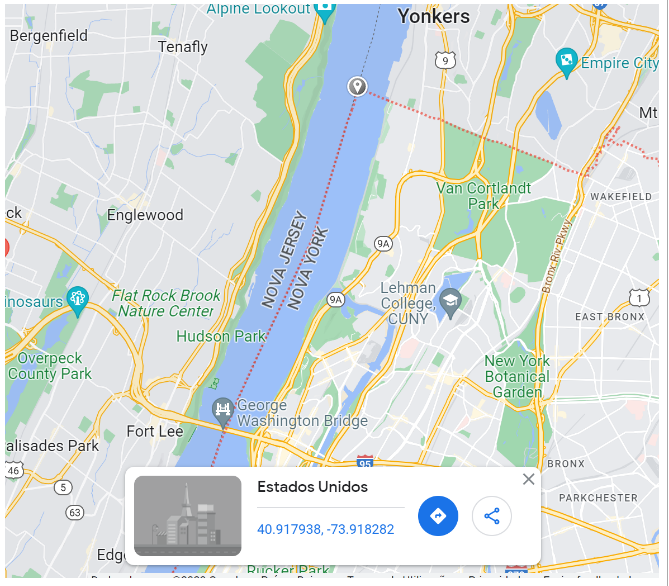

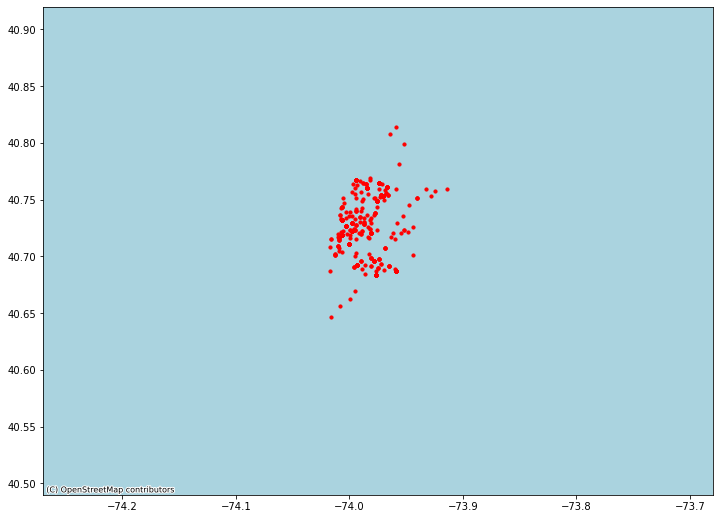

In [25]:
geo_data = trips.copy()
unique_stations = geo_data.drop_duplicates(subset=['end_station_latitude', 'end_station_longitude']).copy()
unique_stations['geometry'] = unique_stations.apply(lambda row: Point(row.start_station_longitude, row.start_station_latitude), axis=1)
gdf = gpd.GeoDataFrame(unique_stations, geometry='geometry')
extent = [-74.27, -73.68, 40.49, 40.92]  # Adjust the values to define the region

# Plot the station locations on top of the base map
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

# Use a contextily basemap provider
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik,  zoom=12)

# Plot the station locations on top of the base map
gdf.plot(ax=ax, color='red', markersize=10)

# Display the map
plt.show()

In [30]:
outlier_latitude_start = trips[(trips['start_station_latitude'] >= 41) | (trips['start_station_latitude'] <= 40.5)]
outlier_latitude_end = trips[(trips['end_station_latitude'] >= 41) | (trips['end_station_latitude'] <= 40.5)]
outlier_longitude_start = trips[(trips['start_station_longitude'] >= -73.7) | (trips['start_station_longitude'] <= -74.3)]
outlier_longitude_end = trips[(trips['end_station_longitude'] >= -73.7) | (trips['end_station_longitude'] <= -74.3)]

print(len(outlier_latitude_start))
print(len(outlier_latitude_end))
print(len(outlier_longitude_start))
print(len(outlier_longitude_end))

45417
65
65
65


In [31]:
trips = trips[(trips['start_station_latitude'] <= 41) & (trips['start_station_latitude'] >= 40.5)]
trips = trips[(trips['end_station_latitude'] <= 41) & (trips['end_station_latitude'] >= 40.5)]

Text(0, 0.5, 'Latitude')

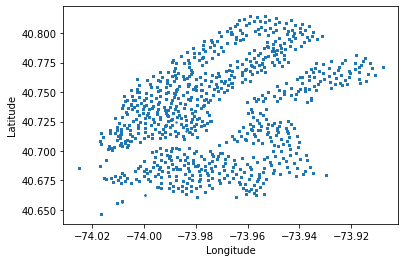

In [32]:
plt.scatter(trips["start_station_longitude"],trips["start_station_latitude"], s=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

**With the below graphic we understand that something is off with the age data. There are a lot of people over 100 years old contributing to increase the noise in the dataset.**

**There is also a big spike in people born in 1969, which is probably the year set as «default» for people that do not submit their age to the platform**

C:\Users\User\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


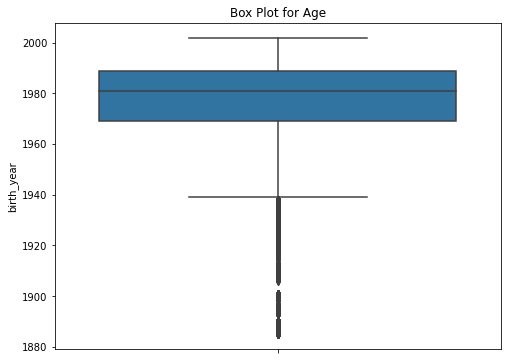

In [33]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Create a boxplot for the 'age' column
sns.boxplot(data=trips, y='birth_year')

plt.title('Box Plot for Age')  # Set the title
plt.show()  # Display the plot



**Let's remove all birth years previous to 1938 (remove people older than 80)**

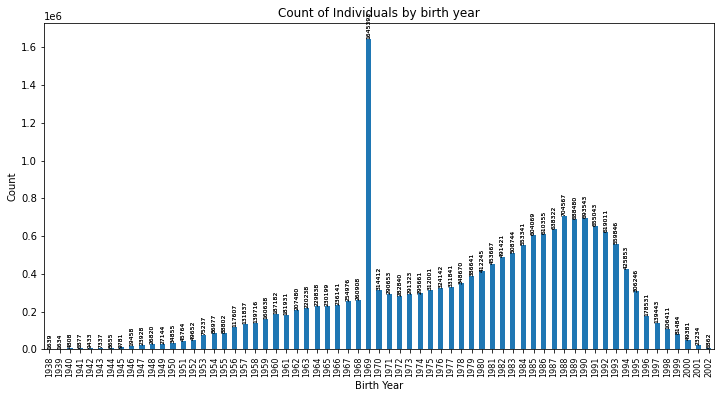

In [34]:
trips = trips[trips['birth_year'] >= 1938]

birth_year_count = trips['birth_year'].value_counts().sort_index()

# Create a bar plot
birth_year_count.plot(kind='bar', figsize=(12, 6))

ax = birth_year_count.plot(kind='bar', figsize=(12, 6))

# Customize the plot
plt.title('Count of Individuals by birth year')
plt.xlabel('Birth Year')
plt.ylabel('Count')

# Rotate x-axis labels vertically and set the font size for x-axis labels
plt.xticks(rotation='vertical', fontsize=8)

# Display the counting values on top of each bar
for i in ax.patches:
    ax.annotate(i.get_height(), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='bottom', rotation='vertical', fontsize=6)

# Show the plot
plt.show()

**We can see that there is a huge spike in people born in 1969.**

In [35]:
born_in_1969 = trips[trips['birth_year'] == 1969]
not_born_in_1969 = trips[trips['birth_year'] != 1969]

customer_count_1969 = born_in_1969['dummy_Customer'].sum()
subscriber_count_1969 = born_in_1969['dummy_Subscriber'].sum()
customer_count = not_born_in_1969['dummy_Customer'].sum()
subscriber_count = not_born_in_1969['dummy_Subscriber'].sum()

percentage_of_subscribers_not1969 = subscriber_count/(customer_count + subscriber_count)
percentage_of_subscribers_1969 = subscriber_count_1969/(customer_count_1969 + subscriber_count_1969)

print("The percentage of people born in 1969 that are subscribers is:",percentage_of_subscribers_1969)
print("The percentage of people not born in 1969 that are subscribers is:",percentage_of_subscribers_not1969)

The percentage of people born in 1969 that are subscribers is: 0.293839222605177
The percentage of people not born in 1969 that are subscribers is: 0.9528118269942364


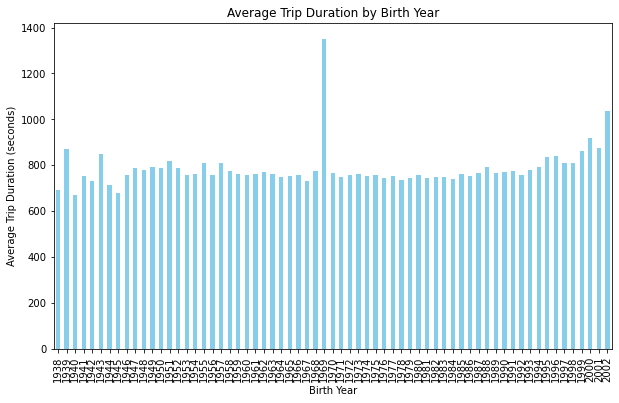

In [36]:
average_duration_by_birth_year = trips.groupby('birth_year')['tripduration'].mean()

# Create a bar plot
average_duration_by_birth_year.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Customize the plot
plt.title('Average Trip Duration by Birth Year')
plt.xlabel('Birth Year')
plt.ylabel('Average Trip Duration (seconds)')

# Show the plot
plt.show()

**Not only are there a lot of people born in 1969, but only 30% of them are subscribers, while 95.3% of people not born in that year are subscribers. Besides this, we can see that people "born in 1969" have longer duration trips, on average, than the rest of the population. We can infer that this birth year is the default birth year set for people that are not subscribers, and rent the bike for longer periods of time, for example tourists. We will not perform in-depth analyses based on the birth-year because of this.**

## Inicial Analysis


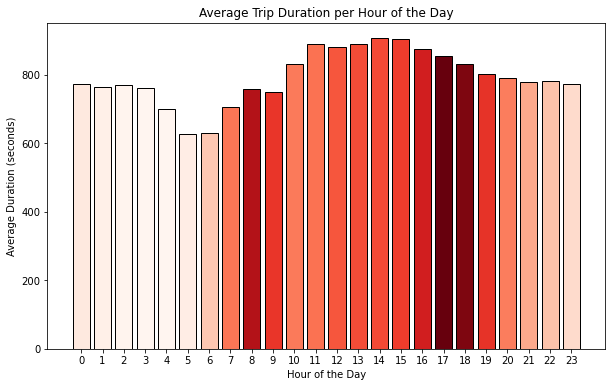

In [37]:
trips['Hour of Day'] = trips['starttime'].dt.hour

hourly_avg_duration = trips.groupby('Hour of Day')['tripduration'].mean()
hourly_pickup_count = trips.groupby('Hour of Day').size()

# Create a colormap based on the number of pickups
cmap = plt.get_cmap('Reds')

# Normalize the number of pickups to the colormap range
normed_pickups = (hourly_pickup_count - min(hourly_pickup_count)) / (max(hourly_pickup_count) - min(hourly_pickup_count))

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(hourly_avg_duration.index, hourly_avg_duration.values, color=cmap(normed_pickups), edgecolor='black')
plt.xticks(range(24))
plt.title('Average Trip Duration per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Duration (seconds)')

# Show the histogram
plt.show()

**As expected, there are spikes in the number of trips around 8 am and between 16pm and 19pm, when people are going to and leaving work/school. During the night the number of trips is very low and their average durations are also lower than during the day.**

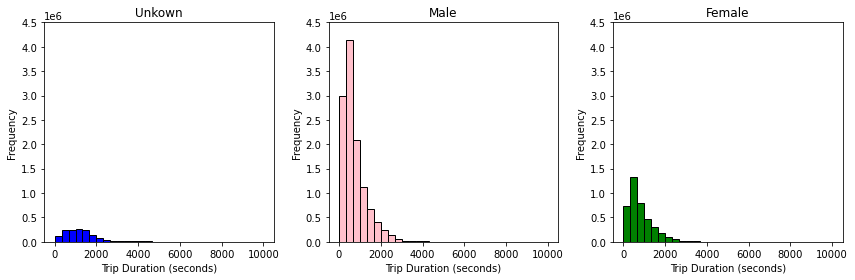

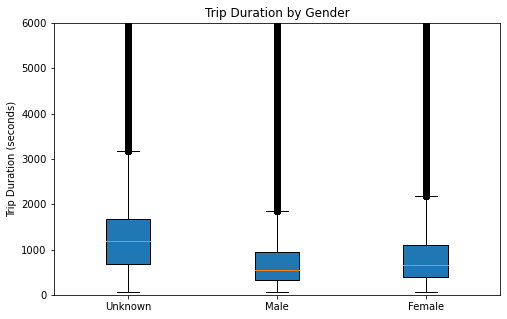

In [39]:
plt.figure(figsize=(12, 4))

# Histogram for Male (gender 0)
plt.subplot(1, 3, 1)
trips[trips['gender'] == 0]['tripduration'].plot(kind='hist', color='blue', edgecolor='black', bins=30, range=(0, 10000))
plt.title('Unkown')
plt.ylim(0, 4500000)
plt.xlabel('Trip Duration (seconds)')

# Histogram for Female (gender 1)
plt.subplot(1, 3, 2)
trips[trips['gender'] == 1]['tripduration'].plot(kind='hist', color='pink', edgecolor='black', bins=30, range=(0, 10000))
plt.title('Male')
plt.ylim(0, 4500000)
plt.xlabel('Trip Duration (seconds)')

# Histogram for Other (gender 2)
plt.subplot(1, 3, 3)
trips[trips['gender'] == 2]['tripduration'].plot(kind='hist', color='green', edgecolor='black', bins=30, range=(0, 10000))
plt.title('Female')
plt.ylim(0, 4500000)
plt.xlabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

# Create a boxplot
plt.figure(figsize=(8, 5))
boxplot_data = [trips[trips['gender'] == 0]['tripduration'],
                trips[trips['gender'] == 1]['tripduration'],
                trips[trips['gender'] == 2]['tripduration']]
labels = ['Unknown', 'Male', 'Female']
plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
plt.title('Trip Duration by Gender')
plt.ylabel('Trip Duration (seconds)')
plt.ylim(0, 6000)
plt.show()

**Also here we can see that Customers, with 24h or 3-day passes are probably set as unknown gender, and travel more than the rest of the population**

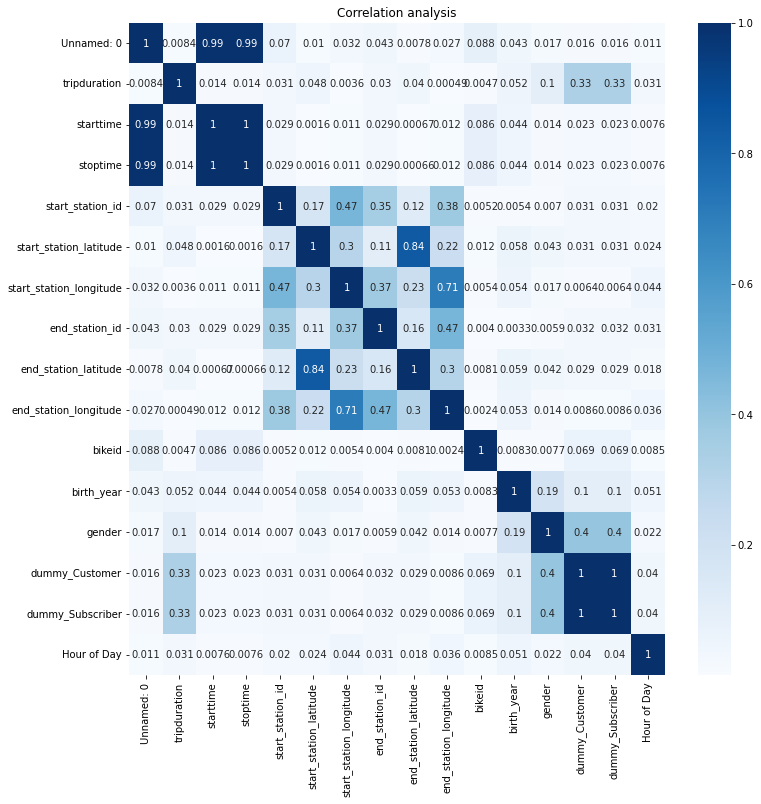

In [40]:
from matplotlib.pyplot import figure, savefig, show, title
from seaborn import heatmap

corr_mtx = abs(trips.corr())

fig = figure(figsize=[12, 12])

heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
title('Correlation analysis')
show()

# Section 2: Prediction Challenge

In [41]:
# Specify the number of clusters (e.g., 20)
n_clusters = 20

# Extract the spatial features (latitude and longitude)
spatial_data = trips[['start_station_latitude', 'start_station_longitude']].values

# Initialize and fit the K-Means clustering model
kmeans = KMeans(n_clusters=n_clusters)
trips['cluster'] = kmeans.fit_predict(spatial_data)


In [43]:
cluster_counts = trips['cluster'].value_counts()
cluster_counts_sorted = cluster_counts.sort_index()

# Print the sorted cluster counts
print(cluster_counts_sorted)


cluster
0     1381894
1      564997
2      681262
3     1039183
4     1750955
5     1260585
6      787606
7     1198499
8      831000
9     1413076
10     263728
11    1451431
12    1373288
13     997064
14     467692
15     547455
16     485776
17     272210
18     329846
19     323621
Name: count, dtype: int64


In [45]:
max_demand_cluster = cluster_counts_sorted.idxmax()
num_lines_max_demand_cluster = cluster_counts_sorted.max()

# Print the cluster with the highest number of lines and the number of lines
print(f"The cluster {max_demand_cluster} has the highest demand with a total of {num_lines_max_demand_cluster}")


The cluster 4 has the highest demand with a total of 1750955


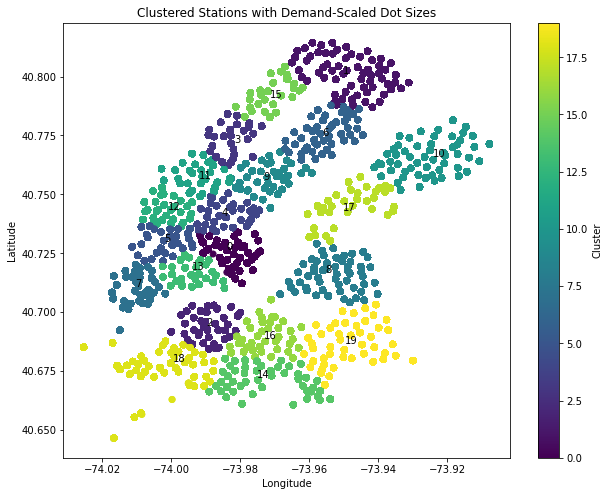

In [46]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'trips' with columns 'start_station_longitude', 'start_station_latitude', and 'cluster'

# Group the data by the 'cluster' column to get the cluster centers
cluster_centers = trips.groupby('cluster')[['start_station_longitude', 'start_station_latitude']].mean()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(trips['start_station_longitude'], trips['start_station_latitude'], c=trips['cluster'], cmap='viridis')

# Annotate the cluster centers with their corresponding cluster numbers
for cluster, center in cluster_centers.iterrows():
    plt.annotate(str(cluster), (center['start_station_longitude'], center['start_station_latitude']), fontsize=10, color='black')

plt.title('Clustered Stations with Demand-Scaled Dot Sizes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a colorbar for the legend
cbar = plt.colorbar(scatter, label='Cluster')

# Show the plot
plt.show()



In [47]:
print(f'we will use cluster {max_demand_cluster} because its the one that has bigger demand')

we will use cluster 4 because its the one that has bigger demand


It can be a good idea to cluster based on demand and spacial zone

**Balanced Cluster Sizes:** Incorporating demand can help ensure that clusters have a balanced number of bike zones. This prevents situations where a single cluster might have many small, high-demand zones while another cluster has large, low-demand zones. Balanced clusters make it easier to manage resources and analyze trends.

**Identify High-Demand Areas:** Clustering based on both spatial distribution and demand can help identify clusters that represent high-demand areas. This can be valuable for allocating resources, such as adding more bikes or docks in those areas to meet demand.

**Lets consider now also the demand in our clustering**

In [48]:
from sklearn.cluster import KMeans

# Specify the number of clusters
n_clusters = 20

# Calculate the demand (number of lines) for each bike zone
bike_zone_demand = trips.groupby(['start_station_latitude', 'start_station_longitude']).size().reset_index(name='demand')

# Extract the spatial features (latitude and longitude)
spatial_data = bike_zone_demand[['start_station_latitude', 'start_station_longitude']].values

# Extract the demand feature (number of lines per bike zone)
demand_data = bike_zone_demand['demand'].values.reshape(-1, 1)  # Reshape to a 2D array

# Concatenate the spatial and demand features
combined_data = np.hstack((spatial_data, demand_data))

# Initialize and fit the K-Means clustering model
kmeans = KMeans(n_clusters=n_clusters)
bike_zone_demand['cluster'] = kmeans.fit_predict(combined_data)



**Pick-ups modelling**

As we said before will use cluster 4, first we will do an hour predicition so we need to divide demand by hour

In [49]:
trips.shape

(17421168, 17)

In [50]:
trips.index = pd.to_datetime(trips['starttime'])

# Create 'day' and 'hour' columns based on the index

trips['month'] = trips['starttime'].dt.month

train_data = trips[trips['month'] < 11]  # Before November
test_data = trips[trips['month'] >= 11]  # After or from November


train_data = train_data.drop(columns=['month'])
test_data = test_data.drop(columns=['month'])

train_data['date'] = train_data.index.date
train_data['hour'] = train_data.index.hour

test_data['date'] = test_data.index.date
test_data['hour'] = test_data.index.hour


#Filter the data for Max Demand Cluster 
cluster_data_train = train_data[train_data['cluster'] == max_demand_cluster]
cluster_data_test = test_data[test_data['cluster'] == max_demand_cluster]

# Group by 'date' and 'hour', and count the number of trips in each group
grouped_train = cluster_data_train.groupby(['date', 'hour']).size().reset_index(name='demand')

grouped_test = cluster_data_test.groupby(['date', 'hour']).size().reset_index(name='demand')

**Build Lagged**

In [51]:
def buildLaggedFeatures(s,columns, lag=24,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [52]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
    
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 1000], [0, 1000], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

In [53]:
train_lagged=buildLaggedFeatures(grouped_train, ['demand'], lag=24)
fllen=len(train_lagged)

In [56]:
train_lagged.head()

,date,hour,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,...,demand_lag15,demand_lag16,demand_lag17,demand_lag18,demand_lag19,demand_lag20,demand_lag21,demand_lag22,demand_lag23,demand_lag24
24,2018-01-02,0,6,4.0,19.0,31.0,28.0,36.0,49.0,53.0,...,15.0,12.0,11.0,6.0,3.0,2.0,8.0,10.0,14.0,13.0
25,2018-01-02,1,2,6.0,4.0,19.0,31.0,28.0,36.0,49.0,...,21.0,15.0,12.0,11.0,6.0,3.0,2.0,8.0,10.0,14.0
26,2018-01-02,2,3,2.0,6.0,4.0,19.0,31.0,28.0,36.0,...,33.0,21.0,15.0,12.0,11.0,6.0,3.0,2.0,8.0,10.0
27,2018-01-02,4,4,3.0,2.0,6.0,4.0,19.0,31.0,28.0,...,47.0,33.0,21.0,15.0,12.0,11.0,6.0,3.0,2.0,8.0
28,2018-01-02,5,19,4.0,3.0,2.0,6.0,4.0,19.0,31.0,...,50.0,47.0,33.0,21.0,15.0,12.0,11.0,6.0,3.0,2.0


In [55]:
train_lagged.corr()

TypeError: float() argument must be a string or a number, not 'datetime.date'

In [57]:
s1=train_lagged['demand']
autocorrs = [s1.autocorr(lag) for lag in range(1,240)]

In [58]:
autocorrs

[0.8520286453695034,
 0.603293733986905,
 0.41319188209698093,
 0.2768778478066261,
 0.15303694127127945,
 0.029837619571046456,
 -0.06204414539672043,
 -0.08607379955577107,
 -0.09355216598461147,
 -0.17723420357574426,
 -0.2933827909189831,
 -0.3457312655099057,
 -0.3130776098363984,
 -0.2180303680991341,
 -0.14448195457564586,
 -0.12703299950857005,
 -0.08929419370384627,
 0.006564632202027048,
 0.1266036172876162,
 0.24259259266047697,
 0.36335383333222804,
 0.5198557703536049,
 0.7051151339848131,
 0.7954282107292604,
 0.6824899588365517,
 0.48901784136356524,
 0.3370354563696558,
 0.22167846627463114,
 0.11116917872374271,
 -0.0009849536502964263,
 -0.09198083077418474,
 -0.13553213462782776,
 -0.16894136256596262,
 -0.25483912855000274,
 -0.3549373041644792,
 -0.3969353384329193,
 -0.3648102065849234,
 -0.2802567782816526,
 -0.2045198582385191,
 -0.16159824601400735,
 -0.10108253544345658,
 -1.0331922688301133e-06,
 0.11395907870006516,
 0.2222349422108861,
 0.3296171444194445,


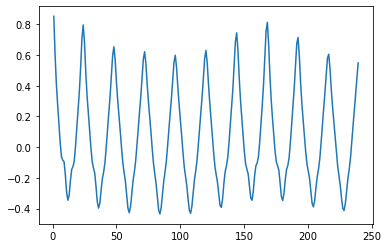

In [59]:
plt.plot(range(1,240), autocorrs)
plt.show()

In [60]:
x_train =np.c_[np.ones(len(train_lagged)),train_lagged['demand_lag1'], train_lagged['demand_lag2'], train_lagged['demand_lag3'], train_lagged['demand_lag4'], train_lagged['demand_lag5'], train_lagged['demand_lag6'], train_lagged['demand_lag7'], train_lagged['demand_lag8'], train_lagged['demand_lag9'], train_lagged['demand_lag10'], train_lagged['demand_lag11'], train_lagged['demand_lag12'], train_lagged['demand_lag13'], train_lagged['demand_lag14'], train_lagged['demand_lag15'], train_lagged['demand_lag16'], train_lagged['demand_lag17'], train_lagged['demand_lag18'], train_lagged['demand_lag19'], train_lagged['demand_lag20'], train_lagged['demand_lag21'], train_lagged['demand_lag22'], train_lagged['demand_lag23'], train_lagged['demand_lag24']]

In [61]:
y_train =np.array(train_lagged['demand'], ndmin=2).T

In [64]:
lm=linear_model.LinearRegression(fit_intercept=False)
lm.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

Coefficients: 
 [[ 1.22743725e+01  1.08945307e+00 -5.57683205e-01  2.36854121e-01
  -3.47863883e-02 -6.53426161e-02 -3.92027818e-03 -1.41356905e-02
  -2.47537491e-02  2.59203172e-01 -1.86590718e-01 -1.00957569e-01
   1.54512101e-01 -2.08644401e-01  1.65590208e-01  7.39437967e-02
  -1.63395532e-01  7.77829960e-02 -8.64555620e-02  3.05355736e-02
   7.95611673e-02 -1.35995937e-02 -4.60395362e-02  2.97173971e-01
  -1.59195175e-02]]
Mean Absolute error (MAE): 46.46
Root Mean squared error: 69.08
Variance score: 0.88


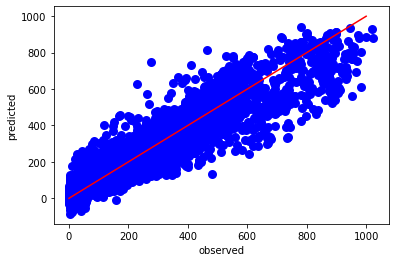

In [65]:
my_plot(lm, x_train, y_train)

In [66]:
test_lagged=buildLaggedFeatures(grouped_test, ['demand'], lag=24)

In [67]:
x_test =np.c_[np.ones(len(test_lagged)),test_lagged['demand_lag1'], test_lagged['demand_lag2'], test_lagged['demand_lag3'], test_lagged['demand_lag4'], test_lagged['demand_lag5'], test_lagged['demand_lag6'], test_lagged['demand_lag7'], test_lagged['demand_lag8'], test_lagged['demand_lag9'], test_lagged['demand_lag10'], test_lagged['demand_lag11'], test_lagged['demand_lag12'], test_lagged['demand_lag13'], test_lagged['demand_lag14'], test_lagged['demand_lag15'], test_lagged['demand_lag16'],test_lagged['demand_lag17'], test_lagged['demand_lag18'], test_lagged['demand_lag19'], test_lagged['demand_lag20'], test_lagged['demand_lag21'], test_lagged['demand_lag22'], test_lagged['demand_lag23'], test_lagged['demand_lag24']]

In [68]:
y_test =np.array(test_lagged['demand'], ndmin=2).T

Coefficients: 
 [[ 1.22743725e+01  1.08945307e+00 -5.57683205e-01  2.36854121e-01
  -3.47863883e-02 -6.53426161e-02 -3.92027818e-03 -1.41356905e-02
  -2.47537491e-02  2.59203172e-01 -1.86590718e-01 -1.00957569e-01
   1.54512101e-01 -2.08644401e-01  1.65590208e-01  7.39437967e-02
  -1.63395532e-01  7.77829960e-02 -8.64555620e-02  3.05355736e-02
   7.95611673e-02 -1.35995937e-02 -4.60395362e-02  2.97173971e-01
  -1.59195175e-02]]
Mean Absolute error (MAE): 37.60
Root Mean squared error: 56.17
Variance score: 0.87


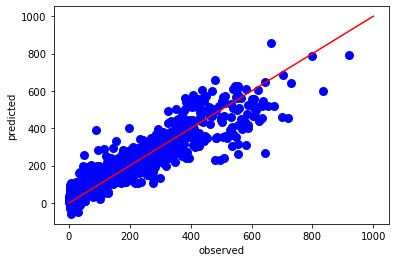

In [69]:
my_plot(lm, x_test, y_test)

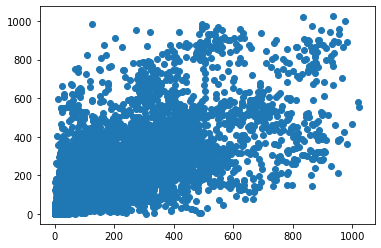

In [70]:
plt.scatter(train_lagged['demand_lag1'], train_lagged['demand_lag24'])

# Section 3: Exploratory Component

* for how long do the stations stay full for, how long does it take for someome to take a bycicle to be able to put a bike stop 
* for how long do the empty statios stay like that for
* zones with more traffic do they use more bikes 
* see holidays 
* see weather 
* see hilly zones (usually more hilly has less bikes go there) 


# Section 4: Conclusions

In [68]:
import datetime
# Create a list of dates from January 1st to December 31st of 2018
start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2018, 12, 31)
date_list = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Create a list of hours (1 to 24)
hours = list(range(1, 25))

# Create a MultiIndex from date and hour
date_hour_index = pd.MultiIndex.from_product([date_list, hours], names=['Date', 'Hour'])

# Create a DataFrame with the MultiIndex
df = pd.DataFrame(index=date_hour_index)

# Populate the DataFrame with some example values
df['Value'] = range(len(df))

# Reset the index if needed
df.reset_index(inplace=True)

# Display the DataFrame
df

,Date,Hour,Value
0,2018-01-01,1,0
1,2018-01-01,2,1
2,2018-01-01,3,2
3,2018-01-01,4,3
4,2018-01-01,5,4
...,...,...,...
8755,2018-12-31,20,8755
8756,2018-12-31,21,8756
8757,2018-12-31,22,8757
8758,2018-12-31,23,8758


In [82]:
print(len(trips))
print(train_lagged['demand'].sum() + test_lagged['demand'].sum())
print(grouped_train['demand'].sum() + grouped_test['demand'].sum())

17421168
1742882
1750955
